<a href="https://colab.research.google.com/github/purekikan/Thai-Traditional-Music-Generation-with-LSTM/blob/main/TH_Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependency

In [ ]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import pandas as pd
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
#assert len(tf.config.list_physical_devices('GPU')) > 0

'''!pip install --upgrade music21
import music21 as m'''

#Installing FuzzyWuzzy
!pip install fuzzywuzzy
!pip install python-Levenshtein
#Import
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

!pip install mutagen
import mutagen
from mutagen.wave import WAVE

import shutil
from pathlib import Path
import glob

from datetime import date

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import gspread_dataframe as gd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 32.6 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115441 sha256=62a2c33e6cf13554bb68da2649fa6e6804147f825bff5d4bdd3388d27b16634c
  Stored in directory: /root/.cache/pip/wheels/2e/45/44/c5b304f31f37e8d2315f9e969fd8cdb0014a5c28608d0bf410
Successfully built mitdeeplearning
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 36.5 MB/s 
     |████████████████████████████████| 2.2 MB 54.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193 kB 

In [ ]:
#m.VERSION

# LSTM

## Files Download to ABC

In [ ]:
gc = gspread.authorize(creds)
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/14LE4nf21YTBzJQNytVNMG30FBGaNag9KuKr52mjF8OQ/edit')

In [ ]:
data = wb.worksheet('Sheet1').get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]
df['Filenames']

1                      Chang1.mid
2                ChomSangJun1.mid
3                ChomSangJun3.mid
4     ChuenChumnumKlumDontri2.mid
5                 GareanTong1.mid
6                 GareanTong3.mid
7                  GlomNaree1.mid
8                  GlomNaree3.mid
9           HomRongJomSurang3.mid
10           HomRongMahaRurk3.mid
11         HomRongPatomDusit3.mid
12           Kangkowkinkluay1.mid
13              KeakBorathes1.mid
14              KeakBorathes2.mid
15              KeakBorathes3.mid
16                   KhamWan2.mid
17              KhmerPaiRuea1.mid
18              KhmerPaiRuea2.mid
19              KhmerPaiRuea3.mid
20                KhmerPuang1.mid
21                KhmerPuang2.mid
22                KhmerPuang3.mid
23               KhmerSaiYok3.mid
24                  KhruanHa1.mid
25                  KhruanHa3.mid
26          KluenKrathobFang2.mid
27                LaoComeHom2.mid
28              LaoDuangDeon2.mid
29                    LaoJoi2.mid
30            

In [ ]:
df['Filenames']

1                      Chang1.mid
2                ChomSangJun1.mid
3                ChomSangJun3.mid
4     ChuenChumnumKlumDontri2.mid
5                 GareanTong1.mid
6                 GareanTong3.mid
7                  GlomNaree1.mid
8                  GlomNaree3.mid
9           HomRongJomSurang3.mid
10           HomRongMahaRurk3.mid
11         HomRongPatomDusit3.mid
12           Kangkowkinkluay1.mid
13              KeakBorathes1.mid
14              KeakBorathes2.mid
15              KeakBorathes3.mid
16                   KhamWan2.mid
17              KhmerPaiRuea1.mid
18              KhmerPaiRuea2.mid
19              KhmerPaiRuea3.mid
20                KhmerPuang1.mid
21                KhmerPuang2.mid
22                KhmerPuang3.mid
23               KhmerSaiYok3.mid
24                  KhruanHa1.mid
25                  KhruanHa3.mid
26          KluenKrathobFang2.mid
27                LaoComeHom2.mid
28              LaoDuangDeon2.mid
29                    LaoJoi2.mid
30            

In [ ]:
songs = []
n=0

# /content/drive/MyDrive/Project M.5/MIDIs/KluenKrathobFang.mid

for index, x in df.iterrows():
  abc = !midi2abc /content/drive/MyDrive/31LA02-01/Project_M.5/60SongSet/60MIDIs/{x['Filenames']} -k -2 -m 2/2 -title {n}
  abc_list = []
  for x in abc:
    if not x.startswith(("V:", "%")):
      abc_list.append(x.split(' %')[0])
  #print(jaij)
  abc_prcesd = f'X: {n}'+'\n'.join(abc_list)[4:]+'!'
  print(abc_prcesd)
  songs.append(abc_prcesd)
  n+=1

X: 0
T: 0
M: 2/2
L: 1/8
Q:1/4=60
K:Bb
F2 F2 F3F| \
DC DF2<B,2F| \
DC DB, CB, GB,| \
B, (3G2F2B,2B, G3/2B,/2|
B, (3G2F2B,2F GF| \
D2 C2 B,/2!
X: 1
T: 1
M: 2/2
L: 1/8
Q:1/4=60
K:Bb
d/2c/2A/2c/2 A/2G<=EG/2A/2c/2 G2| \
d/2c/2A/2c/2 A/2G/2=E/2G/2 =E/2D/2C/2D/2 C2| \
g=e d=e/2g/2 =e/2d/2c/2d/2 =e2| \
g=e d=e/2g/2 =e/2d/2c/2d/2 c2|
F/2F/2F =ED3/2A/2c/2A/2 G2| \
F/2F/2F =ED3/2g/2=e/2c/2 d2| \
c/2c/2c AG3/2G/2c/2d/2 =e2| \
c/2c/2c AG3/2A/2G/2A/2 G2|
d/2c/2A/2c/2 A/2G<=EG/2A/2c<GD/2| \
=E/2G/2A/2c/2 GA/2G/2 A/2c/2d/2=e/2 cd-| \
d/2=e/2d/2c/2 A/2c<Gc/2A/2G/2 =E/2G/2D| \
D/2=E/2G =E/2G/2A G/2A/2c A/2c/2d/2!
X: 2
T: 2
M: 2/2
L: 1/8
Q:1/4=60
K:Bb
B2 G2 F2 D2-| \
D2 C/2D/2C/2D/2 B,C DC| \
C2 D2 F2 G2| \
c2 B2 G2 F2|
B2 G2 F2 D2-| \
D2 C/2D/2C/2D/2 B,C DF| \
F2 Gc/2B/2 GF D2-| \
D/2F/2G/2B,/2 C/2D/2C/2F/2 DC B,2|
B2 G2 F2 D2-| \
D2 C/2D/2C/2D/2 B,C DC| \
C2 D2 F2 G2| \
c2 B2 G2 F2|
B2 G2 F2 D2-| \
D2 C/2D/2C/2D/2 B,C DF| \
F2 Gc/2B/2 GF D2-| \
D/2F/2G/2B/2 c/2d/2c/2f/2 dc B2-|
B3G G2 Bd/2c/2| \
BF B3/

In [ ]:
songs_joined = '\n\n'.join(songs)
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 45 unique characters in the dataset


## Process the Dataset

In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [ ]:
idx2char

array(['\n', ' ', '!', '(', ',', '-', '/', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', ':', '<', '=', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'K', 'L', 'M', 'Q', 'T', 'X', '[', '\\', ']', '_', 'b', 'c',
       'd', 'e', 'f', 'g', 'x', '|'], dtype='<U1')

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '(' :   3,
  ',' :   4,
  '-' :   5,
  '/' :   6,
  '0' :   7,
  '1' :   8,
  '2' :   9,
  '3' :  10,
  '4' :  11,
  '5' :  12,
  '6' :  13,
  '7' :  14,
  '8' :  15,
  '9' :  16,
  ':' :  17,
  '<' :  18,
  '=' :  19,
  ...
}


In [ ]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function 
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

# def vectorize_string(string):
  # TODO

vectorized_songs = vectorize_string(songs_joined)

In [ ]:
vectorized_songs

array([32, 17,  1, ...,  9,  1,  2])

In [ ]:
songs_joined

'X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=60\nK:Bb\nF2 F2 F3F| \\\nDC DF2<B,2F| \\\nDC DB, CB, GB,| \\\nB, (3G2F2B,2B, G3/2B,/2|\nB, (3G2F2B,2F GF| \\\nD2 C2 B,/2!\n\nX: 1\nT: 1\nM: 2/2\nL: 1/8\nQ:1/4=60\nK:Bb\nd/2c/2A/2c/2 A/2G<=EG/2A/2c/2 G2| \\\nd/2c/2A/2c/2 A/2G/2=E/2G/2 =E/2D/2C/2D/2 C2| \\\ng=e d=e/2g/2 =e/2d/2c/2d/2 =e2| \\\ng=e d=e/2g/2 =e/2d/2c/2d/2 c2|\nF/2F/2F =ED3/2A/2c/2A/2 G2| \\\nF/2F/2F =ED3/2g/2=e/2c/2 d2| \\\nc/2c/2c AG3/2G/2c/2d/2 =e2| \\\nc/2c/2c AG3/2A/2G/2A/2 G2|\nd/2c/2A/2c/2 A/2G<=EG/2A/2c<GD/2| \\\n=E/2G/2A/2c/2 GA/2G/2 A/2c/2d/2=e/2 cd-| \\\nd/2=e/2d/2c/2 A/2c<Gc/2A/2G/2 =E/2G/2D| \\\nD/2=E/2G =E/2G/2A G/2A/2c A/2c/2d/2!\n\nX: 2\nT: 2\nM: 2/2\nL: 1/8\nQ:1/4=60\nK:Bb\nB2 G2 F2 D2-| \\\nD2 C/2D/2C/2D/2 B,C DC| \\\nC2 D2 F2 G2| \\\nc2 B2 G2 F2|\nB2 G2 F2 D2-| \\\nD2 C/2D/2C/2D/2 B,C DF| \\\nF2 Gc/2B/2 GF D2-| \\\nD/2F/2G/2B,/2 C/2D/2C/2F/2 DC B,2|\nB2 G2 F2 D2-| \\\nD2 C/2D/2C/2D/2 B,C DC| \\\nC2 D2 F2 G2| \\\nc2 B2 G2 F2|\nB2 G2 F2 D2-| \\\nD2 C/2D/2C/2D/2 B,C DF| \\\n

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X: 0\nT: 0\n' ---- characters mapped to int ----> [32 17  1  7  0 31 17  1  7  0]


In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)
  print(idx)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  # input_batch = # TODO
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  # output_batch = # TODO

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[51666 36682]
[PASS] test_batch_func_types
[19949  6267]
[PASS] test_batch_func_shapes
[23218 36965]
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

[55915]
Step   0
  input: 1 (' ')
  expected output: 26 ('G')
Step   1
  input: 26 ('G')
  expected output: 6 ('/')
Step   2
  input: 6 ('/')
  expected output: 9 ('2')
Step   3
  input: 9 ('2')
  expected output: 21 ('B')
Step   4
  input: 21 ('B')
  expected output: 6 ('/')


## Model

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units), 
    # LSTM('''TODO'''),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
    # '''TODO: DENSE LAYER HERE'''
  ])

  return model

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  # loss = tf.keras.losses.sparse_categorical_crossentropy('''TODO''', '''TODO''', from_logits=True) # TODO
  return loss

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optmz[param_set].apply_gradients(zip(grads, model.trainable_variables))
  return loss

### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string] # TODO
  # input_eval = ['''TODO''']
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # predictions = model('''TODO''')
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
      #print(str(idx2char[predicted_id]))
      #test_loss, _, test_acc = model.evaluate(input_eval, idx2char[predicted_id])
    
  return (start_string + ''.join(text_generated))

## Evaluate

In [ ]:
def get_fzwz(generated_text, songs):
  fzwzscore_f = []
  fzwzscore_p = []
  for generated_song in mdl.lab1.extract_song_snippet(generated_text):
    
    full = [s[-1] for s in process.extract(generated_song, songs, scorer=fuzz.ratio, limit = len(songs))]
    partial = [s[-1] for s in process.extract(generated_song, songs, scorer=fuzz.partial_ratio, limit = len(songs))]

    fzwzscore_f.append(sum(full)/len(full))
    fzwzscore_p.append(sum(partial)/len(partial))
  #fzwz_f_t.extend(fzwzscore_f)
  #fzwz_p_t.extend(fzwzscore_p)
  return fzwzscore_f, fzwzscore_p
class mp3_converter():
    def __init__(self, path, ext, dirName):
        """Class that takes folder of music files of one file type, 
        converts them to mp3 and creates a new directory and moves them into it
        Input path of files that you would like to convert
        Extension of files you would like to convert i.e. WAV
        Folder name of the new directory you would like to create"""
        self.path = path
        self.ext = ext
        self.dirName = dirName

    def lower_underscore(self):
        """
        Converts all files in path to lowercase
        Replaces all spaces in filename with _
        """
        directory = self.path
        [os.rename(os.path.join(directory, f), os.path.join(directory, f).replace(' ', '_').lower()) for f in os.listdir(directory)]

    def mp3(self):
        """
        Converts all files in path with entered extension to mp3
        """
        directory = self.path

        for f in os.listdir(directory):
            if (f.endswith(self.ext)):
                os.system("ffmpeg -i {} -ar 44100 -ac 2 -b:a 192k {}/{}.mp3".format(
                    os.path.join(directory, f), directory, os.path.splitext(f)[0]))

    def make_dir(self):
        """
        Creates a directory for mp3's and moves all 
        previously created mp3's into it and moves the directory up one
        """
        mp3_directory = self.path + "/" + self.dirName
        if not os.path.exists(mp3_directory):
            os.makedirs(mp3_directory)
        for filename in os.listdir(self.path):
            if (filename.endswith(".mp3")):
                source = os.path.join(self.path, filename)
                dest = shutil.copy(source, mp3_directory)
                print(f"Moved {filename} to {dest}")
        '''try:
            parent_dir = Path(mp3_directory).parents[1]
            print(mp3_directory, parent_dir)
            shutil.move(mp3_directory, parent_dir)
        except IndexError:
            # no upper directory
            pass'''
            
def evaluate_song(generated_text, param_set, train_set, date = date.today()):
  #save song + count playable song + retrieve song length
  n = 0 #number of playable songs
  l = [] #length of playable songs
  generated_songs = mdl.lab1.extract_song_snippet(generated_text)
  for i, song in enumerate(generated_songs): 
    # Synthesize the waveform from a song
    waveform = mdl.lab1.play_song(song)
    #ipythondisplay.display(waveform)
    # If its a valid song (correct syntax), lets play it! 
    if waveform:
      print("Generated song", i+1)
      
      song_name = f'{date}--{param_set}.{train_set}.{n+1}.wav'
      
      with open(song_name, 'wb') as f:
        f.write(waveform.data)
      audio = WAVE(song_name)
      length = int(audio.info.length)
      l.append(length)
      n+=1
    
  #convert wav to mp3
  '''conv = mp3_converter('/content', ".wav", "/content/mp3")
  conv.lower_underscore()
  conv.mp3()
  #conv.make_dir()'''

  #calculate playable rate
  wav_play_rate = n/len(generated_songs)*100
  #calculate song duration avg and min
  gensonglen_avg = sum(l)/len(l)
  gensonglen_min = min(l)
  
  return wav_play_rate, gensonglen_avg, gensonglen_min

def save_song(dir = '/content/mp3'):
  conv = mp3_converter('/content', ".wav", dir)
  conv.lower_underscore()
  conv.mp3()
  conv.make_dir()

def save_config(param_set, train_set, date=date.today()):
  ckpt_dir = f'drive/MyDrive/Project_M.5/Project-M.5/LSTM/ckpt/{date}--{param_set}.{train_set}/'
  #print(ckpt_dir)
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
  for i in os.listdir("/content/training_checkpoints"):
    shutil.copy("/content/training_checkpoints/" + i, '/content/' + ckpt_dir + i)
  save_song(ckpt_dir)
  mp3_wavs = glob.glob("./*.wav")
  mp3_wavs.extend(glob.glob("./*.mp3"))
  for x in mp3_wavs:
    os.remove(x)

def train(num_training_iterations):
  for iter in tqdm(range(num_training_iterations)):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)
    #model.compile(loss, optimizer, metrics=['accuracy'])

    # Update the model with the changed weights!
    if iter % 100 == 0:     
      model.save_weights(checkpoint_prefix)
      
  # Save the trained model and the weights
  model.save_weights(checkpoint_prefix)

## Tester

In [ ]:
num_training_iterations = 2000  # Increase this to train longer

batch_size = 40  # Experiment between 1 and 64

seq_length = 115  # Experiment between 50 and 500
learning_rate = 5.00e-03
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 600
generation_length = 5000

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

param_set = 1
optmz = {}
fzwz_f_t = []
fzwz_p_t = []
play_rate = []
duration_avg = []
duration_min = []
optmz[1] = tf.keras.optimizers.Adam(learning_rate)
optimizer = optmz[1]
start_string = "X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb"
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

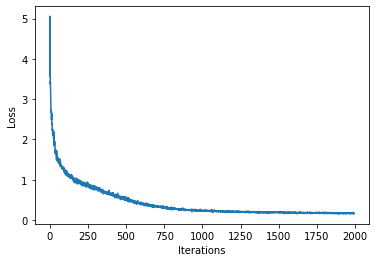

100%|█████████▉| 1996/2000 [01:04<00:00, 26.05it/s]

[52838 12607 11931 29547 25632  7862  1822 37661 50450 60961 17250 11931
 61345 50764 30337 46073 16044 59036 32824 30926 18110 45046 32280  5847
  6102 31231 61794 10357 33305 46746  6345 56112 42177 51621 60480 48705
 24560 21597 36111 28179]
[44332   964 23236 27089 56620 21801 36098 26110 61411 55888 35502 20990
 51380 49812 49414 37050 62164 20059 28818 15120 52340 15086    35  8432
  7979 45264   898 49986 37977 57295 50880 45815 21118 22672  3643 61162
 59008 14433 33636 29500]


100%|██████████| 2000/2000 [01:04<00:00, 31.08it/s]

[37093 26725 19474 10963 19868  4786 25514  7476 42257 33913 53018 16390
 28906 35542  1407 56626 32740 28513 37748 42592 23174 31168 39864 23710
 58411   804 23076 25667 55448 18813 15994  5248 52522   906 51428  8782
 17235 36676 19959  7556]
[ 7065 38762  8785 56471 59008 50550 10300  1075 48541 20902 40363  2794
 26063 24895 40883 21489 14199 50642 60038 61646 26168 60837 38396 20082
 34934  9571 18266  8883 48905 40689 46077 50229 33948 32956 22386 26630
 53580 11886 15285 35045]
[43413 19653 22020 55191 56649  1605 39899  6552 52392 25262 13476 48809
 16734 35399 23978 59590 56440 24787 23199 18855  2229 53861 48761 49586
 59044 19503  9989 22757 57417 55434 15866 29029 33608  7574 51692 46280
 20805 32674 19851 18381]


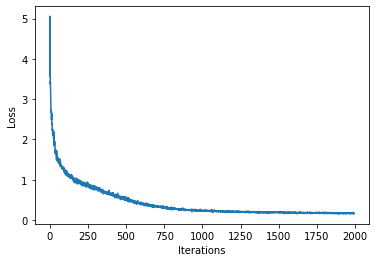

In [ ]:
score = 0
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)
  #model.compile(loss, optimizer, metrics=['accuracy'])
  
  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
#train(num_training_iterations)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
generated_text = generate_text(model, start_string=start_string, generation_length= generation_length)
fzwz = get_fzwz(generated_text, songs)
try:
  other_metrics = evaluate_song(generated_text, "test", "test")
except:
  print('no song is generated')
  other_metrics = [0,0,0]
  fzwz = [[0],[0]]
print(fzwz, other_metrics)

evaluate_song(generated_text, "test", "test")

100%|██████████| 5000/5000 [00:28<00:00, 175.33it/s]


Found 7 songs in text
Found 7 songs in text
Generated song 1
Generated song 2
Generated song 3
Generated song 4
Generated song 5
Generated song 6
Generated song 7
([42.96666666666667, 52.38333333333333, 50.516666666666666, 40.53333333333333, 54.15, 42.5, 55.78333333333333], [55.75, 68.75, 67.01666666666667, 69.1, 67.61666666666666, 69.5, 67.75]) (100.0, 82.28571428571429, 12)
Found 7 songs in text
Generated song 1
Generated song 2
Generated song 3
Generated song 4
Generated song 5
Generated song 6
Generated song 7


(100.0, 82.28571428571429, 12)

In [ ]:
evaluate_song(generated_text, "test", "test")

In [ ]:
save_song('test')

Moved tmp.mp3 to /content/drive/MyDrive/31LA02-01/Project_M.5/Project-M.5/LSTM/ckpt/test/batch_size=40/tmp.mp3
Moved 2022-12-21--test.test.1.mp3 to /content/drive/MyDrive/31LA02-01/Project_M.5/Project-M.5/LSTM/ckpt/test/batch_size=40/2022-12-21--test.test.1.mp3


# Attention RNN

## Autotrain Function

In [ ]:
gc = gspread.authorize(creds)
wb2 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ejzgtIDKtcLvVD792Mraw35THqAJwVpp5sEaETWlJyI/edit#gid=0').get_worksheet(0)

In [ ]:
data_param = wb2.get_all_values()
df = pd.DataFrame(data_param)
#print(df)
df.columns = df.iloc[1]
df = df.iloc[2:]
#df['Filenames']'''
df = df[df['Date']==str(date.today())]

parameters = ['num_training_iterations', 'batch_size', 'seq_length', 'learning_rate', 'rnn_units', 'optimizers', 'start_string', 'generation_length']
df = df[parameters]
row_no = list(df.index.values)
df

1,num_training_iterations,batch_size,seq_length,learning_rate,rnn_units,optimizers,start_string,generation_length
23,1000,4,100,5.00E-03,115,Adam,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500
24,1000,6,100,5.00E-03,115,Adam,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500
25,1000,10,100,5.00E-03,115,Adam,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500
26,1000,12,100,5.00E-03,115,Adam,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500
27,1000,14,100,5.00E-03,115,Adam,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500
28,1000,16,100,5.00E-03,115,Adam,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500
29,1000,18,100,5.00E-03,115,Adam,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500


In [ ]:
ggsheet = pd.DataFrame(data_param)

ggsheet.columns = ggsheet.iloc[1]
ggsheet = ggsheet.iloc[2:]
ggsheet

1,Date,Filename,Filename 2,Filename 3,Filename 4,Filename 5,num_training_iterations,batch_size,seq_length,learning_rate,...,start_string,generation_length,Others,Good/Bad,Fuzzywuzzy-full,Fuzzywuzzy-partial,Playable Rate,Duration_avg,Duration_min,Comments
2,2022-09-08,Download (8),-,-,-,-,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,20 songs (with LaoComeHom unable to open),Good,,,,,,"Best of today's song, all in one key, maybe a ..."
3,2022-12-16,2022-12-16--1.1.1.wav,2022-12-16--1.2.1.wav,2022-12-16--1.3.1.wav,2022-12-16--1.4.1.wav,2022-12-16--1.5.1.wav,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,Good,33.55166667,64.76,100,224.6,36.2,set 1 ปานกลาง/ set 2 พอได้ๆ แต่ไม่เท่า 4/ set ...
4,2022-12-16,2022-12-16--2.1.1.wav,2022-12-16--2.1.1.wav,none,2022-12-16--2.2.1.wav,2022-12-16--2.3.1.wav,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,22.7,33.97619048,60,459.8,459.8,
5,2022-12-16,none,2022-12-16--3.1.1.wav,2022-12-16--3.2.1.wav,2022-12-16--3.2.1.wav,2022-12-16--3.3.1.wav,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,22.31,28.86,60,294.8,294.8,
6,2022-12-16,2022-12-16--4.1.1.wav,2022-12-16--4.1.1.wav,none,2022-12-16--4.2.1.wav,none,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,8.076666667,9.593333333,20,36.4,36.4,
7,2022-12-16,2022-12-16--5.1.2.wav,2022-12-16--5.1.2.wav,none,2022-12-16--5.2.1.wav,none,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,12.64761905,30.9547619,40,0.8,0.8,
8,2022-12-16,none,2022-12-16--6.1.1.wav,none,2022-12-16--6.2.1.wav,none,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,11.48888889,26.28888889,20,1.2,1.2,
9,2022-12-16,none,2022-12-16--7.1.1.wav,none,2022-12-16--7.2.1.wav,none,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,7.753333333,9.44,20,279.2,279.2,
10,2022-12-16,2022-12-16--8.1.1.wav,2022-12-16--8.1.1.wav,2022-12-16--8.2.2.wav,2022-12-16--8.2.2.wav,2022-12-16--8.3.2.wav,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,22.32962963,36.32222222,60,3050.2,3050.2,
11,2022-12-16,2022-12-16--9.1.1.wav,2022-12-16--9.1.1.wav,none,2022-12-16--9.2.1.wav,2022-12-16--9.3.1.wav,1000,8,100,5.00E-03,...,X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb,1500,60 songs,,29.11428571,40.22857143,80,736,736,


In [ ]:
param_set=1
optmz = {}
for row in row_no:
  
  
  fzwz_f_t = []
  fzwz_p_t = []
  play_rate = []
  duration_avg = []
  duration_min = []
  filenames = []

  # Optimization parameters:
  num_training_iterations = int(df['num_training_iterations'][row])  # Increase this to train longer
  batch_size = int(df['batch_size'][row])  # Experiment between 1 and 64
  seq_length = int(df['seq_length'][row])  # Experiment between 50 and 500
  learning_rate = float(df['learning_rate'][row])
  vocab_size = len(vocab)
  embedding_dim = 256
  rnn_units = int(df['rnn_units'][row])
  generation_length = int(df['generation_length'][row])
  model = None
  model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
  grads = None
  loss = None
  y_hat = None
  optimizer = None
  optmz[param_set] = tf.keras.optimizers.Adam(learning_rate)
  optimizer = optmz[param_set]
  #start_string = "X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb"
  start_string = str(df['start_string'][row]).strip().replace('\\n', "\n", 10)
  #print(start_string)
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

  for i in range(5):
    x,y = (None,None)
    x_batch,y_batch = (None,None)
    model = None
    model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
    train(num_training_iterations)
    model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.build(tf.TensorShape([1, None]))
    generated_text = generate_text(model, start_string=start_string, generation_length= generation_length)
    fzwz = get_fzwz(generated_text, songs)
    try:
      other_metrics = evaluate_song(generated_text, param_set, i+1)
      max_loc = fzwz[0].index(max(fzwz[0]))+1
      song_name = f'{date.today()}--{param_set}.{i+1}.{max_loc}.wav'
      filenames.append(song_name)
    except:
      print('no song is generated')
      other_metrics = [0,0,0]
      fzwz = [[0],[0]]
      max_loc = fzwz[0].index(max(fzwz[0]))+1
      song_name = 'none'
      filenames.append(song_name)

    max_loc = fzwz[0].index(max(fzwz[0]))+1
    song_name = f'{date.today()}--{param_set}.{i+1}.{max_loc}.wav'
    filenames.append(song_name)
    
    fzwz_f_t.extend(fzwz[0])
    fzwz_p_t.extend(fzwz[-1])
    play_rate.append(other_metrics[0])
    duration_avg.append(other_metrics[1])
    duration_min.append(other_metrics[-1])

    save_config(param_set, i+1)
  
  print(fzwz_f_t, fzwz_p_t, play_rate, duration_avg, duration_min)
  ggsheet.loc[row,"Filename"] = filenames[0]
  ggsheet.loc[row,"Filename 2"] = filenames[1]
  ggsheet.loc[row,"Filename 3"] = filenames[2]
  ggsheet.loc[row,"Filename 4"] = filenames[3]
  ggsheet.loc[row,"Filename 5"] = filenames[4]
  ggsheet.loc[row,'Fuzzywuzzy-full'] = np.mean(fzwz_f_t)
  ggsheet.loc[row,'Fuzzywuzzy-partial'] = np.mean(fzwz_p_t)
  ggsheet.loc[row,'Playable Rate'] = np.mean(play_rate)
  ggsheet.loc[row,'Duration_avg'] = np.mean(duration_avg)
  ggsheet.loc[row,'Duration_min'] = np.mean(duration_min)

  param_set += 1

del optmz

  0%|          | 0/1000 [00:00<?, ?it/s]

[42967 45448 17772 23065]


  2%|▏         | 24/1000 [00:06<02:27,  6.64it/s]

[28008 30502 13438  5835]
[46904 10696 23591 22023]
[40270 35955  2743  5330]
[ 6654  5568 60477  1593]
[33443 37102   620 25016]
[36654 21760 10602 43750]
[28288 60392 29680 55478]
[21126 21586 33677 49422]
[57367 60089 38554 41321]
[15821 17357 44844 13908]
[58168 32765 23931 18855]
[14303 54807 58204  8372]
[62065 55427 22513 21732]
[18625 26923  6249  2621]
[45031 37715 51817   298]
[41952 47769  6658 61911]
[45031 22285 40236 61698]
[46273 34469 43051 35984]
[61843 59812 10519 11198]
[39334 55429 48281 50814]
[18500  6318 27313 14039]
[55570  7186 59606 14935]
[ 4668 34246  7778  1794]


  4%|▎         | 37/1000 [00:06<01:19, 12.15it/s]

[31315 24568 49963 22884]
[22519 50226 19360 27960]
[46783 41624 52095  4236]
[ 9498 28774 39789  2287]
[44353 59367 37814  8108]
[21662 28028 22526 45879]
[59651 16090 47667 57531]
[12593 29936 41732 60702]
[56905 61333 26590 22838]
[12637 25668  2679 18930]
[24153 23787 18436  7317]
[27692 50148 42944 34251]
[32207  7758 24343 32114]
[28031 36396 30831 34278]
[17392 17058 11126 53526]
[29707 15226 44029 54380]
[23101  4209 31066 18081]
[ 9802 42080 33406 20721]
[28265 17053  3786 36200]
[17532 30446 37689 13902]
[49325 45003 52876 33530]
[42059 12084 16144 43038]
[59754 61015 43085 15075]
[ 1465 57911 16677 10547]
[22472   822 41657 46647]
[26826 14040 35855 27780]
[60721 47003 17773  4628]
[38395 32972  9931 28901]


  8%|▊         | 80/1000 [00:06<00:22, 40.71it/s]

[41671 50377 37377 26063]
[59791 18260  3238 39950]
[39583 56299 45746 34539]
[ 3107 21221 19693 60782]
[47875 15040 51672 33957]
[44511 20617 29305 12538]
[43463  7927 38024 26239]
[18077 21701 22191  7874]
[27011 15860 52545 56498]
[31932 20631 36429 51702]
[33801 19530 52991  7981]
[57974 54793 54241 13336]
[18732 21832  7862 10204]
[   91 37467 31277 24786]
[16878 11014 30786 11703]
[ 9914 37778  6154 35008]
[29827  6424 30388  7014]
[57128 27219 60646 43084]
[35071 35364 44632 27277]
[40028 42762 57952  4434]
[17913 15320 61208 43936]
[50956 52440 32328 35510]
[46057 49674 32627 44130]
[54664 25443 16452 36721]
[24999 62024 37224 35185]
[ 8058  5228 22626 28319]
[28478 52280 56080 14922]
[22389 31458 45384 24451]


 10%|▉         | 95/1000 [00:06<00:16, 54.28it/s]

[55999 52767 20501 19632]
[48396  9667 10432 52674]
[25602 32832   690 54345]
[ 4595 58033 25669 42392]
[12045 25195  3778 55823]
[14072 15042 25339 33106]
[26414 44297 46132 43921]
[15356 59718  3960 43905]
[23181 12462 22168 51346]
[21600  8551 14223 38225]
[11820 25060 51130 43602]
[14225  2306 61739  5171]
[60072 24812 59526 16206]
[27705 33564 40296 39322]
[61400 61611 56543 50241]
[62581 61505 58173 49582]
[59432 22023 59921 51034]
[16982 22074 56598 58572]
[16610 54781 31660  5036]
[31457 22551 57724 47909]
[ 9910 10811 58997 18304]
[12799 45353 26090 58488]
[57680 62320 40051 24566]
[58205 55317 14078  1086]
[33227 27199 53433 58901]
[58251 28646 14422 10530]
[24011 33059  1635 38408]
[22390 37904 36005 14345]
[ 7021 39468 30192 16291]


 12%|█▏        | 124/1000 [00:06<00:10, 80.94it/s]

[25812 62363 38170 30087]
[14208 57613 12958  1457]
[33626  2174 47891 57030]
[43572 53415 37722 48933]
[ 7709 47899 11773 19975]
[30546 22249 49998 21073]
[13638 14313  9190 47862]
[ 8410  9789  9010 55392]
[46360 20738 61173 16271]
[54429 58006 13518 32153]
[46637 31198 13837 11113]
[49280 40564  5358 41414]
[ 1580 33403 26541 57146]
[37024 47708 21049 54762]
[ 6811 41578 38213 60018]
[59563  6475 25692  4070]
[28373 55844 14661 26505]
[ 2829 11910 39591  7607]
[ 5416  5500 10816 40471]
[15859 20132 36455 12895]
[49528 35672 18312 46235]
[ 5317 58032 13381 36858]
[45372 45220 27776 29863]
[45885 16331 28736 38160]
[ 8194 38466 35956  6688]
[17261 22438  1141 33696]
[43225 41004  7259  4664]
[61194 44050 28153 56036]
[18337 52233 61458  5057]


 15%|█▌        | 153/1000 [00:06<00:08, 103.40it/s]

[ 1164 58471 61442  3008]
[38743 14559 16903   990]
[42715   939  1168 59513]
[ 5890 51080 48409  9434]
[14579 24839 25291 33731]
[60293 61965 28290 53462]
[61987 47554 30656 52962]
[ 8697 38203  5347 36880]
[10398 45496 50676 37028]
[20661 61554 51292 40764]
[39365 56994 51642 12780]
[29505 49727 32886 34241]
[32167 17013 33383 17028]
[62339  1036 51347 35376]
[48248 35894 32047 59354]
[35482 39467 24045   756]
[23629 36947 21284 62149]
[23541 11307 50574  2423]
[ 1038 35723 16623  7561]
[ 3196 19715 17720 22023]
[ 1331 22047  8721 41167]
[29317 22085 22730  4431]
[18811  7190 30650 61629]
[45844  2362 25844 51120]
[40592  6306 59537 13999]
[61256 47017   127  8195]
[12023 27910 52642 53181]
[ 2362 27422 40565 10517]
[15237 28204 18852 30570]
[24965 35485 56195 35401]


 18%|█▊        | 182/1000 [00:07<00:06, 119.95it/s]

[47444 14121  9955 24823]
[14743 30569 39559 49588]
[37310 35815 15270 25839]
[33039 50064 26862 29474]
[ 4459 28947 59605 22426]
[35679 13454 33404  4495]
[59501 47263  7972 36874]
[49178 50442 61827   511]
[45390  5241 21118 41620]
[23835 38216 40556 60741]
[56664  1024 51221  5650]
[47882  4704 32708  8032]
[ 3912 53584 57650 17114]
[36868  3661 60025 16126]
[47630  7025 18685 29572]
[42735 39006 59249  5514]
[48699 34497 37673 21793]
[52544 35561 40673  5017]
[28343 25642 31439 16277]
[27531 44519 57976 34937]
[52560 23691 23044 19173]
[42940 17598 50303 38878]
[ 7259 32350 10039 14200]
[23296 26844 39609 20981]
[13198 47506 12963  3001]
[10129 48833  5655 33989]
[19497 25065 60531  6077]
[ 8875 19734   991 33987]
[ 8078 23904  5425 14219]
[30854  3660  1910 47358]


 21%|██▏       | 213/1000 [00:07<00:06, 129.29it/s]

[44432  5482 38860 53648]
[18491 17368 45062 12953]
[  849 48034 24427 47183]
[55514 36182  5311 43234]
[13235 33183 53677  8405]
[33738 10866 45707 17284]
[33414 46640 16639 59005]
[24877  8310  8411 47286]
[32002 53165 17115 51043]
[46771 15704 54389 17761]
[50465 51481 20081 44536]
[ 9396 35704   718  1120]
[33976 14597 61262 61348]
[61979  4630 46616 12160]
[25671 26351 25677 38646]
[34110  4145 48792 31517]
[19532 38498  1000  7821]
[59625 22504   167 35716]
[12986 36826  6471 30823]
[45232 39411 20099 11101]
[55920 31012  3363 10436]
[14581 32545 21623 42771]
[ 6761 39497 35796 28471]
[42847 48103 23530  3639]
[39011 49910 56660 12115]
[32762 28488 37530 47715]
[44952 37260 24409  8753]
[ 9354 47546  1497   714]
[53196 14684 14711 50080]


 24%|██▍       | 243/1000 [00:07<00:05, 136.41it/s]

[ 9666 55611 34051 50239]
[ 2255 16754 47903 19195]
[22634 43485 34393 56994]
[19358 12605 38094  1474]
[28667 57918 23896 18206]
[19180 27316 61600 52790]
[43400 19781 33175 56996]
[10596   203 30726  5303]
[56511  6160 39586  2483]
[62161 53990 12551 26914]
[44197 42430  7910 38889]
[62067 51154 48061 16088]
[37423 36898 39913 12834]
[ 1636 40812 28868 50663]
[50563 28309  9821  6905]
[16591 42247 31180 13560]
[40880 28462 57007 45241]
[56243 22569 44951  3910]
[18962 47165 15840 61301]
[58859 37956 18650 59170]
[25402 16937  6497 40310]
[14592 37315 14076 38543]
[27800 17553 39673 31884]
[41787 52751  9463 55149]
[ 5972  2825 43137 38252]
[43100 54520 13864 24043]
[ 5335 16970 10317 21300]
[42736 12159 28082 16862]
[34232 30196  5595 23524]
[ 1236 18211 60585 43758]


 27%|██▋       | 273/1000 [00:07<00:05, 137.73it/s]

[ 3014 41861 54506  2706]
[37991 33438 47566 25283]
[43598 22362 36798 27206]
[24635 21605  5229 37331]
[26483 28269 56657 28826]
[  698 23122 59926 34686]
[29758 57755 56565 59607]
[13358 47537 17905 37835]
[34990 11770 40616 12498]
[15767 10460 17940 24636]
[ 1261 12460 13229 47800]
[46920 43740 52011  1881]
[32736  1574 31957 13678]
[ 6944 44576  8742  2873]
[ 4005 37952 20909 54870]
[21673 59708 33278 22496]
[17062 55827 58438 58497]
[49708 51163 47536  5593]
[12616  6562 42087 26440]
[34241 51689 32890 43862]
[ 1641 25518 38543 53922]
[39369   488 46301 46085]
[17019 48119 21175 41795]
[11757  3262 56613 22457]
[10690  6050 28688  6443]
[29589 15904 58720 34073]
[31544 52037 26784  7851]
[48934 38999  5037 61487]


 30%|███       | 303/1000 [00:08<00:05, 138.46it/s]

[13484 12826 41987  8909]
[30759 24854 19384 44260]
[ 1577 60301 49788 41282]
[ 7873 21876 51734 37626]
[30633 61201 15825 21111]
[60238 12092 61707 30131]
[27234  4127 28927 38619]
[46525 14637  3184   165]
[48187  6481 47646 50866]
[14734 20429  8861 12594]
[36525 22834 19952 49467]
[60468 33361 10204 13799]
[19981  3422 44942 47393]
[50112  4394 57689 60267]
[15669 47491 61986 27569]
[42461 50117  6499 13123]
[24387 25583 62139 58237]
[58225 49090 37449 53053]
[59076 39691 26105 18790]
[42272  7725 30595 48551]
[23539 13155 53070 44347]
[23685  1596 34130 42865]
[32147  8587 47851 25143]
[ 8188 34059 15075 43166]
[32471 57021 10098 16157]
[17861 29799 38100 60626]
[ 6199 21863 47830 21923]
[26379 38966 16579 54414]
[11412 23297   920 49211]


 33%|███▎      | 332/1000 [00:08<00:04, 140.91it/s]

[28114 50751 17043 54091]
[ 4909 34612 60033 37057]
[11969 37724  4017 52684]
[17738 46569 56302 27092]
[22080 15125 45518 38929]
[39653 38172 40386 60149]
[ 4165  1505 11237 18068]
[24382 26096 34391 36192]
[27421 40068 26474 39165]
[ 8271 42093    92 19280]
[15404  8139 56219 40667]
[44599 58869 17756 20448]
[49251  5120 26566 55531]
[ 3397 23243 51772 59255]
[31669 36036 60982  6764]
[60276 41326 58707 21441]
[61281 40572 58067 17372]
[ 2381 60164 47061 47384]
[59974 38939 54291 13278]
[19464 59933 35806 48611]
[43419  9707  5154  4161]
[34449  2835 36590 53621]
[18242 11121 60231 11890]
[10036 33094  4049 40789]
[ 1638 48264 57193 48172]
[53377 61907 50002 32089]
[55647 46502 26431 46757]
[53606 44230 20609 10627]
[10687  1183 11241 28785]
[62582 28383 60614 17253]


 36%|███▌      | 362/1000 [00:08<00:04, 143.47it/s]

[51824  4456 40685 21978]
[ 6623 26970 44200  1978]
[10430 55485 58137 34062]
[26434 50556 21832 52250]
[49545 44373 25965 53006]
[36138 49538 50739 50074]
[42045 50891 33794 38838]
[49965 48640 50222 56679]
[35909 61816 22758  7957]
[36000   729 44802 14878]
[28442  7450 46493 19414]
[12714 39562 48044 28837]
[49195  3636 55643 57713]
[24122 37878 27205 42625]
[54531  1600  1003 24123]
[45922 16172  6658 20058]
[32792 43731 54597 28184]
[27496 37630 28025 19451]
[59081 33631 35353 44190]
[13974 17534 53690 50104]
[ 4864 49772 39725 37379]
[49329 39467 28127 51604]
[12831  5438 25534 42856]
[ 3608 33852 24737 40735]
[14849 40033 22017 36408]
[49648 58320 47477 38249]
[41780 47048 22084 11264]
[43756 47056 18617 33559]
[12231 46439 39627 12393]
[30036 10932 33701 32800]


 39%|███▉      | 393/1000 [00:08<00:04, 145.38it/s]

[ 8340 56137 27892 57848]
[ 8566  1272 14861 60511]
[48812 11191 34555 55880]
[11264 14296   461 21682]
[52442 60597 54322 31124]
[34737  5302 22884 24005]
[45629 27580 18314  8873]
[42017 30183 32478  4123]
[31234 19152 34666 13230]
[32554 44513 24970 11427]
[22571 28392 25637  4398]
[42351  4091 18457 10335]
[54127 35818 31095 11691]
[25411 29419 19019 19540]
[40985  4108 32733 28692]
[48368 35997 37572 36112]
[53648 57321 39958 14148]
[34208 19171 36069 30074]
[ 3250 42739  1460 28720]
[37799 57964 60026 52743]
[ 3063 34328 17412  2517]
[60281 16117 39156 28343]
[ 3178 15332 46726 59845]
[   20 32413 57670 27390]
[17602 54995 15800 10626]
[36042 41982 27369 34948]
[16298 36529 10320 15172]
[57826 56086 25912  6434]
[ 1090 36830 47226 51536]


 42%|████▏     | 423/1000 [00:08<00:04, 135.04it/s]

[10100 47037 26020 50231]
[60901 25813  2980 32244]
[40366  9377 11684 52445]
[11950 22005 39840  4310]
[26668 53980 47098 30014]
[12822 47479 19376 31791]
[39090 30007 18698  4264]
[52825 57762 47868 17219]
[38018 34582 58883 22557]
[29915 16488 21870  8683]
[ 7749 11477 17630 55670]
[12110 48666 14491 52499]
[ 9096 11875 14895 51819]
[14350 44828 46295 28736]
[37782 59028 36816 34555]
[47170 10857 25176 36001]
[26538 30835 57858 12535]
[36725 26081 15221 23623]
[21825 61978 43284 58115]
[28345 32865 22502 13405]
[17359 38002 42014 29210]
[52921 18885 29976 19420]
[58965  3216 36229 38386]
[ 4996  7064 19896 32069]
[51329 46479 49120 59318]
[10945 38816 62276   786]
[23679  4400 26379 52049]


 45%|████▌     | 451/1000 [00:09<00:04, 134.45it/s]

[31187 10739 46700 50828]
[  803 50832 57656 39015]
[38915 59058 12265 36757]
[22556   767  2220 35789]
[11728 48760 17733 31818]
[49406  9521 62157  6791]
[48100 21612 36776 18819]
[48790  1942 59730 48002]
[32136 39737 62059  1231]
[19838 55690 34662  9112]
[41465 42527 10721 20249]
[42748  8369 34352 19728]
[ 4342 57690 37234 41636]
[ 5440  4526 21623 14333]
[12932 60279 52228 23110]
[24942 50766  1758 51595]
[30785 21791 51940 24488]
[ 5622 46344 43589 37892]
[60043 30575 23031 53148]
[37648 59730 60069  2719]
[ 9884 36287 14347 61188]
[ 3675 29911 34474 41179]
[17977 58866 10223 21035]
[ 7635 15325  6181  5238]
[59549 32324 46042 47599]
[20261 42984 59927 38818]
[15574 30216  5648 29376]
[31990 59077  4030 52446]


 48%|████▊     | 480/1000 [00:09<00:03, 138.93it/s]

[30781  9625 29523 11608]
[ 8157  1577 18881 44914]
[ 2309 14850 62433   277]
[31047 23656  3657  2083]
[55062 57664 27459 36849]
[30550 44425 12072 49989]
[50121 18135 10388 57088]
[ 6514 52686 27198 50137]
[13008 48053 10249 42875]
[ 7284 61649 30214 13522]
[45239 15206 39219  4897]
[62579 27962 45864 55082]
[16211 22750  7418 60859]
[21163 46105 14848 42053]
[34015 24533 43352 40156]
[34706 42491 31600 40811]
[26722 57212 16298  3671]
[ 7678 60990  5591 45556]
[13939 37908  5312 18583]
[32694  1586   673 52693]
[25212 19544 13521 60502]
[61171 33082 29749  3037]
[20637 34401 28362 41243]
[50839 32476 57048  4057]
[42866 61353 19001 30391]
[39026 11969   976  8619]
[47017 40927 35733 59309]
[ 3923 39816 39807 51719]
[16630 39291 35072 42994]
[32413 29223  1556 14443]


 51%|█████     | 509/1000 [00:09<00:03, 137.25it/s]

[55963 20468 16856 26534]
[55913 17236 22259 35519]
[42663 38469 21402   166]
[33518 25485 25419 58530]
[53064 18036 31840 58417]
[12202  5717 23364 59388]
[39755 19019  8216 39924]
[ 9197 57018 35386 12579]
[21765 14330 49799  3056]
[39007  4589 32361 62575]
[ 4772 31869 58499 13973]
[53757 43714 17574 17957]
[ 5767 25931 11567 62347]
[32737  4069 45070 51677]
[54864 18391 40234 41300]
[38601 48578 44613 53380]
[20893 30005 56531 61017]
[53129 53671 33309 20070]
[36718 40773 46787  3099]
[ 9779 20812  4776 19632]
[27919 20103 19661  6378]
[57685 21535 36099  6805]
[ 3389 48520 35890 38734]
[27545 52419 19423 30493]
[20285 58060 38804 44461]
[60673 42016 30103 44215]
[ 8293 19841 34394  1322]
[25321 36792  4780  2836]


 54%|█████▍    | 539/1000 [00:09<00:03, 139.80it/s]

[45250 16027  3002 32921]
[47015 27576  3322 48652]
[ 5443 54617 36761 37925]
[59287 53225 15552  3938]
[48319 43453 27482 59387]
[16737 52658  5964 46253]
[42637  2254 46422  9981]
[ 7050 28540 59646 27692]
[47648 36420 29911 58212]
[37837 59788 32716 48051]
[59413 23986 16274 26033]
[28998  2458 28851 27744]
[ 1597 16136 56691 32135]
[40407 52730 24023 60491]
[36906  2079 38204 27812]
[48061 10104 48927 25711]
[27938 38240 52040 20959]
[59678 26582 60854 35481]
[61004 20963 51857 39412]
[33634 31221 44722 10038]
[15163 21741 56263  4239]
[51284 15331  6263 41398]
[ 6085  4716 17506  1290]
[57936 12475 61633  6605]
[ 6609 17776 18642  5296]
[49841 51477 11918 17958]
[24941 10548 58176 17365]
[14928 23332  7142 29278]
[59486 22306 20631 53579]


 57%|█████▋    | 569/1000 [00:09<00:03, 138.95it/s]

[59721 24804 18045 45545]
[20890 57702 44329  2423]
[49621 33245  1737 33934]
[53380 50570 45714 19878]
[ 9605 42162 37695 22690]
[ 7907 16331 47561 20927]
[ 2288 35026 26740 58922]
[61905 58940  2184 17310]
[56526 15996 33778  1130]
[38424 56140 47647 27176]
[41844 43480 18938  1186]
[19248 20903 43820 24936]
[ 5390 49598 42168 16397]
[33424 20537  7411 55495]
[34957 39378 27252 43892]
[33565 11689 43484 28588]
[41468 37147  4475 37489]
[60210 60418 20579 55965]
[42078 42366  2415 24857]
[21825 57977 49845 58526]
[42628  4149 58497  3313]
[38395 37401 22766  1011]
[52639 10621 32588 18808]
[37603 34206 10991 48039]
[10992 59535 57482 13385]
[40947 40911 40759 52587]
[32758 45961 35242 47516]
[15577  8011 53081 53198]
[26638 28996 27114 31975]


 60%|█████▉    | 599/1000 [00:10<00:02, 140.02it/s]

[57892  7935  5874 34467]
[34610 47734 50030 22378]
[30361 39196 46045 58650]
[43593 44266 55078 48773]
[54498 61795 47440 43351]
[43831 40119 58485 22716]
[46687 10205 58675 33217]
[13685 17437  5218 24557]
[12375 10482  6045  5506]
[11257 41072 47213 61803]
[ 4323 17469 58573 51431]
[59521 43712 47520 25863]
[36370 30297 62280 29292]
[11842 37459  7277  3428]
[26435 14941 34509 42070]
[ 6354  5375 49685 51739]
[40618 25323 40797 57921]
[10614  5971 56707 25436]
[32738 18719 23284  9967]
[ 7801 33190 22744 50923]
[42826 40516 47730 12990]
[44727  2749  1604 28703]
[ 2828 54989 54339 56419]
[47382 22418 61567 52849]
[50089 20042  8013 40551]
[46938 36019 49883 32063]
[28250  9760 38112 60469]
[54666 39233 47934 51313]


 63%|██████▎   | 628/1000 [00:10<00:02, 132.84it/s]

[61397 17243 15706 13609]
[12667 36254 50394 53846]
[48497  6526 50521 33065]
[61768 60180 30982 13348]
[18385 22957  1221 21484]
[19428 18237 55310  8931]
[39203 37794 28588 48965]
[22741 12885 31890 58656]
[14989 15726 41473 25239]
[62528 33125 38552 29387]
[60079  9811 46622 16318]
[20477 51094 51859 59999]
[61292 35892 39605 51335]
[ 7481   317 47888 62317]
[ 1622 34954 23876 44625]
[53697  1864 18067 51726]
[47783  3206 12883 46925]
[43666 41228 51393 37888]
[40513 37478  6388 31747]
[  821 48352 24472 15311]
[55510  7475  5566 54249]
[23598 58911 38985 39645]
[50136  2606   746 58418]
[ 7176 61951 51923 36196]
[ 7207 27022   406   145]
[58014 10002 24458 12044]
[10999 52044 13268 26935]


 66%|██████▌   | 656/1000 [00:10<00:02, 134.80it/s]

[33727  3512  1789 35028]
[19200 26332 46697 54793]
[  849 28034  4433 15521]
[47491 54797  8761  6329]
[56478 55534 48588 28358]
[30282 43769 33034  4368]
[56045 21434 61168 40460]
[37431  5018 46591 32985]
[ 2524  5730 55065  9777]
[24899 15253 20293 59490]
[55760 37336 58765 36240]
[11175  1776 26017 11317]
[ 8176 50665 37043 33970]
[ 3582 28999 53797 29090]
[45637 18720 26674  1715]
[45062 58753  9844 10041]
[20241 23966 18326   847]
[52924 34256 41799  8700]
[30399 56251 18494 58411]
[ 2504 37584 22238 39477]
[57674 45918  1255 22770]
[16791 17199 52351 20698]
[47442 34951 59139 59895]
[31692 15186 24186 56853]
[24965 44823 39331 52042]
[40880 12889 59284 24132]
[40156 57186 29229 20338]
[53771  2299 25837 25574]


 67%|██████▋   | 670/1000 [00:10<00:02, 134.70it/s]

[ 3892 26959 16778 19359]
[61794  3140  2561 26899]
[ 7986  4001 45239 52523]
[55352  5618 60676  6911]
[32793 18068 45649  1040]
[42143 12640 10551 44468]
[45946 23332 48515 12028]
[35775 27152 46622 35772]
[57713  3126 43742 38060]
[32950 30631 56449 20458]
[27939  4923 42645 13817]
[59917 46047 42135 23784]
[48220 19088 57740 39240]
[13419 10320 33435 23908]
[53815 38237 53216  8610]
[60106 29157 25797 49651]
[50374 10597 11480 55240]
[39247 22502 16825 10094]
[50715 32148 11117  3987]
[16372 46428 60469 37471]
[49041 22558 31769 35744]
[12913 24378 46978 56042]
[60805 59117 13917  4283]
[18929 44337  3254 17136]
[45970  3519 25304 29524]
[20136 37181 48470   446]
[25781  8550 23453 54167]


 70%|██████▉   | 698/1000 [00:10<00:02, 128.18it/s]

[17475 22987 58933 53818]
[22621 13323 58034 15468]
[45347 53468  2574 28703]
[48328 39991 35142 42738]
[14630 23331 58473 22337]
[61613 44577 34757  1859]
[17178 51534 33841 56192]
[14441 34219 61622 52243]
[  558 47450 51726 17254]
[  811 22910 20807 42103]
[26175 27147 49638 54717]
[26311  5073 59382 58714]
[57005 42548 30284 56935]
[31361 48040 18647 46640]
[59668 44061 11057 23786]
[36324 11999 33869 13624]
[61147 27038 22928 16282]
[46775 32508 12242 47498]
[53473 14957 50244 23121]
[ 8648  6435 44037  2319]
[32264 30102  2412 59909]
[44814  3427  4606 38732]
[42866 59554 30416 45443]
[60370 21987 53214 21005]
[44165 27912 24697 59807]
[51711 58776 58714 10593]


 72%|███████▎  | 725/1000 [00:11<00:02, 127.60it/s]

[15753 21338  2825 49216]
[18739 31682 29843 59329]
[54567 12746 14950 27971]
[43153 58827 12161  9668]
[49060 10642 26394 15571]
[11917 23126 27811  6673]
[36795 25666 18123 48985]
[56347 36783 47747 13582]
[51168 10067 52062 28654]
[46344 40544 20680 27502]
[51892 62508 39015 34174]
[ 8829 22001 15771 38984]
[42069 48771 26794  6506]
[42878 29894 32736 11534]
[28985 37161  9249 35447]
[49550 36068 32439 40801]
[42510 52221 11199 44647]
[27837 10409 43111  1076]
[ 5569 37643  3263  4197]
[24105  8166 51577 17500]
[17517 31434 21073 24105]
[24158  3039 23671 43942]
[33164 10732 36101 43555]
[33475 37124 41160 28863]
[55622 21937   420 14499]
[62424 33983 20286 21878]
[23637 39930 16400  8112]
[38835 22302 21701 42818]


 75%|███████▌  | 753/1000 [00:11<00:01, 132.94it/s]

[ 7845  8100 57005 32844]
[ 2565  7898  7667 52758]
[12214  2040 17721 31813]
[ 9883 52833 48031 21771]
[47028 32291 11861  3009]
[30027 56846 10633  3600]
[48369 32270 40927 59437]
[39549 20514  5432 26003]
[ 6165 58167 51373  1377]
[ 1357 16441  7981 20293]
[14148 21893 18516 57266]
[57291 52669 37949 16093]
[53784 15892 46349 32237]
[48218 45083 18954 20361]
[ 9393  4256  6949 11019]
[45664 57069 41682 62030]
[59707 11011 46590 44549]
[13633 34785 32913 25221]
[11781  2240 50881 22268]
[35093 27844 35020 46811]
[59273 50728 28392  8457]
[47425  6757 59228 30932]
[17821 18180 27164 15049]
[19662 14920 34559  5054]
[ 6979   550 14639  4318]
[40422  5415 59073 40854]
[49680  2995 19102 18272]
[42308 25253 37194 25898]
[ 7040 32548 37966 24627]


 78%|███████▊  | 783/1000 [00:11<00:01, 140.85it/s]

[41159 42212 38496 55730]
[35131 27092 57585 38712]
[28271 32758 12942 11831]
[ 8582 42185  4613 37247]
[33001 49676 15898  9373]
[46120 31969 29000 38342]
[53809 46006   821  3722]
[56093 33526 18300  4085]
[49018 23818 50889  7187]
[44117  4734  8369  6906]
[16637  1823  4156 34733]
[11359 58174 35379 61364]
[ 9237 32958 49214 22762]
[ 8511  2091 47700 59125]
[ 2716 30455 56265 60587]
[ 1657 10017 18464 50479]
[33204  8174 52162 38956]
[42443 37980 28845 61449]
[35503  5575  1594 28578]
[ 6976 62001  8417 55834]
[17528 55147 18769 58087]
[ 2691 60167 34082 36953]
[40019  2370  2289 31628]
[32268 45454  2430 47516]
[37887 10584 17093 37735]
[43098  8246 46656   616]
[58216 52478 23884 21790]
[50053 55146 26089  4547]
[49107 28232 22757 37892]
[29276 31590 20008 18535]
[38410 56886  5795 17254]


 81%|████████▏ | 813/1000 [00:11<00:01, 139.04it/s]

[21234 33504 58363 44075]
[39978 39689 17209 50055]
[56980 30424 37054 23730]
[27750 50695 55397 19709]
[59904 14600 51702 21252]
[45285 30747 43067 50324]
[15449 27935 48508  7651]
[  676 58393 30552 31957]
[ 1171  8009 61494 18257]
[30925 39382 56522 46365]
[12045 57099 44043 25392]
[47978 59335 31832 11049]
[37672  7271 50238 48839]
[25815 36198 32759 35743]
[35507 17810 20671 14315]
[60762 17868 16059 29407]
[28592 58986 60969 24364]
[ 2792 58410 49155 56642]
[59606  2054 36117  6535]
[11276   896 13245  5633]
[33947 14652 28356 45565]
[10137 48049 10639 20687]
[17040 34411 17816  5883]
[46548 44417 31341 46829]
[18261 51384 56621  9220]
[27510 22829 49177 58523]
[30384  8958 14832 20763]
[53565 35571   611 21245]
[ 7301 43944  2429 25834]


 84%|████████▍ | 841/1000 [00:11<00:01, 137.00it/s]

[11548  1511 47407  9338]
[21458 37579 16992  7113]
[28943 26004 62006 52437]
[38316 16253 44633 20592]
[61451 38432 57005  2599]
[29088 47548  6894 27407]
[32825 53056 35610 19315]
[46836 51359  4220 28153]
[36518 32289 36431 21176]
[61183 40860 52119 29383]
[ 9873 46478 13559 35473]
[15497 13315 42409 25823]
[43555 60912 50445 31740]
[36713 48787 25249  9168]
[ 8684 44173 54316 39799]
[ 3749 55739 41722  4293]
[31811 52905 10345 43008]
[13570  8968 60571 39791]
[62093 16086  6702 26776]
[19899 28453 59398 25444]
[13446 39235 57507 31074]
[41561 15585 51632 62587]
[14865 29278 25009 10256]
[56759 32113 38105 56321]
[12386 38919 35672  5396]
[37202 25516 44281 59396]
[10655 51630 54448 29819]


 87%|████████▋ | 869/1000 [00:12<00:00, 133.70it/s]

[52185 61062 41270 22682]
[11928  6469 20902  5476]
[60645 22508 12208 59113]
[46701 35259 51396 13488]
[41812 24658 42707 59083]
[32960  4261 54885 24850]
[17166 41241 53408 55998]
[24105 62243  5458 15240]
[44903 30025 31791 44520]
[ 7793 46355 25471 20567]
[26656 30383 34572 49794]
[21665 40522 60369 16456]
[ 5814 54654 28892  3161]
[59339 49622 44558 60858]
[23134 34288 38685 15159]
[18241 38033 52451 58985]
[ 6974 60173 54954 13505]
[15745 36743 29503  5422]
[60744 53329 36126 37564]
[46626 44618  9751 39275]
[18098 24505 52489 27285]
[48740  2963 17326 13166]
[44530 50994 15157 13642]
[  469 47783 15253 32140]
[60092 28564 42457 10029]
[38161 39031 12774 15004]
[52461   967 19898 50770]
[ 3958 49576 11041 17812]
[51653 34593 14291 33937]


 90%|████████▉ | 898/1000 [00:12<00:00, 136.30it/s]

[38634 47775 56900 38781]
[59254 60068 31630 26553]
[25848 23292 49119 60867]
[54619 14454 56735 41000]
[30741 16544 19785 46293]
[43163 10680 45689 26428]
[ 9479 42801  7192  4130]
[47005 47595 46065 53961]
[20658 11889 34676 55200]
[22415 50362  4749 49901]
[27660 57880 45718 43557]
[ 7185 51055 17999 36974]
[ 2138  8626 12183 50786]
[19463  4555 37107 46804]
[ 6454 37628 62205 58476]
[26011 13201 34139  1177]
[32293 22697  3964 13969]
[25430 35658 59153  4344]
[36628  9060 46181 28044]
[27021  2885 32099 33990]
[44771 27772 31551 13772]
[40247 62256 58635 59840]
[15294 46367 54034 42999]
[17359  7023 26677 30393]
[27708 58883 25245 17654]
[26231 44752 32426 53941]
[23532 58727 17472 25356]


 93%|█████████▎| 927/1000 [00:12<00:00, 135.31it/s]

[61261    41 48433 33064]
[58081 39594 35228 61652]
[ 3143 47779 38909 16093]
[36256 21455 60565 35763]
[42181 46851 16610 15544]
[41021 47890 47039 52449]
[ 1863 25319 15502  7539]
[49788 18409 16489 27149]
[ 7171 32218 21115 23756]
[40288 58858 61365  8302]
[ 2266 30585 31807 28592]
[13303 18773 20609 45132]
[61224  5499 40805  9926]
[23675 61710  9585 52257]
[61743 24844 53998  7892]
[24525 61302 11358 48883]
[10797 61592 10010 34158]
[15987 48980 10482 23401]
[59154 17130 41789 11045]
[27283 26338  3487  5508]
[53645  5564 16456 35504]
[53296  9178  8397 39492]
[15049 44662 47314 47472]
[27995 36692 42253 21927]
[45365 31428 32732  6425]
[39195 53832 60674 23980]
[19460  2276 36285 25452]
[42036 40336 59084 22756]
[25089 23612  2967  4296]
[ 7903 46163  3685 29567]


 96%|█████████▌| 957/1000 [00:12<00:00, 141.09it/s]

[ 7086 57241 37958 51870]
[37008 47880 44632 37636]
[32531  1033 14997 42329]
[46364 55010 23785 52625]
[40875 14107  7503 24950]
[  982 25788 10284 41312]
[46507  1058 35928  2361]
[41439 47142  8166  4739]
[ 6897 41252  4754 45323]
[ 8463 37087 21762 25331]
[45265 17164 12321  6819]
[52731 61917 25318 39111]
[19424 28671  7913 28985]
[15384 42787  6022 17593]
[23197 11067 24529 27630]
[27475 47391 42274 14099]
[17102 50781 57372  5152]
[56151  6852  8516 40519]
[15597 59528 38616 50682]
[51579 44378 56007 25411]
[58123  4803  7132 19518]
[55434 57330 22314 42131]
[12366 34328 39320 27058]
[61990  2536 45997 55201]
[56241  3140 52297 45098]
[44867 17652  3348 42962]
[51218 40646 58916 22129]
[23597 40357 17729  6971]
[59922 17362 54415 51332]
[18559 55330  1301 30264]


 99%|█████████▊| 987/1000 [00:13<00:00, 139.43it/s]

[23810 21192 13905 20725]
[28393  8430 28582 59072]
[24864 31974 25013 53497]
[23658  4265 27319 44631]
[  284 33519 46525 30021]
[ 1383 24631 47811 61288]
[32195 62558 44169 51836]
[13984 59317 15963 35515]
[59150 18538 42236 23652]
[13058 39441 19108 49947]
[48909 53220 26155 60567]
[ 4937 29546 28983 23927]
[40796 27037 19353 37802]
[ 7999 37066 43899 18923]
[49642 31379  4054 40101]
[36143 45834  7248 22658]
[50571 39387 62397 25078]
[ 6695 38371 60010 19896]
[14864 12093  4567 58592]
[54041 28236  5863  8259]
[56390  7283 49131 48807]
[32452 30347 44986 29147]
[59741 24618 33844 35092]
[46147 27537  2189 53278]
[ 6216 31902 20785 14550]
[39489 24783 28795 23386]
[ 5670 34120  6445 26810]
[60403 17044 29921 27583]
[52686 57680 41983 44601]


100%|██████████| 1000/1000 [00:13<00:00, 76.04it/s]


[33041 26276 27080 47245]


100%|██████████| 1500/1500 [00:08<00:00, 166.70it/s]


Found 2 songs in text
Found 2 songs in text
Generated song 1
Generated song 2
Moved tmp.mp3 to /content/drive/MyDrive/Project_M.5/Project-M.5/LSTM/ckpt/2022-12-20--1.1/tmp.mp3
Moved 2022-12-20--1.1.2.mp3 to /content/drive/MyDrive/Project_M.5/Project-M.5/LSTM/ckpt/2022-12-20--1.1/2022-12-20--1.1.2.mp3
Moved 2022-12-20--1.1.1.mp3 to /content/drive/MyDrive/Project_M.5/Project-M.5/LSTM/ckpt/2022-12-20--1.1/2022-12-20--1.1.1.mp3


  1%|          | 11/1000 [00:00<00:09, 102.75it/s]

[36053 55653 49181 54182]
[ 3302 30998 62190 14348]
[ 5716 56067 38485 60292]
[27998 14378 15692 50635]
[40786 38025 49085  3948]
[14991 48222  7450 22017]
[28441 15517 45944  9249]
[19187 17641 52507 57510]
[57716 15454  7606 35973]
[30917 50806 49021 50453]
[ 5199 42175 17042 54993]
[44420 22420 32307  3216]
[12208 13639 39345 44530]
[38845 47584 31141 52154]
[22024  1978 55210 10089]
[48121 20573 33499 23374]
[21962 30241  6798 36103]
[40086 60292 47952 12591]
[47163  1088 29271 43216]
[47200 33999 13039 42076]
[ 8265 50256 55767 26720]
[39486 29306 20319 37481]


  3%|▎         | 34/1000 [00:00<00:08, 111.16it/s]

[ 1757 21413 47542 26559]
[34007 54667  9702 44196]
[35150 48766 24108 13300]
[14567 35187 12159 26021]
[ 2055 44489 25756 24760]
[49269 49064 18287 39481]
[12608  2232 36258 51007]
[39217 23559 62239 15511]
[18723 23453  5910 46416]
[52772 10070 30924 13730]
[27564 41881 54291 38312]
[11586 57417  9201 42100]
[41956  6818 48538 62077]
[13711 54561 27183 20433]
[59587  9725 40745  5549]
[18092 12576 16480 26810]
[24324 48078 10181 16893]
[41106 62300 16133 16363]
[32412 35689 36041 49783]
[48932 25356 19377 36700]
[25957 60472 17978 57219]
[34126 59781 28029 17102]
[17611 22971 21234  9521]
[17800 38576 34451   586]
[37704 43729 58657 41836]
[17563 11535 16984  4300]


  6%|▌         | 61/1000 [00:00<00:07, 121.61it/s]

[15746 29889  7420   937]
[48146 33431 50477 40630]
[ 6742 62382  8943 21834]
[16900  7879 53903 31946]
[50351 18078 42904 46990]
[36287 41933 24016  7449]
[28952 16947 51693 43030]
[ 7795 52053 12210 43521]
[60533  6649 26663 59239]
[28397 20412 50479  8487]
[62264 55017 15424 12289]
[23701 48124 46907 55089]
[22503 14861  2772 11037]
[38860 21598 40178 33463]
[46945 50883  3860  5268]
[ 3271  7902 52637 50911]
[40061  4099 45328 14824]
[61504 11034 43274 59838]
[20322  4251 44683 47885]
[52026 32220 42200 26830]
[50560 43542 55376 58687]
[34504  3152 53633 46745]
[ 8241 58353 17012  2720]
[43388 24419  8359 49367]
[32338 11071 48979 54220]
[28495 23740 53964 36327]
[51654  7676 11136 22202]
[ 8427  8279 26200 19081]


  9%|▉         | 89/1000 [00:00<00:07, 126.47it/s]

[ 3933 20672 55467  5365]
[28422 41307 40579  7633]
[14869 13370 11344 53224]
[ 8327 26118 38542 35474]
[20848 34793 48352  1498]
[21844 41746 37224 50671]
[26398 20014 53021 43236]
[23645 59994 12964 35585]
[ 4262 16760 62564 35073]
[25881 14744  6450 46026]
[14167  7202 15192 17515]
[54497 15552 49392 19527]
[57256 57881 10331 48303]
[  318 25329 61010 29874]
[48661 17475 35546 44575]
[54476 14340 51508 37919]
[29570 55353 53975 54964]
[11603 25639 48062 29836]
[57333 18958 37305 29062]
[25567 55650 19378 54422]
[55693 17036 19498 49952]
[42971  2484 26000 15148]
[62004 54136 26818  1070]
[35806  7224 25535 46530]
[24101 21311 30995 51909]


 12%|█▏        | 117/1000 [00:00<00:06, 129.70it/s]

[31362 18109  1940 48840]
[20211  4164 52024 40396]
[ 2927 20521 56332 37233]
[52512 25968 48403 60155]
[ 1511 14009 39521 46397]
[12479 59628 59801 57934]
[18784 49405 57692 47437]
[29727 47220 20454 37862]
[22558 45533 53467 47506]
[14718 52542 10217 22965]
[35894 44792 16407 37783]
[55178 26694 27358 53167]
[19256  1953 30012 12816]
[ 2331 22162 46038 17751]
[27812 39574 43612  1278]
[22828 59689 59875  5031]
[ 6245 55780 53715 16157]
[15093 21602 11461 56976]
[55579  3398 44176 55580]
[56259 17810 22856 57584]
[15111  7106  3326  9586]
[ 8753 51739 17368  1362]
[18446  2777 33923 53364]
[14938  9689 14234 14721]
[12727  3332 40867 40540]
[37897 26835 43634 24206]
[28189 47419 36153 19958]
[ 6725 14157 60376 30392]
[16486 42769 45060 53673]


 15%|█▍        | 146/1000 [00:01<00:06, 135.81it/s]

[45154  8440  4544 15164]
[19441   883 53526 16065]
[ 3425  9822 62497 23114]
[55892  7655 19915 21157]
[14727 50945   482 41188]
[42772 29341 41945 26093]
[ 6178 23512 16257 25257]
[ 6820 56108 41019 26429]
[60121 47503 28685  9302]
[43988 42746 31993 45130]
[55710 12909 38363 25417]
[23982 49535 11641 58839]
[54454 57986 30467  3393]
[45466 11526  8514 53060]
[53361 30480 48978  9860]
[42215 34602 13813 50967]
[46701 55929 25024 38826]
[61274 59849 56307 46721]
[43336  1851  3856 51657]
[14886 47384 47107 34229]
[18976 22670 61863 32584]
[58433 42157 18521  2005]
[27591 17320 11500  7413]
[44758 58039  8144 53492]
[25146 28200  1376 23811]
[49099 56645 49812 54012]
[32389 10339 25201 55103]
[39968  7737 57572 45073]


 18%|█▊        | 175/1000 [00:01<00:06, 136.85it/s]

[22374 48477  2735 47266]
[14871 39719 52873  5127]
[23526 61825 46234  4314]
[47130 12325 39733 54747]
[34684 62020 55398 19018]
[61208 24402 47915 36334]
[54498 29127 43123 17310]
[61907 61136 62083 52765]
[15529 53837 58828 31710]
[36658 26766 44419 12617]
[48407 56356 14963 20350]
[11830 45800  4132 58602]
[33849 30896 29121 21111]
[17414 57479 16176 30384]
[48082 16637  9033 35301]
[10835  7130 55766 61839]
[10844  3712 50735  2134]
[30039 44754 57954 19018]
[48784 17301 28767 26155]
[25982  8047 13807 14023]
[ 1772 16247 11900 48012]
[53341 57141  9639 26842]
[15476 59103  7237 45401]
[56117 61380 35267 41266]
[ 6389 44743  6241 20365]
[38737 21039 35867 53798]
[11450 24728 33501 13744]
[39076 55338 46255 32372]
[19253  8776 23684  9178]


 20%|██        | 203/1000 [00:01<00:06, 127.28it/s]

[ 1202  1527 14702 57825]
[53168  4437 35192 42953]
[ 6508 43289 52306 36733]
[52605 58802 17231 24448]
[39184 27881 33864 36837]
[28554 19499 47859 15431]
[ 8597 41088 20128 25686]
[53922 33883 60011  6352]
[59703 11920 56589 30270]
[14979 18269 34958 36743]
[38058  1899 34212 11826]
[44924 47183 50689 54730]
[58848 42340 40355 21231]
[15394 43131 11749 23171]
[54955 52393 48002 57534]
[24821 29713   693 19443]
[16911 59467 31079 13081]
[ 7567 28027 49867 12278]
[25323 32143  4233 34717]
[21913 53395 51670 35268]
[ 1462 17675 42986  3856]
[61643 39508 28425 25792]
[ 9935 25565 13565 61237]
[ 3534 55202 17406 47236]
[44176 39769  7321  1122]


 23%|██▎       | 231/1000 [00:01<00:05, 132.21it/s]

[ 1468 41975 29860 56160]
[32205 28597 26154 11387]
[24994 13762  8490 53517]
[32558 42954 61102 51841]
[25908 14937 54899  1613]
[46429 30750 40477 22729]
[51338 21114 20802 57947]
[33900 43361  7039 20249]
[55659 11713 35316 41353]
[31805  6610 29801  6923]
[22281 58587 24262 46827]
[15904 54441 34200  3550]
[57667  5028 27174 35787]
[48962  2804 58778 38258]
[60183  3877 17872 44156]
[25896 20336 22702 61412]
[16570 22956  8919 43681]
[54154  6114  1689  7731]
[54242 36873 26947 56454]
[ 9280 40458 50160 33836]
[16433 22039 54504 36353]
[46211 12909 59667 46589]
[59548 15477 21938 15485]
[47045 14233  4332 52462]
[13849 13315 46306 58387]
[35481 25715 37187 23212]
[30592  8189   712 46077]
[31942  1892  2807 57160]
[10770  3210 16352 23082]


 26%|██▌       | 259/1000 [00:02<00:05, 130.28it/s]

[60626 24455 31878 60623]
[18640 24376 29403 13197]
[53139  4840 11139 46622]
[25179  4238 60050   828]
[41885 62478 23411 33574]
[31952 46846 59048 30868]
[21091 25907 21869 35746]
[32338 28132  1229  7369]
[23774 23303 17600 61746]
[ 6618 54674 22378 12729]
[43682 43023 47262 47264]
[43475  8209  3144 60553]
[47146  6347 13171 25344]
[36744 55154 50633 29652]
[ 7872 27902 61081 28959]
[37040 16301 36900 16750]
[39321 29863 49315 16374]
[30154 15469 23416  5731]
[13881 19294 41691 36442]
[19047 19144  8124 54756]
[47470 53490 16918 13215]
[46980 39328 10653  9013]
[37284 39042 30674  2917]
[56432  4136 57326 23565]
[ 7886 44641 26766  6593]
[55802 12878  2380 24279]
[37546 25806 12343 19985]
[38098 11922  9890 11700]


 29%|██▉       | 288/1000 [00:02<00:05, 135.53it/s]

[ 5599 62361 40000 27991]
[61430 34323 13003 32715]
[40693 32606 47287 13670]
[28651 42360 51310 23228]
[62436 11658 29240 42892]
[ 1289 44306  5548 12903]
[29627 40980 32919 39299]
[55604  1163  7151 41412]
[25834 61805 46537  5329]
[13430 11055  7203  1682]
[33097  6631  3087 49307]
[ 5849 52012 37290 29797]
[20419  1725 14326  3791]
[56318 15353 22070  5461]
[16459 35725 58127 50188]
[  909 24521 15917 50865]
[49061  1911 29656 40000]
[38344 10035 30437  3223]
[56751 49046   205  6730]
[13252 61294 35163  5053]
[28074 28895 22700  8094]
[61017  5459 22288 52809]
[52175  4754 17151 15432]
[29777  4503 51391 47441]
[60408  6481 44665 37331]
[49940 19519 27542 17073]
[37332 15884 49358 12946]
[43436 48315 19136 10959]
[37441 51200 14786  5812]


 32%|███▏      | 316/1000 [00:02<00:05, 132.69it/s]

[12423 19055 27318 12237]
[39777  7939 58084 58206]
[43810 34338 50612 31505]
[10160 19780 55599 57370]
[32825  3673 59023 17726]
[57221 27712 37931 37458]
[16159 13818  9935 39072]
[59175 56524  6494  1323]
[22959 14289 44999   681]
[15150 59015 35200 52654]
[49994 37663 62260 13581]
[35048 14142 11308 61929]
[ 9786 16603 27469 60610]
[14491  9797 21567 60983]
[   19 57051 28261 48169]
[16422 41458 22186 16958]
[50345 45382  1416  2085]
[30866  1162 27115  6554]
[42396 47664 34234 56628]
[35655 29967  9892 55390]
[25299 44019 61752 46643]
[35377 28090 46872 24483]
[ 8611 14072 62131 21072]
[32552 39707 16575 31514]
[52447 54551 23835 55760]
[ 4289 40682 43281 10293]


 34%|███▍      | 344/1000 [00:02<00:05, 126.14it/s]

[60111 12482  3331 26496]
[46857 30185  6931 31567]
[40468 50811  5379 58237]
[14833 56739 16834 16925]
[48380 47063 26691  3583]
[28788 47033 48767 39343]
[61862 31824 36139 53606]
[58653 46032 18538 23442]
[1643 6887 1345  951]
[31638 37828 58183 15326]
[ 1783 58715 62469 55947]
[35931 12844 43097 59039]
[31851 34688 15862 43942]
[23124 32175   277 51880]
[13631 56645 11152 17380]
[  635  2128 26594 54859]
[ 4586  6654 53393 36179]
[14822 59343 16490 44039]
[61681 11811 15992 16512]
[21463 24715 51678 58042]
[ 4102 21174 49918 33872]
[58214 34653     9 29460]
[48227 56684 16687  1904]
[31472 30200 46395 23058]
[21659 18520   411 34035]


 37%|███▋      | 372/1000 [00:02<00:04, 130.16it/s]

[10712 24015 15662 36835]
[35415 46483 47912 46977]
[11567 54726  6165 11603]
[  900 44612 53942 52634]
[22508 15673  2183 52913]
[30265 22970  9757 43934]
[61846 15740 22335 51434]
[ 8311 33657 53752 34498]
[10089 51491 38221 28355]
[  793 60117 20126 29059]
[14932 34095 49648  2305]
[61969 41782   443 53360]
[30230 61758 17348 19203]
[60017 30233 34176 29224]
[43398 14487  6443 41628]
[19158 61758 10030 37587]
[ 5261 35499 18919 60223]
[35918 62326 49795 14245]
[43476 23982  6533 48649]
[28482 34423 56907  9146]
[61711 18615 55267 60667]
[22599  9171  8448 43002]
[58042 57398 30704 49023]
[ 5937 20094 44923 59646]
[19702 25900 52498 62104]
[47442 48299 33036  9688]
[53778  9063  4203  7608]


 40%|████      | 400/1000 [00:03<00:04, 131.54it/s]

[14410 54505 31134 18699]
[14397 34286 48093 37764]
[57368 57985 51953 19451]
[35575 24224 61034 44810]
[13295 30790 44603 13193]
[14951 10736  2083  8802]
[  861 43183 26644 49388]
[ 1760 41431  3691 20818]
[ 8963  1290  6183 38165]
[55167 56149 38491 55351]
[53103 20260 13916 40547]
[26949 17927 45587 51407]
[20176 10822 22989 60505]
[29921  3035 54766 43490]
[40289  9143 46306 50108]
[ 1620 54360   564 27847]
[11427 31236 51919 12502]
[34713 59121 23523 48305]
[34860 53775 50452 62247]
[ 2489 32109 36521 27264]
[24781 45841 32804 15003]
[ 3816 16927  4619 12999]
[35752 38833 31377  3304]
[21902 42694 32375 29387]
[50263 13572  9282 16400]
[54078 58432 34916 30051]


 43%|████▎     | 428/1000 [00:03<00:04, 128.70it/s]

[ 7732 54126 40367 23410]
[46668 11462 57620 34557]
[14083 23302 53117 59316]
[56562 18856 60951 21200]
[33734  1362 32746 42247]
[31463 16808 21068 41185]
[25487 45286 38124 28653]
[13088  2595 38960 57957]
[37762 13650 42527 41631]
[55942 24875 19812 48091]
[49504 59836 31596 12060]
[ 4404 29787 39985 30900]
[29435 59939 31981 29347]
[32266 51408 14979 52809]
[58881 23364 40358 12277]
[33405 53171 32174 45659]
[44042 13445 36496 36636]
[ 7869 48348 55705 35991]
[59575  3399 31194 33529]
[28115 47244 15117 31062]
[ 1303 58557 57377 16373]
[31736 12683 16344 45877]
[35453 40552 24949 49977]
[ 2364 49719 19272 33277]
[31253  5755 14049 44653]
[41250   899 31780  2186]
[45804 60604 12586 44167]
[ 3452 54902 33942 25169]


 45%|████▌     | 454/1000 [00:03<00:04, 127.17it/s]

[60549 31145 30573 20931]
[51011 41569 26261 62321]
[13138 25213 34520 20574]
[48110 23731 14874 42533]
[ 6627  2305 37082 42227]
[20420 42019 36669 52197]
[61572 16277 53053 43657]
[ 8823 23166  5583 61066]
[22139 31373 57367 59166]
[20409 61310 46262 31074]
[ 4171 48155 15241 12745]
[18881 50011 13852 57381]
[29062 20994 60131 14707]
[21558 47458 36277 52587]
[48014  6872 53608 59525]
[28830 33018 52903 31785]
[42543 59178 58639 21032]
[32748 54789 50275 34819]
[29361 16295 42535 59887]
[11963 41496 28707  4142]
[ 5081  5003 26027  3780]
[23186 62067 16320 57725]
[ 8948 58286  2160  2768]
[45024  7540 37435 53201]
[59251  3031   696 13087]
[10604 40165 26310 58748]


 48%|████▊     | 481/1000 [00:03<00:04, 128.67it/s]

[24042 60186 51552 50567]
[21912 47184 60805 18209]
[35284  7566 35681 58786]
[13027 62511  3782 58087]
[36281 47237 46149 40712]
[44131 20615 38392 24862]
[46895 60804  5473 34250]
[ 2580 53864 38777 56423]
[ 3027 24924 59593 49901]
[12588 40335 26825 12778]
[49194  6949 13408  5670]
[ 8343 29451 46769 24795]
[3528 5759 1492 1212]
[52796 37297 21228 54915]
[26580 32781 42159 30970]
[16866 29094 16047  9776]
[57926 57872 22155 12897]
[19309 35545  2940 53905]
[15332 24167 41090  4154]
[51952 32290 15013 46121]
[41875 48821 13533 48844]
[61049 10188 50718 46406]
[16464 51604 25685 57358]
[21754 14362 56802 29694]
[12133 23471 37457    96]
[53184 32218 14739 22630]
[49976 23095 20015 61402]
[44214 28470 48580  3465]


 51%|█████     | 509/1000 [00:03<00:03, 127.38it/s]

[13270 14390 56908 39528]
[31887 60131 14701  9741]
[28158 10215 40534 32229]
[24818  8537 52775  8263]
[13960 11578 58603 59958]
[56624 15200  3957 37871]
[54094 56728 50076 26220]
[52318 15276 20017 26782]
[14107 56797 49127 11841]
[11963  9626  5148 24880]
[53832 13925 31493 12737]
[19319  1531 27872 46884]
[34643 57877 31127  8732]
[23367 41227 39975 34777]
[41657 38177 17542 14145]
[19702  5802   930 43400]
[35824 39743 43743 24445]
[22014 50183 26018 49019]
[46385 26602  1016 21328]
[ 7152 12728 11370 27609]
[17020 57491 38270 18809]
[55221 41270 19952 26610]
[60896 31783 14339 52068]
[ 9864 49222 14911  2843]
[43001 36224 10969 17481]
[27805 54957 24664 20493]


 54%|█████▎    | 537/1000 [00:04<00:03, 131.42it/s]

[23338 41841 23752 29109]
[21854 44018 41767  8450]
[ 2483 50405 10187 11202]
[25842  6385 51350  3594]
[ 6094 34830 60056 12711]
[ 2489  8521 54422 51716]
[28080  7774 52828 44103]
[10637 42240 62587 38996]
[27578 17031 43267  8337]
[ 3010 11463  1923 19556]
[46108 49353 12244 59094]
[42001 18894 51521 19743]
[46658 48414 60587  5882]
[26462 30181 46153 19793]
[26354 19316 16310  2279]
[37482 30955 53365 54946]
[34448 36733 37497 15453]
[14766 21053 12023  6579]
[41580 12148 22426 32293]
[57147  8157 30724 19015]
[14755 40254  1045 16353]
[25295 46495 28360 60818]
[55805 56668 45776  2141]
[44013 48123 17466  9337]
[40939  9254 17907 39178]
[62146 17034 44498  1302]
[45761 21139  5091 37701]
[ 7438 39884 21316 40020]


 55%|█████▌    | 551/1000 [00:04<00:03, 132.60it/s]

[11927  3437  8334 33031]
[51703 61831 21174 48328]
[22388 48553 49404 34526]
[  275 41630  3899 44527]
[50256  7994 35360 51143]
[15893  7310 19112 16634]
[47805 42327 40524 42665]
[16461 47225 47664 44359]
[53257 14485 41569 53707]
[23803 18204 12642 37968]
[ 3083 19749 60296 31883]
[30523  1452 15035 60647]
[43703 57230 22812 16507]
[17119 39660 26736 37908]
[ 8463 15112 34686 58555]
[27916 54069 46557  1985]
[44406 35734 33591 49178]
[ 9136 36097  2846 30018]
[26709 48210 45009 27275]
[13812 21666 40917 49967]
[47680 24918 16683 42638]
[ 3606 60427 34948 27667]
[36493 13014 30465  7671]
[47494 24373  2031 42721]
[55263 53411 37643 35200]
[14172 20887 41805  3107]
[56021   913 43432 43042]


 58%|█████▊    | 579/1000 [00:04<00:03, 130.70it/s]

[30911 50402 46817 61717]
[38617 12149 18075 44139]
[ 5894 61326 39266 31699]
[ 8923 18110 53351 42660]
[17428 29433 52067 33503]
[57333 31140 62280 23917]
[15963 53347 53448 30294]
[48177 27020  3639  9996]
[41506  6261 49639 40690]
[41853 49415 19529 14027]
[25309 30042 14380 43654]
[57664 21754 36058 39361]
[62381  4249 30301 49559]
[57907 62136 18285 57639]
[30378 52051 38698 19958]
[61987 28071 34814 19088]
[43384 45743 16282 24189]
[ 8984 40312 55136 12160]
[41383 17566 56963 35279]
[ 7349  2914 53672 33426]
[23913  7918  6334 37458]
[17927 56656 46947 47461]
[56856 43926  5042 45224]
[29336 34163  3159  7644]
[12673 29462 59080 53944]
[30995 44741 22855 30442]


 61%|██████    | 606/1000 [00:04<00:03, 123.77it/s]

[20055 57468 55881 46713]
[28290 44475 43863 25059]
[41069  8944 13357 52617]
[39599 26533 44527 23962]
[ 3849 39514 10942 56438]
[47818 36706 48848 32197]
[18762   479 21175 60972]
[37693 30792  3669 36202]
[ 7679 59302 48697 35835]
[50869 56977 53008 56514]
[29956 19857 52206 57950]
[ 5703 37901 27914 54907]
[37884  9962 54185 14524]
[39535 48725 43312 30845]
[58311 41929  1663 49873]
[3914 6528 2711  288]
[ 7806 32064 48898 21490]
[45638 38874 37578  1961]
[48844 55091   512 45911]
[44329 58354 34443  1823]
[ 4924  2113 56430  1317]
[ 6640 24772 22159   535]
[ 1611 13490  1010 44620]
[ 7044 30849 41320 43536]
[17672 46909 17308 57370]
[55050  8259 10165  1873]
[43164 19203 60564 62385]


 63%|██████▎   | 634/1000 [00:04<00:02, 129.43it/s]

[13063 12726 18132 28748]
[47427 24212  3220 40964]
[26152 33492 47729 41290]
[31433 41071  2876 20790]
[33235 44469  4072  5137]
[36103 10748 15281 10557]
[ 7505 14377 51373  7585]
[45718 23079 32256 10204]
[55337 13656 10776 59975]
[31510 48661 29104 29126]
[52142  5308 36800  6700]
[39086 18990 55271 32274]
[38627 12000  2027 34913]
[11015 52729  8947 49204]
[21698  1387 46758 42290]
[ 5163 21814 25047 39931]
[31392 27878 30680 50881]
[50219  2995 42078 53732]
[20810  6324  4529 46929]
[14009 60148  1618 13415]
[20590 25027 32885   369]
[ 6164 32717   757 48272]
[41872 28082 13720 48089]
[10096 53502 57076  8682]
[60903 45063 44596 47643]
[23631 25270  1136 13064]
[16693 41131 43305 59314]


 66%|██████▌   | 661/1000 [00:05<00:02, 129.64it/s]

[ 9126 19336 43698  9874]
[51329 49186  6834 27199]
[57955  9936 19788 25821]
[  220  8318 56875 35302]
[26929 51629  1528 57467]
[34378  4432 56225  4160]
[49585 61064  1700 58292]
[22059 26351 21369  8605]
[23860  9904 59967 35120]
[51490  4261 56475 23479]
[61947 30006 33824 14593]
[56625  6859 44805 48024]
[49316  6752 19405 46742]
[58899 16042 23617 15444]
[ 9479 43436 36574 47772]
[24831 50603 15504 12448]
[37785 47362 52179 20043]
[30167 21299 21466 48235]
[35369 51258 59595  4888]
[45246 60765 46272 24008]
[35349 55660 44670 46338]
[49960  6090 42969 19294]
[51288  5959 49649   626]
[57152 57359 17147 12692]
[54837 47544 32416 51640]
[38121 19079 52924 55440]
[41058 20740 55271 45158]
[41163 44012 40920 22801]


 69%|██████▉   | 689/1000 [00:05<00:02, 132.88it/s]

[11158 34123  2457 25000]
[10596 60736 58314 56819]
[ 4331 22085 33191  1582]
[53746 59503 24918 23034]
[39010 31614 36391 55437]
[ 8321 32491 61282 23433]
[23081 21499 53242 29328]
[42564  5435  2716 32510]
[37839 58435 27833 17513]
[10704 62154 26182 30414]
[  513 10160 54669  7379]
[33598 54415 33230 38982]
[46698  7501 31682 28609]
[45250 21885 27112 53834]
[53232 10076 55232  3074]
[39200 12153 18359  3659]
[ 5715 28690 25418 23151]
[31493  8892 38386 30962]
[33951 52604 42809 13324]
[16435 30403 31001 32306]
[54487 42788  6615 15196]
[50252 48345 27592 12406]
[59244 59119 35344  7130]
[ 4553 13203 48889 59347]
[ 7313 18204 17543 47018]
[ 7226 13389 20427 22600]
[25923 51941 48288  7539]
[31022 18312 48625    99]


 72%|███████▏  | 716/1000 [00:05<00:02, 126.63it/s]

[27640 19922 48250 16991]
[61629 31330 61730 55911]
[31714 45832 52479 47396]
[21634 21844 17500 40332]
[19310 26959  1080 34183]
[15664 57716 28844 11604]
[15727  1645 44851 42851]
[18866 18456  1038 37435]
[37992 22397 28347 19702]
[48183 29175 47335 43971]
[16230 53078 14689   185]
[15614 60812 52548   737]
[61631 29448 13119 37130]
[45242  4619 38313 53670]
[ 4222 30858 49587 22637]
[16195 40329 60237 22426]
[16358 39727 12477 22251]
[27775 60538 31863  7114]
[43642 51963 60402 29653]
[55991 46212 54281 51672]
[  257 10035 32428 35783]
[12558 16930 40412  2048]
[17089 17633  2642  2214]
[33016 22256 27970 12063]


 74%|███████▍  | 743/1000 [00:05<00:02, 124.89it/s]

[38642 40718 38992 55145]
[34276 37992 25643  2107]
[20254 47126 48465 55178]
[ 8264 43571 48175 30613]
[28625 14186  3795 61297]
[40686 43485 55884 48512]
[14451 48862 45579 55465]
[21536 41969  8890 40464]
[ 5292 18165 19720  6391]
[27772  3760 42948 15675]
[ 3528 62035 58615 22177]
[12276 57016 42904  5721]
[30284 32321  8210  5107]
[ 9440 21612 33986  1140]
[34638 49054 35177 51886]
[ 2811 48435 28433 54934]
[11212 38582 18095 49642]
[29992   304   610  8529]
[19547 36400 49033  8223]
[44895 51034 53205 34999]
[57044 27302 45865 25122]
[21290 62478 13611 20304]
[   72 44640 19272 20330]
[ 9141 48301 39684 26781]
[25347 46478 53898  7314]
[10227  6727 12787  4469]
[  492  1747 15740 18494]
[12129  1413 27586 43303]


 77%|███████▋  | 770/1000 [00:06<00:01, 126.77it/s]

[37729 34132 18164  7821]
[57125 23508  3125 11105]
[13720 29105 17177  5995]
[17627 32798 54854 35036]
[ 9964 58993 45696 46975]
[52171 22986 50544 60655]
[42940 30963 43212 29250]
[56684 29396 46846 58480]
[17510 17178 55820 54187]
[13073 52033 16760 40709]
[21181  5992 21640 45866]
[ 3119 38801 25978 33911]
[38359 26729 22146 24201]
[52021 44649  3879 14661]
[38088 10357  4070 34166]
[  940 21916 26844 49455]
[41279 60985 31504 46558]
[22331 60119 27021 32475]
[36104  6655 30701 14212]
[12035 17234  6459 34891]
[ 3372 25883 23565 36962]
[ 7490 25747 31559 29859]
[16692 28729 11323 62319]
[45688  5938 32411 53940]
[34793 44970 53174 23897]
[23900 36316 46662 62557]
[17635 48847 18781 61763]


 80%|███████▉  | 799/1000 [00:06<00:01, 133.52it/s]

[17476 18073 51218 45998]
[ 9478 57207 52155  4341]
[32633 19890 32288 29266]
[30812 61791 30047  2596]
[23362 12917 49935 23672]
[20774 24250 42392 27475]
[55807  2721  6844 37957]
[40468 17660 52516 18133]
[13726 21196 56193 51739]
[22216  7323  6409 57888]
[ 1889 48692 24295 50641]
[24629 26344 22800 11627]
[35505 19114 52968 59023]
[56600 39648 52340 39689]
[50503 13245 60793  4688]
[27762 11594 27527 59961]
[40768 25698 21076 31725]
[49217 47960 28545 54763]
[60484 16828 53239 41004]
[ 5175  6725  4412 27061]
[ 5398 21574 53650 37611]
[22208 61259  8405 12784]
[ 2063 40602 46173 16719]
[10357 49876 13199 33715]
[55396  1620  1147 24882]
[53880  9826 26026  1234]
[51314 40934 20135 28367]


 83%|████████▎ | 827/1000 [00:06<00:01, 129.52it/s]

[ 5999  6986 42491 23604]
[15583 15540 56728 16969]
[40599 10024 40988 22440]
[28864 50972 60981  1676]
[58711 27203 14503 54450]
[55462 51689 21266  4586]
[24887 44456  1156    81]
[28055 61265 59823 43861]
[47384 36025 26621 31724]
[12396 46464 14299 26984]
[62354 43638 60805 29241]
[ 4522 19779 44243 36908]
[37963 54494 59344 13153]
[36874   652 17745 40702]
[19695 32091 47432 48423]
[44878  5427 33894 24055]
[21659 56608  6499 18008]
[43277 38988 61116 42569]
[44885 33456 51996 27550]
[48676  2103 14850  3810]
[52555   280  3868 10749]
[14405 45774  1653  1181]
[44830 42098 61915 19813]
[ 8581 23920 29773 55132]
[56163 21255 38809 23920]
[44483 31204 16655  7892]
[10532 33288 61246 43685]


 85%|████████▌ | 854/1000 [00:06<00:01, 128.16it/s]

[  254 21137 15746 26715]
[50437 49938 51019 47541]
[27017 54503 51168 21488]
[58652 40867 33050 14565]
[55216 14516 49475   732]
[55673 52436 40823 49163]
[27346 53843 19022  2381]
[17245  9432 13201 60872]
[46291 53662 57512 26834]
[ 8770 44851 40935 38977]
[45602 46566 42746 44672]
[15038 55746  8462 34405]
[17030 43594 58111    55]
[42985 40430 22599 10461]
[31027 30560  5971 13656]
[18745 36557 53513 44535]
[ 7105 43716 43096 44908]
[42016 42045 31978 23546]
[51279  5981 24510 20573]
[37131  4663 35995 54358]
[29519  7910 36897 14638]
[23720 59589 60107 39671]
[48198 29931 45374  9812]
[ 4525 26457  2387   673]
[46177 55361 44361 32999]
[25847  4500 43277 20252]


 88%|████████▊ | 882/1000 [00:06<00:00, 132.13it/s]

[31213 28202  8944 20483]
[36202 60272 19178 42439]
[61235  4222 23105 60241]
[46385 40565 62125  1134]
[ 4706 34400 20761  3356]
[13129 52575 36097 32852]
[33939 33905 27309 45257]
[ 2166 24208 37209 41038]
[37389 34835 14260 33783]
[21693 20807 38882  9649]
[10511 19494 23753 27689]
[59833 62464 11652 51454]
[15094  4543 58072 25410]
[39133  6862 37212 44160]
[20982 36758 58724 12287]
[30617 19827 13121 42286]
[50436 23970  9468 13737]
[16363 13310 44900 37039]
[ 3140 50512 28061 60676]
[25315 52284  7504 61479]
[17448 28103 46261 43306]
[25932 43365 59873 42864]
[14445 11613  7238 10931]
[60988 19371 44612 37887]
[42385 30843 35304  4899]
[50585 10005 22992 19889]
[61570 20212 58818 23771]
[31012 26156  5851 62033]
[10585 49352 57553 13030]


 91%|█████████ | 910/1000 [00:07<00:00, 131.02it/s]

[42209 11841  7972 51486]
[ 3616 61998 51020 36919]
[60925 17174   247 28426]
[25123 38018 51529  4255]
[ 1417 13801 49571 46871]
[12858 20417 53502 13576]
[11985 21818  8011 10834]
[61372 50167 62252 49190]
[57787 55594  2804 31815]
[29608 58128 57462 36127]
[ 4831  9357 59662 31803]
[  154 23417 52140  6934]
[42019 45305 59576 12528]
[28854 21900 38555  2625]
[ 7192 57232 59986 24085]
[20239 37498 42436 18632]
[40893 57396 49657 11742]
[ 4662 14167 57631  1569]
[ 7388 55134 54284 44173]
[11656 31610 19040  8246]
[61388  5762 26448 15036]
[29867 20159 18595 46095]
[ 5605 40466 12694 58562]
[43829 40265 61322 58963]
[43691 21903    73 58872]
[  942  6547 22678 41907]
[32358 23808 26465 30939]


 94%|█████████▍| 938/1000 [00:07<00:00, 130.79it/s]

[ 9050 35108 47439   427]
[38409 22806 18610 41652]
[ 1538 52991 24942  4909]
[23690 41970 26674 28331]
[62405 30691 27191 33016]
[15525 39843 32326 47350]
[ 5844 12749   832 54478]
[17467 39829   869 29340]
[ 6226   212 43924 52247]
[ 4412 13510  8279  6544]
[36403 44729 12267 44654]
[ 1186  3603 20358 55593]
[37873 28630  5209 54302]
[20021  9086 58082 62091]
[37530 22299  2640  2479]
[ 7242 21477  5189 38895]
[42381 36694 41421   185]
[55559  6426  8560 61206]
[61296 38569 55346 16852]
[18891 35553 14879 12124]
[23512 23393  8203 28273]
[44841 39781 57129  5180]
[ 1449 12598 11650 24923]
[22605  2877 23715 59853]
[54723 13468 30075 51600]
[ 3743 31212 50269 32160]
[47828 60683  9076 51603]


 97%|█████████▋| 966/1000 [00:07<00:00, 133.77it/s]

[46182 21107 42143 46198]
[32645  5644 18191 55453]
[ 5551 34190 20947 58235]
[ 1233 21197 13468 45291]
[15709 19365 35186 49033]
[60796 42220 38276  6057]
[49721  6529 12146 31508]
[56119 27473 59374 53634]
[ 3729 33646 29416  6882]
[37064  9459 13969 61303]
[53399 55369 37188 57001]
[42318 21415 31995 59826]
[61228 38365 58312 35173]
[27463 50463 51885 13495]
[60053 21245 58390 34177]
[28703 43405  7674 18938]
[ 5153 59785  2302 23887]
[44091  6884  1219 21276]
[34954  8052 14540 42261]
[48689 15475 56316 19119]
[28719 47463 35958 60714]
[46897 11012 19921 12975]
[24919 53299  1573 25861]
[44442 27004 45134 17489]
[39814 21705 52978 18817]
[53326 49937  5944 12285]
[55207 53965  2649 21921]
[59555 38362 27689 28025]


 99%|█████████▉| 994/1000 [00:07<00:00, 130.28it/s]

[46603  2813  3895 14980]
[14411 43778 16797 20343]
[15013 55173 31067 41211]
[62283 27113 52550 13534]
[30980  1337 33171 50483]
[27739 59556 50666 54511]
[14518 33915 54451 49797]
[24081 13377  3490 16057]
[47994 57238 11569 34929]
[37957 36020 33897 27051]
[21488  6387 37143 49854]
[47159 61310 40414  5776]
[56357 37880 47384 47981]
[16465  3042 49718 18444]
[ 9603 14651 16676 30099]
[ 9697 43570 38143 30842]
[12592 20704  3865  4419]
[ 7489 57817 15800 39842]
[49387 31555  4843 15147]
[11220 54786 60703  1789]
[39604 44743 46203 13010]
[40647 56320 26469 61980]
[22545    18 59342 17970]
[35716  7849 56460 10729]
[21576 22146 48470 25507]


100%|██████████| 1000/1000 [00:07<00:00, 128.68it/s]


[29784 36172 62113 59772]
[ 5350 51152 51425 22177]
[46064 32536  2210 10973]
[ 5603 25439 43318  7963]


100%|██████████| 1500/1500 [00:09<00:00, 160.06it/s]


Found 0 songs in text
Found 0 songs in text
no song is generated


  2%|▏         | 21/1000 [00:00<00:09, 104.18it/s]

[24388 58091 45990 54494]
[41958 30887  9409  8573]
[ 3762  4108 47994 52891]
[42526  5538 55080 35174]
[42122 11542 14501 24819]
[ 1183 43909  1718 31479]
[13732 43799 45491 22634]
[38303 47793 25564 47354]
[ 8042 34040 35335 23998]
[47146 20923 14561 43320]
[29737  1181 23461 25528]
[18519 44984 24438  5925]
[44624 27023 40303 46812]
[15415 15290 49595  2948]
[44938  6850 54830 36276]
[30271 17864 23747 28884]
[33437  2538 21882  5464]
[ 3961  3487 54670 36476]
[58171 30811 39523  8027]
[15688  9113 29042  4959]
[59171 56355 54234 31562]
[30417 54243 36613 31484]


  5%|▍         | 46/1000 [00:00<00:08, 118.15it/s]

[48690  4978 26093 55741]
[26090 56032 22926 22568]
[45268 58426  8826   653]
[ 5089 41335 18702 57127]
[44255 12774 55983  8732]
[44476 28567 40965 14986]
[40917 12803 28255 59633]
[18930 18518 21513 51505]
[42172  1080 62054 33537]
[ 5081 11852 52854 47628]
[49700 43712 59789  4777]
[41369 54929 60334  3773]
[20271   223 29862 55707]
[51482 42649 18798 56360]
[58215 29465 45980 10370]
[ 8807 13297 18138 21416]
[23200 54632 33395  1598]
[53179 31586 59145 59001]
[12322 15536 14701 61902]
[36906 61596 49666 61843]
[31160 46291 31537   738]
[32482 43656 27464 20632]
[41237 25181  8910 23049]
[ 1258 27275 35822 35846]
[58624 22392 26178 34826]
[ 7767 49116 34385 39254]


  7%|▋         | 73/1000 [00:00<00:07, 126.98it/s]

[57186 62278 19347 62185]
[55894 27462 42507 37841]
[21487  2773 47305   464]
[22832 33161 27313 23291]
[56676  3012 47847 39809]
[23703 54473 16326 33083]
[13615 45856 26066 34524]
[ 7624 59758  1541 52920]
[53773 38211 33858 58706]
[57364  3812 32231 15029]
[ 9470 57429 34050 30372]
[44011 44193 56960 25078]
[ 3480 20090 39437 20722]
[61408 50038 14835  7019]
[35560 28976 58952 22781]
[33848 19952 38037 29417]
[23567 54650 40483 33786]
[28543 17586 58799 34852]
[17235 55483 16600  9797]
[53746 33905  8179 55303]
[58434 38577   355 13948]
[26750 26406  1570 39583]
[31510 45485 38706 31332]
[28038 36672 58416 62457]
[17808 31773  9107  4653]
[49575 43701  6871 55344]
[36711  1637 17960 13792]
[50314 24138  9825 27736]


 10%|█         | 101/1000 [00:00<00:06, 128.95it/s]

[56427 19322 16161 28523]
[56399 49797  8547 30100]
[10965 21906 13665 48825]
[ 5143  7228 41706  5815]
[28690 57788 26639 16723]
[26639 62383 11590 26165]
[55233 31762 13122 57859]
[50399 43743 24805 59436]
[ 5403 61890 20921 57090]
[30371 57765  6184 25174]
[35654  8162 43305 15946]
[12130 25685 28561 59191]
[ 1797 42990 39635 50038]
[26959 28237 35038 13612]
[27871 35498  9845 26160]
[ 9587 10542 51826 36522]
[60586 34096  1286  4215]
[19172 42845 20257 16866]
[51547 38449 58085 27676]
[ 1469 40815 44096  1426]
[50496 37979 39805 56843]
[16511 45734 48589 28735]
[27602 59544 38124 42845]
[57043 12822 12337 45146]
[ 8352 56220 19617 37947]
[ 7194 58514 22220  8609]
[35900 25120 47377 52957]


 13%|█▎        | 128/1000 [00:01<00:06, 129.55it/s]

[61184 61388 43823 28607]
[16415 22968 51967  3189]
[ 1589 15998  5463 55120]
[57003 39207 46967 37073]
[60748 39027  6451  1665]
[42229 44154 20142  9357]
[ 1081 23643  6616 35480]
[32463 56109  5120 55252]
[24082 25552 34478 14971]
[18518 41245  4238 49839]
[29671 25158 34594  7255]
[42107 60492 18107 34562]
[ 8086 15144 18575 17113]
[52314 18132 58598  8400]
[28954 43291 41781 42143]
[40475 60158 41196 22515]
[59416  6929 62462 31680]
[23943  9372 14396 31679]
[35860 56479 23909 53510]
[ 2491  5161  1297 31813]
[28955  1642 39593 33657]
[ 3328 49717 32738 58845]
[54113 17623 55849 43036]
[26395 41422 17021 39557]
[55453 26546 53404 34888]
[55567 16635 43582 30450]
[46061 32026  6847 13885]


 16%|█▌        | 156/1000 [00:01<00:06, 129.06it/s]

[22989 53222 34553 58864]
[11822 48918  6389 40863]
[37149  7888 19952 50009]
[37084 46442 20773  6801]
[11320 29999 24933 53070]
[56818 10044 61881 51075]
[33493 10935  4477 34980]
[24541 20127 56972  2031]
[34430 29152 43294 25558]
[33018 53259 24526 24475]
[61213 26187 20117 43285]
[29003  7685  5576 53515]
[27356 14199 23162  8637]
[58725 25831 41265 41778]
[10007 55982 32298 12076]
[57674 20984 15841 37612]
[62602 30793 50583 26486]
[61568  3160 40963 33576]
[42108 36856 26889 58301]
[  391 33903 37198 56233]
[28528 54484 37087 13935]
[44907  2851 43569  6720]
[59588 43877 44987 38140]
[20146 55728 35109 35631]
[22235  9521 27345 21866]
[13151 43942 49688 42520]
[60692 13986 24947 14636]


 18%|█▊        | 185/1000 [00:01<00:06, 134.21it/s]

[15297 24425 52322 42753]
[31776  1863 46236 37961]
[60651 31053 29149 52230]
[35552 42427 33658 23547]
[ 5113 62416 26541 32059]
[21921 25189  8085 56421]
[10823 10277 54682 33396]
[27523 15074  4861 12329]
[31320 16811 49362 33570]
[50932 57530 25193 43682]
[11717  4529 34323 24643]
[42714 17128 57793  3287]
[15337 31055 47570 40182]
[19624 10012  3210 19937]
[17513 49752 10541 24007]
[26917 40181 18897 48358]
[30433 38330 21396 25112]
[18105  8345 11292   847]
[40121 42463 58356 26569]
[10273 35715 59657 39035]
[30877  5623  8381 17527]
[ 5444 26997 26766 54021]
[32808 11703 52811 34476]
[19001 20870  7354   501]
[56385 29425 31784 51539]
[21217 46051 30947 38087]
[21291  1628 23690 57314]
[23000   984 60383 34934]
[11591 55708 55763 32326]


 20%|█▉        | 199/1000 [00:01<00:06, 131.26it/s]

[16754 31188 59887 53075]
[50446 37210 18990 33023]
[60254 48696 32254 17295]
[39155 47740 53849  9022]
[  951 17396 17635 51503]
[35935 13130 54967  5323]
[ 4798 57200  6409 29427]
[48335 30119 25136 13717]
[37021 12897 39607 22534]
[32958 52930  4251  6883]
[40432  5923  3739  5195]
[31098 17097 29884 54045]
[ 1851 34036 28236 59016]
[45633 13136  3809  8738]
[11072 28735  1658 13616]
[62587 46440 14594 33110]
[  571 15189  7468 35739]
[59642  8813 44094 22431]
[43092 43412 36395 39220]
[39045 17362 27861 26900]
[35018 26899   913 35209]
[32414 30299 13269 50178]
[18502 13775 61967 43978]
[24167 12948  1074 17515]
[ 7487 41533 43331 11123]
[52577 50724 61783 22169]
[42391 39563 57426  5015]


 23%|██▎       | 228/1000 [00:01<00:05, 134.57it/s]

[59385 60809 40154 16492]
[37794 18878 14075  3494]
[22493 46298  3810  8287]
[59502 35342 12746 51832]
[47007 16578  4947 40400]
[48640 21590 29089 16098]
[20902 26291 37946 44333]
[ 8238 44824 42176 15585]
[29530 59751 29100 24198]
[38666 37342 60039 32423]
[20484 16782 12364 33684]
[17774 32743 24916  3901]
[56313  1297 23293 55639]
[22545 44550 60500 11405]
[43980 23690 59067 40259]
[21206 20579 55218 31608]
[31591  9411 29287  5601]
[31544 35610 34146   251]
[22040 19567 42067  1426]
[47360 44214 15216 11947]
[ 3811 17242 58680 21270]
[35681 39423 16883 58596]
[13880 61639 53457 47272]
[21182  4464  8002 11908]
[39162 29035   555 42434]
[12708 53987 22484 52871]
[27012 11444 22720 38951]
[39138 18642 17682 54458]
[44806 48637 61993 12070]


 26%|██▌       | 256/1000 [00:02<00:05, 129.74it/s]

[22153 15796 34638 33372]
[11359 35185 29252 53636]
[38479  4070 10985 39223]
[58171 11656 30136 18520]
[38568 49812 59254 31695]
[45240 22974 38997 50096]
[34199 25479 33097 16569]
[28392 41680 10179 54430]
[55965 52251 24361 41068]
[ 1829 59198 15358 31807]
[41487 19086 53062 32953]
[44518 36761 25757 52141]
[22266 20143 32547  8639]
[22456 45328 34595 60244]
[61107 56173 45689 54941]
[41967 30054 33925 49345]
[13946 45347 24773 46102]
[54039 56317  4971 35488]
[26132 33835 11172 20997]
[50173 41895 10804 44940]
[24685 33337  8306 30380]
[ 9677 54145 42226  8309]
[36333  1749 45705 31025]
[ 5202  2635 11456 57331]
[17968  8691 56913  6407]
[53456 45090 50328  6658]
[11181 62040 47391 11634]


 28%|██▊       | 284/1000 [00:02<00:05, 126.54it/s]

[23637 21195 57480 46843]
[35780 12599 49151 23320]
[58983 43426 28411 14041]
[ 7606   298 39466 42176]
[ 9001 31133 21195  5570]
[52067  1145 25789 60892]
[13226 21339 45943 31991]
[54020    62 14864 43778]
[11732 50510 15841 45696]
[30144 28645  9289  5422]
[ 8774 36606 16233 40979]
[ 2104 24304  8846 10123]
[31978 58376 37865 38119]
[53101 29551 12660 39865]
[55212 45547 22700 52767]
[  690 59947 54155 54397]
[54531 38016 61037 13056]
[39409 34701 23059  4844]
[43759 32586 30617 16555]
[16050 35700 27237 57797]
[24919  7532  1847 45337]
[30914  8983 31284  4023]
[57800 59079 60830 48144]
[49556 40224  4673 51181]
[55273 22809 26266 36686]


 31%|███       | 310/1000 [00:02<00:05, 125.24it/s]

[  520 12026 57069 54917]
[24938 17974 13014 30395]
[10113 34402 29802 44731]
[   93 15640 24122 49156]
[50269 45931 24081 41117]
[52686 11609 21819 28736]
[  577 13590 49481  2071]
[27520 14149 22290 49286]
[ 6467 62020 14637 51441]
[34945 27924 31512 51914]
[30426 10219 56262 24870]
[22056 55884 24985 32162]
[ 7240 13683 58900 49524]
[44340 17865 18696 56000]
[23665 47668 29397 27938]
[17815 25348 50122 52781]
[57380 55769 31720 58464]
[  152 20075 28628 16661]
[34733 34948  1294 27571]
[23577 29508  7685 11175]
[17847 20746 27326 48419]
[ 6665 26117 11206 61324]
[ 9635 36865 12254 48248]
[12861  4571 36517 41807]
[58449 37099 43138 34601]
[44189 61621 45590 44679]


 34%|███▎      | 337/1000 [00:02<00:05, 127.64it/s]

[35209  6582 11782  7112]
[61240 42184 44325 60218]
[55607 30426 43951 21961]
[   80 41845 40222 10166]
[52196 20302  3653 25511]
[27917 57955 31314 52289]
[29577 24611 27154 15792]
[ 4877  7442 30082  7973]
[24284 23316  3837 47805]
[ 6889 31516  9435 28813]
[54796 57358 59900 43840]
[ 1434 56361 61569 10177]
[58516 43115 60217 34883]
[51602 60446 14077 28881]
[11803 58533 45156 60807]
[ 9936 30876  7239 50495]
[36691 17838 30833 46421]
[30786  5934 18976 23626]
[40914 59870 31612 26617]
[29532 23297 29939 10321]
[36830 61004 10426 29542]
[43032 43207 42800 55585]
[50358 29431 36184 29385]
[17667 24665  9854 43436]
[12107 18636  3214 25501]
[18524 17583 11893 17207]
[61683 44620 43265 10447]
[43154 32575  3332  4702]


 36%|███▋      | 364/1000 [00:02<00:04, 129.17it/s]

[40366 58116 32013 12436]
[28648 61129 33998 25770]
[12690  3087 28126 48351]
[11528 43756 33620  2249]
[33505 51599 46512  6686]
[60203 51996 41402  7044]
[55869 32513 27216  8801]
[46583 56849 42011  4281]
[16640   417   788 43658]
[55466 16834  3047  5387]
[49498 26325 38378  3418]
[28580 29484 26797 40394]
[37179 45723 33967 46565]
[ 7101 22036 54883 54051]
[23576 43030  8512 25801]
[56203 21940 35469 21442]
[62496 18028 61346 39914]
[ 5004 40285 60971 46471]
[22915 57736 48478 49373]
[27601 37938 57780 28733]
[51092 53266 12808 37469]
[38066 23325 33498 57271]
[52537  4112 43132  5205]
[  251  4911 46899 43261]
[49231 11474 36414  4846]
[37440  5820 19035 34209]


 39%|███▉      | 392/1000 [00:03<00:04, 130.07it/s]

[51492 28301 25312 50296]
[51171 22189 16312  4184]
[42091 30099 45654  1674]
[ 6620 12368 23034 56828]
[50520  5590 51117 50205]
[ 3888 28346 57957 21502]
[23141 56456  6635 24588]
[17484 36517 52541 37667]
[36538 47191 60739 24131]
[54108 13443 32709 44310]
[23298 37129 46872 23083]
[13670 36033 26477 27961]
[53688 30957 62576 13203]
[61097   912 32361 35539]
[37309 49802  4080 49666]
[45321 41255 37923 58840]
[37821 49795  9451  6750]
[25276 35853 47013 31901]
[34842 60451 44918 61419]
[44557 59241 33344 47106]
[52922 24817 49110  3662]
[25860 41079 33554 58850]
[27749 49962 20054 31911]
[24839 30420 62084 11836]
[32551 35538 36534 10415]
[23086 13218 28062 18020]
[ 2814 19951 35247 26526]


 42%|████▏     | 419/1000 [00:03<00:04, 128.61it/s]

[45714 45216 30138 42196]
[34499 24596 47071 20310]
[17049 50153 14413 59877]
[31688 27520 30949 56642]
[ 1904 33844 10650 57326]
[54012  2030 20198 42827]
[47349 30462 42090 37138]
[56503 25718 23712 22489]
[45155 38775 15245 18672]
[ 1201 59206 34327 48503]
[ 2003 50071 52579  4860]
[58760 39997  3953  4630]
[24103 17231 60500 39220]
[62466 40831  8719 39423]
[62199 53192  7638 11308]
[20331 23198  5291 51969]
[11395  6504  9995 56151]
[49603  6579 17124  7570]
[ 2974 18793 11254 15309]
[47435 36518  8727  3964]
[ 6149 19503 40676 59950]
[ 4032 20589   810 38998]
[61639 17599 40114 47919]
[61181 34169 57117 32902]
[33687 58439 15308 32795]
[35067 60936 50945 42628]
[21189 26919 50108 20587]


 45%|████▍     | 447/1000 [00:03<00:04, 131.26it/s]

[28946 22787 22224  2693]
[19423 30034  3634 12133]
[56991 45630 23433  2743]
[12035 30414  4114 15527]
[34898 62596 44199 56745]
[53326 38753 55210 10946]
[42244  7539 51232 55986]
[ 6630 14945 61547 53350]
[32878 47991 54015  3560]
[39686 52906  7402 57901]
[ 9776 59144 43234 38662]
[47384 29554 20409 41895]
[45066 24906 58747 46021]
[32857 59918 13028 56951]
[47044 15532 48367 21962]
[51455 50228 34043 21920]
[29329 61273 51808  6994]
[38292 26943 39360  1166]
[ 1973 16448  2759  1264]
[32088 20176  3876 20946]
[22069  9436 30933 26304]
[24502  7176 30497 37880]
[ 6200  6514 20888 40415]
[11402 61828 20942 55560]
[11095 55860 51605 54541]
[41859 47601 17411 31744]
[ 1657 20508 21221 24585]


 48%|████▊     | 475/1000 [00:03<00:03, 133.29it/s]

[37941 51313 18690 52073]
[56110  6535 19080 18181]
[18424 45770 13726 33267]
[56603 20531 21698 55959]
[25780 59511 48942 13121]
[ 6107 55362 38621 51402]
[23908  9024 41638 26902]
[36644  9226  4681  8414]
[57680 13721  1994 29343]
[43281 43630 54883 61767]
[32916  6055 39927 29646]
[10398 49684  7069 61439]
[13396 29717 52935 41900]
[42329  7528 42366 61029]
[ 4577 52611 61355  9752]
[34264 28716  9627 38979]
[45385  9140  9965 49977]
[ 4879 62511 14839 12663]
[25145 25396 33900 12824]
[25506 41357 44572 56502]
[  729 22460 15916 23824]
[51883 54514 48472 36070]
[25841 56908 47186 20443]
[58335 42529 10310 43130]
[16233 38525 32607 33696]
[18218 56107 36246  7822]
[41944  2710 26423  2898]


 50%|█████     | 503/1000 [00:03<00:03, 128.45it/s]

[42286 44439 61632 11209]
[23090 58110 58032 30029]
[16516 44101 43898 50549]
[ 5379 58651 26253 35691]
[41147 61766 25499 16472]
[34550 43076 22673 32185]
[48485 11093  7341 23910]
[57640 52980 25096 60445]
[17787  1507 59824 56979]
[60969 24557 53153 23490]
[ 5668 31628 42037 46052]
[37499 49358 26211 41188]
[21624 18922  5282 24737]
[14213 12643  7027 32770]
[52278 26818 11260 28267]
[14623 41659 48607 26361]
[ 1390 44567  4831 54124]
[ 1894 10599 35733 26663]
[28075 43794 23118 45734]
[35023 28892 39335 25081]
[43607  5718 42855 53630]
[ 7881 37478 47933 62006]
[ 4013 54595  5775 32457]
[48201 17059 24638 15209]
[44483 47085 34426 39824]
[30092 16672 39290  1629]


 53%|█████▎    | 531/1000 [00:04<00:03, 131.44it/s]

[51923 45580  3831 23157]
[35353 13437 12319  5341]
[45881 24507 33193 55362]
[20913 54010 60784 43352]
[49526 15971 31261 24599]
[55035 45833 45334 17505]
[11178 31681 38987 57227]
[10480 13903  1218 23989]
[11177 10380 40391 15072]
[45744 17432 31364 53426]
[10011  4499 50887 56831]
[21903 57292 34648 15603]
[53783 43177 34964   582]
[41800  8001 43876 53748]
[21669 50992 58983 22106]
[ 4718 33160 13466 35824]
[56090 27580 30782 56904]
[26477 60802 56106  7242]
[60770  7480 23573 25679]
[27065  7101 36289 50739]
[36022 29939 13208 27862]
[44381  6144 19590 35891]
[40088 29453 14038 18507]
[ 5900  9822 14464 60780]
[13873 36447 19208 39630]
[50707 56240 56236 53552]
[44607  1910 49382 25864]
[32385 20127 35890 51603]
[21206 17711 11399 18002]


 56%|█████▌    | 559/1000 [00:04<00:03, 130.08it/s]

[54185 32771 10147 22288]
[60003 43195 17094 14527]
[25853 21536 35267 47855]
[44962 58096 51516 20157]
[56997 23872 22733 57070]
[ 1661 53455 52588 41574]
[ 7105 31960 17449 37916]
[61624 27357 37733  5973]
[58013 18900 52968 19946]
[12952 56504 27190 21920]
[  476 39538 42765 49580]
[47143 47101 61799 50358]
[27797 28931 25815 20564]
[15976 10027 44057 19585]
[ 6986 32928 56112 56397]
[48242 25588 54196 29098]
[44990 31635 51522  6580]
[16675 42734  2396 26949]
[48033 26461 60358 48381]
[54122 61793 49432 61917]
[ 8438 36101 15235 58361]
[55081  8902 51086 60533]
[13568 22252 62077 33759]
[ 7280 17494 59321 18867]
[  645 49122 41856 55465]
[51269 17952  9896 32121]


 59%|█████▉    | 588/1000 [00:04<00:03, 134.41it/s]

[23012 32248 28225  7097]
[54986 17211 37484  2059]
[35018 57777  7403 45328]
[23627 30831  1718 16990]
[47665 43299 18706 25715]
[37514  9911 28103 32511]
[61951  8107 36477 59865]
[  629 16005 51915 13541]
[25506 28760 32537 53798]
[43952 33627 10151 53590]
[43849 52562 22175  8550]
[30089 13878 17096 32210]
[50453  6179 40397 43675]
[20104 30047  2594 12601]
[26862 37515 15362 12186]
[23968 12877 24367 55951]
[27888 13495 56061  6292]
[52524 43204 17403 45980]
[36005  2630 48844 12155]
[50148 24389 33579 11796]
[26277 49289  1420 35380]
[12028  3435 45771  8600]
[17678  4175 60503 14798]
[35392 24524  3802 48310]
[37797  9097 61776  4863]
[29346 31439 23212 28217]
[36095 27164 13752 48501]
[55528  7690 55610 47136]
[ 2883  3763  8195 42774]


 62%|██████▏   | 617/1000 [00:04<00:02, 134.73it/s]

[60293  5447 42557 20368]
[15116 59224 54831  2700]
[16045 55799 33157 49414]
[18214 48010 29426 13727]
[41956  3369 47656 32219]
[17010 38850 42125 51024]
[12156 45067 15532  3194]
[52671   200 59316 24956]
[ 8810 10922 55520 43267]
[43784 20060 40670 41075]
[10719 10996 37787 32995]
[59731 17826  7860 35712]
[25217 37257 29344 17301]
[44819 58068 16246 46759]
[49041 55851 23785 56632]
[36876 39743 26528 61002]
[33156 61143  4140 19687]
[37727 44051 61874  2275]
[33303 47229 40190 32378]
[13062 23535 51358 27153]
[22015 13328  9922  5355]
[53333 16956 45277 47450]
[43989 10145 43290 60986]
[32635 52101 52873 56622]
[37139 40580 23494 60292]
[44431 16276  4008  6447]
[53084 47593 17164  9328]


 64%|██████▍   | 645/1000 [00:04<00:02, 132.86it/s]

[32585  2581 48377 36814]
[56292  8822 47389 37336]
[57279 50709 25849 58204]
[43580  1622 23823 33050]
[ 2276 46095 58079  4918]
[32415 27549 44557 50090]
[29989 43959 13801 44076]
[46262  7783 15922 61753]
[ 8614  1713 40954  1971]
[32115 13892  3795 52244]
[31842 24976 37744 27291]
[27979 49088 47293 19978]
[56869 20562 52304 47378]
[39900 30605 38005  2287]
[25269 32317 31276  5006]
[ 9458 37350 18992 54514]
[40421   314 22028 54212]
[23309 21968 57954 19621]
[37206 44316 17409 49968]
[23649 56386 49303 18023]
[27275 37715 23066 43014]
[32858 62064 13270 34903]
[48279 53649   674 47639]
[38231 11877 15462 47018]
[38164  2563 47533  7900]
[47263 28455 18398 55943]
[47507 34021 61973 33616]


 67%|██████▋   | 674/1000 [00:05<00:02, 137.14it/s]

[55690 21345 52145 36974]
[43302 18349 44851 41686]
[61206 45391 45035 42220]
[33397 37002 25950 14321]
[24606 46274 54599 10671]
[39121  8443 10202 15187]
[ 1768 39940 24568 38820]
[38768 51108 54802 29167]
[52020 41758 49073 42886]
[59072 20157 58381 39204]
[61534 29966 44585 25740]
[58628 42535  4254 43747]
[60691 12419 40858 18638]
[13998 26676  4481 23186]
[43231 38012 10775 29207]
[42606  1075 55760 36370]
[ 4003 58500 52340 35288]
[46560 29061 32313 10602]
[45590 33235 40173 56271]
[53323 10137  1598 20921]
[18093 22749 56744 28186]
[35193 32393 25055 45304]
[29905 61398 46533 18744]
[ 2835 41327 15585 39389]
[45864 24622 10436 52979]
[ 1268 54757 52411 31258]
[30164 62287   267 19640]
[27173  4876 60208 33357]
[51539 24326 49469 40719]
[  888 18102 19079  5985]


 69%|██████▉   | 688/1000 [00:05<00:02, 131.65it/s]

[58013 60645  1814   149]
[16751  1989 51330 45968]
[61092  1668 32627 45927]
[ 8001 15317  6160 25814]
[ 7160 45655 58942 56721]
[10543 12885 11617 17271]
[52759  5189 40998  8620]
[37515 47649 57367 55005]
[49146 25032 45875 57825]
[27365 14105 31047 17971]
[30480 47282 25809 11252]
[27127 62022 53826 19049]
[34669 14573 55117 48903]
[24004 34439 44280 60476]
[57927 15482 57490 16254]
[17428 13479 28087 43999]
[ 3097 50718 42965 49917]
[60580 21704 57145 50768]
[20496  9135 41229 49834]
[40247 30744  8385 34449]
[ 8979 18323 24898  6729]
[14725 18689 17068 19680]
[58872 53831 41320 40037]
[27853 17654 24858 17865]
[34625 38424 50753 58718]
[ 7633 22605 56293 23658]


 72%|███████▏  | 717/1000 [00:05<00:02, 132.11it/s]

[26578 53115  2034 34142]
[  495 14495 18851  9925]
[28575  4843  9588 29629]
[22051 31393 30895 17663]
[33851  6310 32339 61511]
[51339 26322 52889 32367]
[31393 28783 41231 28798]
[10816 54212 11034 17260]
[21971 56155 44078 51266]
[20510 51924 41392 43057]
[ 2323 26842 10188  4737]
[48864  3015 23627 35285]
[38399  8691 11472 58450]
[38043 36478 45898 50972]
[28082 43025 33782 18217]
[43807  7943 49376 53109]
[59351 39246 45490 33766]
[41146 22621 58866  7502]
[57945 47431 50925 15432]
[54716 52438 30775  6215]
[42112  8151 11775 42514]
[13706 60272 49649  4397]
[30157  6997 31384 38994]
[ 5797 22525 12430 15601]
[16845 44553 11199 10687]
[41984 20322 36338  3294]
[12816  7736 43270 21635]
[56294  3174 23122 60436]
[39660  4690 25837 54364]
[11689 11232 42556 54528]


 75%|███████▍  | 746/1000 [00:05<00:01, 133.50it/s]

[20059 59227 28684 55931]
[ 5349 29579 47992 58161]
[17499 31067  4313 49704]
[43947 40099 33445 26515]
[29473  1829 22653 36087]
[56311 33698 19187 18128]
[11154 35041 23950 10007]
[23671 16690 52863 30689]
[57788 54505 10042 16275]
[13373  8636 54466 38211]
[20768 38103 58094 60521]
[26493 29978 54637 45170]
[56963 30846 29080 21425]
[54363 60454 24736 39085]
[61662 43155  6734 36822]
[48351 45100 24286  5317]
[19091 15933 16529 23498]
[42370 33802 31791 35063]
[38658 58416 50271 29352]
[ 3055  5118 19613 61395]
[21391 47858 26609 24142]
[20147 22209 62086  8370]
[39009 58440 15812 47555]
[37769 52737 25297 21635]
[37607 55066 58533 49279]
[15818 23230 28257  7559]
[62275 43647 45814 17069]
[52566  6248 44167 25451]


 78%|███████▊  | 775/1000 [00:05<00:01, 136.31it/s]

[53457  9817 50367 37063]
[ 1495 55331 16257 22297]
[53039 38917 26315  8440]
[32013 29726  5436 52637]
[16918 53894 35253 43506]
[34952 61620 34102 52257]
[ 7520 48491 25717  8023]
[ 6381  7516 12344 52062]
[56524 58589    30 54090]
[36108 32636 28350 26476]
[19519 58242 11112  4275]
[15789 12345 21481 49132]
[10732 49388 19533 24330]
[ 8779 22433 25901  6645]
[55565 40096 55447 12575]
[14527 51202  7622 21599]
[23601 35179 60513 37663]
[57061 43407 60194 48396]
[23255 17824 29117 58148]
[28070  5676 14918  8944]
[50346 28439  7108 16374]
[48133 18474 51637 39285]
[18281 50433 38966 11732]
[35015 26583 39984 53720]
[41936 14259 54013 13221]
[57050  1884 12127  6243]
[15609 18720 47841 19117]
[46639 41753 34471 34976]
[ 7369 50542  1688 29414]


 80%|████████  | 803/1000 [00:06<00:01, 129.88it/s]

[18101 42220 27292  5621]
[38251 42702 24827 57457]
[28384 16441 32061 14181]
[27032 33783 56089 32875]
[43588 45782 33706 32261]
[46759 44220 45721 54386]
[48320 16387 59618 23282]
[56420 59183 28988  8976]
[31546  1966 25600 33577]
[30755 26509 40322  8688]
[57412 22071 30846  4171]
[43475  4428 32347  5533]
[10287 53527 19198 46831]
[ 8073 26308 30296  4651]
[14321 52687 16337 47988]
[  734  5396 28836  3726]
[14346 18751 15774 21183]
[54618 45384 55857 21463]
[10385 35934 11827 26161]
[35218 31191   668 41538]
[30901 46130 21112 26630]
[25059   788 52722 41279]
[20964 61983 36319 17768]
[33263  4640 27640 45793]
[25571 12118 50776 20604]


 83%|████████▎ | 832/1000 [00:06<00:01, 131.61it/s]

[36391 30772 45056 31053]
[36739 15471 43636 61030]
[38476 40164  5205 17891]
[31464 47809 23699 57294]
[ 1116 23301 50558 15959]
[60186 19714 34997 42697]
[55303 57724  2644 10370]
[60342 56273 29912 13028]
[48783 34134 53124 50169]
[16139 45587 40005 39175]
[49054 33168 31150  6020]
[43011 43920 45842 56868]
[41407 62435 41485 18771]
[44508  3182 43275  3529]
[27352 50973   692 29215]
[29158 38392 10026 46385]
[16620 43161 24847 48464]
[51214  4168 41095 59401]
[33704 26363 41074 45072]
[43084 27269 11589 34919]
[55829 24032 22146 34025]
[38161 54739 25865 35533]
[20020 60536 20064 37246]
[45026  7806 31592 32209]
[33153 11161 43428 12720]
[54642 18185 29266 26826]
[46353 47587 39528  4435]
[58675 16426 39701 25442]
[28482 14669 56947 23863]


 86%|████████▌ | 861/1000 [00:06<00:01, 135.17it/s]

[23744 32244   718 13626]
[20860 42779 48205 30885]
[ 6163 37660  3377  3838]
[ 9722 41406 15424 24984]
[25737 18453 55514 15439]
[15578 46989 25076 10123]
[61524  2486 30297 43047]
[14643  5356 55911 58667]
[27589 23416 11006 27534]
[57268 23840  3374 58561]
[ 2729 13843 23743 38865]
[61117 13157 15033 41652]
[17566 62303 25801 49038]
[10495 13710  9184 26068]
[13417 40603 51256 60602]
[55425  6277 26750 12580]
[ 7361 20989 10667 13503]
[13236 29369 36951 58385]
[53801  2740 48199 62022]
[51652 14308  2332 16333]
[37130 13808 14741 26353]
[61684 56440 29005 54263]
[53051 38312 32651 30229]
[44591  8270 14902 36589]
[23802 35090 51812 42601]
[35845 36871 44500 28863]
[35927  6154  6006 46933]
[48787 60718 27305 32303]


 89%|████████▉ | 889/1000 [00:06<00:00, 133.85it/s]

[31639 36626  7472 32986]
[13607 21981 48263  3779]
[  561 57897 31826 33751]
[38198 51753  9119 40728]
[14433  9462 18108 60026]
[51329 59183   549 31355]
[56918  8376 27070  3930]
[25318 50854 35863 62396]
[ 5144 44011 60245 20387]
[11347 10957 15403 28478]
[46038 33910  4210 44615]
[58812 20788 52437 35038]
[26681 11370 45526 47797]
[20893 50214   808 31066]
[ 2208 53540 10816 24118]
[13698   570 25811 26780]
[24097 55726 23615 62561]
[43801  8833 37074 56263]
[45100  3347 27616 19374]
[ 5724 25556 23672 51355]
[28532 16078 48447  4544]
[59913 40815 17526 29236]
[34212 16208 21494 49703]
[36343 21098 15924  9886]
[ 3334  4068 39702 43603]
[15101 12892  5282   539]
[61508 28276 55752 39710]
[55878 10965 61003 51893]


 92%|█████████▏| 917/1000 [00:07<00:00, 132.19it/s]

[14934 62200 59496  1140]
[24308 30700 56666 58565]
[55866 46653 37018 38630]
[ 1595  8683 55810 49244]
[59109 43215  8408 35595]
[50762 51919 57559  4477]
[57658 17588 46087 47235]
[ 9242 53528 18345 12013]
[26026 37903 25935 26984]
[28722 61526 51513  3971]
[ 7630 53023 40507 20945]
[11486 23785 20560 41615]
[14351 53840 61506  9688]
[56358 59588 62516 26386]
[47713 53565 39633 28136]
[47898 30716 13425 34787]
[49684 13903 54930 44573]
[53602 28068 21758 39706]
[25922 22795  5967 25246]
[ 9140  2353 22185 62274]
[ 2605  9205 35220 17245]
[31253 58706 37260 17351]
[43826 10520 42249 34439]
[40863 29731  1759 42894]
[ 6767 15482 36972 17974]
[60745 32682 25795  6726]
[ 9058 36254 48050 50864]


 94%|█████████▍| 945/1000 [00:07<00:00, 133.75it/s]

[22714  4270 22742 39466]
[48502  4840 27737 54950]
[14386  9989 31246  9419]
[56621 14398 17635 24433]
[ 5462 53747 12707 44393]
[29925 46386 24022 29776]
[    1 55352 15232 54982]
[  102 19313 10586 49579]
[15951  9195 14321 57873]
[35063 61502 24426  4411]
[52108 40423  7073 34019]
[43317 33887 45997 44673]
[28230 13176  5220  4763]
[53871 40730 59862 23833]
[  407 62255 17644 44862]
[61209 46738 59470 55572]
[ 7694 45666 46153 38969]
[52030 32977 50272  9079]
[56038 56289 10182 42253]
[40964 57459 52270 34856]
[40817 31940 12529  7978]
[46076 24758 56313 10395]
[10290 43197 26379 27901]
[12823 49716 49851  5229]
[54296 61841 20495 11140]
[ 4195 17196 12270 53699]
[55953  8642 36719 26117]


 97%|█████████▋| 974/1000 [00:07<00:00, 134.60it/s]

[47453 13757  7749 41778]
[37956 42262 26434 41438]
[43657 12183 13394 17857]
[52132 50659 47769 47331]
[28213 30519  9703 34459]
[60392 34342 15391 44915]
[18367 61189 34537 19667]
[26491 11860 38447  3813]
[32060  6730  7519 19581]
[ 1620 44909 30378 17897]
[ 6607 49232 57238 16826]
[  869 19445 50159 29121]
[26298  4746   864 22032]
[36242 40299 44313 54333]
[ 7950 49415 31563 57161]
[23472 55609 18317 31776]
[23736 35412  1632 47142]
[27488 35582 45212 21546]
[53962  4986 45777  6062]
[29525 35347 33157 14283]
[33024 50239 25590 46690]
[ 5706 31468  8658 25247]
[43882 46201  3936 19760]
[31624 36426 62089 39926]
[16314 39860  2832 26742]
[ 8060 13978 28846 22435]
[58800 28902 35582 54533]
[28887 61990 18278 37663]
[23416 45880 30549  6371]


100%|██████████| 1000/1000 [00:07<00:00, 130.24it/s]

[16713 20248 51466 22866]
[ 5042 26880 51199 58528]
[58559 24888 45661 59796]
[49746 29835 25701 52579]
[ 8958 55609 33800  5578]
[26674 22652 10894 47976]
[16259 35067 54797  9080]
[27021 59569 18800 41718]
[31189  6889  3612 21720]
[30050 37323 56406  5541]
[43875 23502 29781 20602]
[34134  3797 24136  5415]
[39809 54478 18448  5629]
[59814 53301 22211  5195]
[34865 20025 46374 42596]
[22757 50771 38655 35531]
[26032  5936 12620 27606]
[33382  8683 27865 39440]



100%|██████████| 1500/1500 [00:09<00:00, 161.67it/s]


Found 1 songs in text
Found 1 songs in text
Generated song 1
Moved tmp.mp3 to /content/drive/MyDrive/Project_M.5/Project-M.5/LSTM/ckpt/2022-12-20--1.3/tmp.mp3
Moved 2022-12-20--1.3.1.mp3 to /content/drive/MyDrive/Project_M.5/Project-M.5/LSTM/ckpt/2022-12-20--1.3/2022-12-20--1.3.1.mp3


  1%|          | 10/1000 [00:00<00:10, 94.66it/s]

[18109 61599 10740 45503]
[58156 12350 42919 15196]
[34528 35317 61337 25078]
[26744 59258 39444 57580]
[36648 62266 61633 53739]
[36211 11952 10788 60115]
[15461 26759 61730 36124]
[37390   211 42497 38446]
[41281 61164 29188 14661]
[45790 62571 28111 48624]
[21706 12585 60910  3813]
[ 2762 32831 24395 52904]
[38069 25909 17422 48296]
[50517 60872 30752 26693]
[21807 57413 47762  8008]
[49926 62512 18372 23882]
[44415 54194 58101 62143]
[44851 55832 36550 47492]
[13411 23317  9865 36442]
[27243 37248 15887  7793]
[17773  3261 37760 49002]


  5%|▍         | 47/1000 [00:00<00:08, 117.02it/s]

[11118 46161 25491 40370]
[13921 46076 52744 34530]
[47048 50525  5895 15015]
[25711  7210 12687 15072]
[55025 61576 54579 52981]
[29452 17761 15087 58280]
[27482   654 34533  6049]
[49554 17736 23588 11153]
[28370 61268 18856  8549]
[12789 44874   575 60621]
[ 1654 28038 25602 18728]
[11865 36452 10906 45118]
[44765 18958 12307 50021]
[ 3460  5469 50009  8345]
[19773 25823 26248 49836]
[46416 13218 55481 38707]
[62578 31042 58493 36259]
[59051 10055 26891 52639]
[27997 17536 15338 50040]
[ 8719 41081 27121 25700]
[21673 40135  7863 33972]
[42966 48982 38737 27010]
[56301 11419  1974  9279]
[16102 20043 15736 24275]
[17313 50219 33561  6631]
[ 3784 50905 35788 24777]


  6%|▌         | 60/1000 [00:00<00:07, 119.93it/s]

[30305  3085 30795 41057]
[26683   512 13012 39017]
[54930 44083  5653  5504]
[ 8609 17627 19549 40417]
[ 1226 55265 16201 11127]
[35113 54368 45414 47983]
[46670 58557  1357 20977]
[27367  4589 55949 54897]
[50865 22468 58298 13442]
[ 3094 35045 61970 18855]
[20005 44345 50406 56670]
[ 1872 33323 52963 31853]
[25612 52811 30134 16872]
[13521 35301 25651 42860]
[10052  1126 38791 11487]
[28559  2456 56095 26392]
[ 8521 50198 49135 30304]
[23083 23468 27292 55713]
[30845 43485 32496 47729]
[41239  1475 42209  8640]
[28145  7410 15069 37061]
[21460 48714 13774  9913]
[20086 49560  4990 17394]
[51113 56603 12040 61945]
[62517 36745  6397 43951]
[38403 34254 39321 55825]
[48856  8683  3544  6043]


  9%|▉         | 88/1000 [00:00<00:07, 128.45it/s]

[ 5087 60634 35607  8965]
[41385 51108 21698 59963]
[31330 13599 61138 50667]
[30648 34104 17761 31587]
[54908 11672 12688 53261]
[34006  7105 39048 50466]
[28763 13420 38636 36943]
[ 6801 46243 56578 19180]
[34265 32113 35029   713]
[42374 52374 32297 32777]
[56219  1001 25522 61858]
[61817 59643 18112 38955]
[ 8469 53065 11251 20562]
[57573 57248 12725 58527]
[21803 24359 36882 34092]
[24187  1396  1527 15384]
[ 4047 21492 50196 55051]
[18359 49594 13813 41653]
[12415 21849 33842 15782]
[23899 22184 39571 18199]
[12455 23332 59495 51583]
[ 4110 37193 61892 30272]
[ 7443 44919 56329 44251]
[ 8044 43908 17112 44780]
[ 2179 60972  3059  8838]
[49632 35315  4036 41698]
[50693 16925  9489 54236]


 11%|█▏        | 114/1000 [00:00<00:07, 122.62it/s]

[25984 10621 48106 52385]
[40522  7964  8644 59144]
[37589 42999 59731 29458]
[20013 45559 52923 39816]
[11680 16044  1339 10875]
[ 6151 34476 34077  1556]
[40157 23879 39757 48606]
[60584 17337 10062 24218]
[40998  4753 28096  1752]
[27325 12041 22150 43461]
[36497 44066   617 20620]
[56849 48606 33406 61460]
[47672  6829   602 44674]
[22881 37134 25376 52076]
[12786 62164 28307 59393]
[26914 27649 29234 29900]
[37649 36129 57305 33390]
[39754  7218 23883 46292]
[14950  1029 38169 15317]
[53998  7687 34027 30899]
[19742 11802 26441 51173]
[60228 14825  4839  4899]
[56416 18231  9217  2521]
[17035  7623  7549 44817]
[54738 40058 32020 60574]
[37339 43840 44857 49132]
[37539 20781 36919 14618]


 14%|█▍        | 143/1000 [00:01<00:06, 129.90it/s]

[13690 32217 58292 12819]
[61464 54894 50574  7458]
[ 2293 59374 53746 62259]
[54704 58629  8348  1202]
[ 4224 16174 58207 26831]
[49314 26581 56369  6325]
[ 7560 11839  7010 61109]
[23292  4144 15973 22550]
[36057  6265 46955 60786]
[57645 54360 43578   244]
[35869  1682 26000 61815]
[51623 34896 24449  6871]
[54025 11179 21676 11819]
[21541 49215 56992 31497]
[54540 62516  2677 53053]
[13548 59537 34087 43556]
[ 4289 53660  3873 21109]
[45576 60868 13261  3616]
[ 2036 19393 61715 35218]
[ 1840 21090 10972 14738]
[35287 27809 42249 40982]
[16413 62560 24423 55628]
[ 9147  3947 28553 39951]
[44489 43197 12590  2431]
[ 7842 15778 33138 43285]
[14957  7699 33263 23087]
[ 9908 16359 61022 35936]
[39164 23906 50933  4199]
[10722 12308 26775 28508]


 18%|█▊        | 185/1000 [00:01<00:06, 133.72it/s]

[62491 15347 25093 14687]
[21801 45020 59386  9058]
[40084 38512 27968 44693]
[60764 19736 57883    53]
[60062 49508 43188 19012]
[ 3283 22882 48108 21423]
[19807 55173 41958 23333]
[50726 38686 44494 16831]
[29424 48832 50781 59015]
[10866 42237 38692 33595]
[21769 27036 42396 15200]
[50261 10909 14904 11786]
[46839 35320  2932 51761]
[ 9330 46973 34274 15855]
[18912  6702 16426 61769]
[41054  9401 51162  6124]
[ 5624  7966 35622 11701]
[53002 21339 51255  2733]
[35357 25493 51981  3811]
[56950 41821 22369 32132]
[50903  5651 33405 37962]
[16518 11950 30638 30042]
[25911 29132 24165 26138]
[34704 12452 33529   245]
[15114 11987 14379 27944]
[46159 16552  1297 47597]
[22632 25011 36216 40006]
[50857 53500 38902 60583]
[54575 30920  7632 51833]


 21%|██▏       | 213/1000 [00:01<00:05, 131.83it/s]

[51269   419 54483 61403]
[58667 47174 25987 47496]
[ 3764 42124 32140  3349]
[54163 48333 52250 35714]
[56722 61315 51049 49746]
[14178 16862 58705 30364]
[49989 38906 23082 59637]
[ 3305  5554 10071  3040]
[33564 30995 39524 20485]
[ 3211  2914 51681  5701]
[30213 11232 35639 55750]
[40787 54324  5891 17957]
[40998 37781 36331 11476]
[32996 43616 29682 55748]
[12355 58356 49537 53845]
[ 8279 36079 14764 32054]
[31588 27926  1956 48340]
[32671 56296 60498 38804]
[15162 22678 30517  8374]
[58058 17560 47611 17675]
[18459  7927 38406 49195]
[54694 34486 24173 25652]
[47929  9542 17700 61087]
[35692 24534 17837 30658]
[19352 27275  4042 29958]
[56589 21570 16358 22895]
[12539 45202 59428 60526]
[62370 25264 46941 21561]


 24%|██▍       | 241/1000 [00:01<00:05, 133.93it/s]

[55122 46435 52428 58736]
[31974 50830 12992 10200]
[ 2535 48884 55659 21140]
[52468  6184 22422 60077]
[34609 13223 37224  4215]
[33485 55779  4021 25247]
[38614 13967 34342 35473]
[35783  2046 48470  9488]
[13720 57206 14040 28012]
[16075 39291 40769  8743]
[31633 14931 42974  8777]
[58612 49722 21378 11153]
[52302 60822 16447 18476]
[37625 10888 62482 58625]
[47834 47504 11676 24184]
[28602 11100 60315  9841]
[61832 59419 31435 42344]
[  333  9854 15646 56191]
[42496 17482 29061 31333]
[58414 29916 42905 29003]
[24818 52548  7780 22995]
[32768 59942  9035 24223]
[47832 30116 59785 39902]
[52310 60033  8941   304]
[45597 56430 40978 33648]
[60658 35159 43099 21261]
[28519 18829 18507  8416]
[52045 32440 24371 20732]


 26%|██▌       | 255/1000 [00:02<00:05, 128.92it/s]

[51474 26406 44538 44902]
[ 8848 50538 11800 22890]
[62140 58481 43693  7014]
[13852 19327 15219 41225]
[58458  6774 50528 16912]
[46532 51404 58408 12696]
[18201 46891 36021 28955]
[33750  3313 56163  2100]
[50738 11417 52524 41675]
[42157 56070  7079 39006]
[26006 14199 13876 39848]
[27366  3175 37497  2813]
[44814 53344 45300  6818]
[60754 21039 38281 61929]
[ 7902 24861  8423 26479]
[44700 52995 22972   195]
[19478  9817  4832  4517]
[ 8262  7469 39679  6757]
[ 9994 31274 44745 12311]
[21649 39671 60085 41405]
[18900 39570 45495 45703]
[54025 15401 53995 15265]
[14029 43781 21574 27521]
[23099 42736  6626 14317]
[33806 60271 28741  7907]
[49029  5795  7731  3942]
[61166 22224 41541  2983]


 28%|██▊       | 285/1000 [00:02<00:05, 135.70it/s]

[15407 45923  3396  9925]
[ 3409 36208 14412 21470]
[30314 16764 20181  3541]
[44273 48863 13221 61463]
[ 3814 25515 24044 50296]
[55925 55918 48429 11913]
[ 3755 31282 33858 51240]
[52597 40907 27408  7573]
[33372  4984 61198  6624]
[ 1355 11616 52842 29242]
[40579 33615 22662  2355]
[45472 57773 34252 39919]
[ 4600 60970 48662 26962]
[61116 57765  8390 52561]
[50963 53484  8766 33972]
[11028 24257  9879  2281]
[16012 53218  7961 18663]
[41995 10071  5488 44492]
[52445 48141 33788 50810]
[23841 58868 26853 51647]
[27002 51839 59090 20525]
[51211 41077 37553 30071]
[61870 34725 35098 33667]
[44368 28963 54894 15653]
[10723 26088 44989 31028]
[17045 55213 20795 35421]
[ 1094 47908 20277 47736]


 31%|███▏      | 313/1000 [00:02<00:05, 130.39it/s]

[45131 42457 56608 19313]
[31979 43651 22038 10151]
[21671 37237 61699 29857]
[18915 23716 52081 54968]
[42867 62528  4595 34326]
[16152  7117 26216 24389]
[58507 51858 45160 46484]
[ 2599 45882 29068 19994]
[42208 43134 38106 25733]
[32602 52276  9975 25963]
[58837 20870 25989 25346]
[49303 23026 31319 15327]
[ 6645  2666 50980  2052]
[41257 62242 52916 27690]
[16131 42042 50384 60079]
[ 8935 13556 45801 58529]
[34383 43021 58417 55402]
[37455   333 61182 60479]
[60043 11907  6806 45454]
[30697  5316 33329 26313]
[43886 51664 31098 54744]
[38913 26147 50708 46636]
[ 8075 47312 55074 16072]
[35775 40282    39 35505]
[48377 56573 16760 49535]
[ 8478 38486 12361  8598]
[37862 36063 16292 57892]


 34%|███▍      | 342/1000 [00:02<00:04, 136.25it/s]

[34878   484  5579  7629]
[53032 54286 28955 57943]
[59288 20604 29299 49079]
[ 6878 56402  7082 27384]
[15541 60661 13555 42086]
[31852 33798 49634  3117]
[17390 43271 27510 20804]
[34362 53548 50294 42931]
[48379  7935 59373 33514]
[ 4851 33100 34228 44749]
[10304 16436 39378 34133]
[52981 42067 43420  2646]
[24966 59223 42793 19193]
[25591 37892 31072  6929]
[ 7605 33167 15035 18143]
[51741 17263 50366 51382]
[14956 50167 19533 56308]
[59169 32709 19643 60137]
[11556 57216 41513 28859]
[22724 27506 47568 54770]
[12416 35790 25790 17586]
[15541 55023 55003 27829]
[42322 41249 52847 53305]
[39914 52520 13616 26312]
[16004 30823 54323 55379]
[24332 33434 14964 31165]
[ 2479 25130 23823 41714]
[24626 36489  2173  3991]
[25396 18212 47479 52092]
[36034  3255 29993  6837]


 37%|███▋      | 370/1000 [00:02<00:04, 133.41it/s]

[27286 48615 44828 12456]
[ 8102 39646 48409 30191]
[30448 46741 44125 16432]
[ 4113 17661 30077 57482]
[18186 15972  9577 33764]
[ 4827  3544 25823  2103]
[25551  7700   430 20337]
[ 7051 33881 19878 44974]
[59235 10086 27425 10321]
[ 7854 38983 36294 19918]
[13299 50299 55215 25418]
[24160 23030 45466    15]
[59783 22362 12004 59020]
[ 8862 48967 54429  7739]
[11871  1609 54826 51364]
[13914 22009 54323 30780]
[50539 13277 15663 30800]
[27259 12591 31128 16176]
[18107 11499  7188  5933]
[ 1005 25900  5838 52781]
[43966 11360 42959 53856]
[27235 28476 56109 18100]
[ 1874 50373 10159 13125]
[36387 32274  8189 30480]
[15049 30442 22085 59313]
[22925  1201 48970 45114]


 40%|███▉      | 398/1000 [00:03<00:04, 126.45it/s]

[16408  1144 45052 22557]
[38262 32297  3680 23251]
[53695 17285 20323 15524]
[29431 44553 26462 51802]
[31378 14389  4918 20863]
[ 6043 44964 54346 58560]
[ 5810 51853 12816 36223]
[17865  8780 11782 41922]
[60025 38401 54126  3980]
[40580 27930  6313 12608]
[42981 11837  2553  9126]
[10447 44612 21655 24995]
[34160 15196 34395  9841]
[49506  9134 46637 26795]
[45491 49044 16160 21990]
[  150 22559 45150 46776]
[35943 55095 12534   829]
[41051 46362 17322  9164]
[36768 45928 42885  7475]
[28998 24991 54532 11867]
[56257 23011 25376  6936]
[ 9421 21934  6918 45744]
[61497 31267 38930 23710]
[ 4079  9406 29960 52396]
[52558  3677  2914 34279]
[ 6573  6900 61831 24935]
[25208 30428  5700 42997]


 42%|████▎     | 425/1000 [00:03<00:04, 126.10it/s]

[26879 13827 43955 28328]
[20773  9533 54886  8013]
[16628 49482 56054 11422]
[50050 57275 31743 31553]
[55186 54864 42864 13877]
[52443 41125 18701 28330]
[18104  7063 14330 23821]
[33313 10951 39843 27769]
[ 9288 33534 26825 18255]
[30056 33960 30220 32377]
[ 2314 51884 13985 25843]
[61481 16661 17880 23284]
[ 5984 12558 41894 21620]
[33181 48246 59941 27505]
[43571 44636 52114 37733]
[57033 10029 54310 25066]
[23021 19194 10540 56246]
[ 7337 55453 16997 50119]
[48479 32350 24413 16187]
[10762 12630 22854 51518]
[15828 52176 33447  3568]
[ 7756 51047 16578 57557]
[50433 30468 23200 54073]
[ 1503 46297  8511 45340]
[19493  4831  8831 26710]
[61087 24956 21367 42398]
[18154 22642 21366 27361]


 45%|████▌     | 453/1000 [00:03<00:04, 129.65it/s]

[26543  3546 60288 52645]
[ 5234 33582  3482 27129]
[ 8535 37734   248 12239]
[16272 14312 60653 55072]
[24111 44623 15092 43489]
[21837 16269 21842  4820]
[52498 25995 26652 58922]
[26731 17839 56375 59646]
[53707 59399 58800 21219]
[56299 14075 58192 60477]
[48458 60728  5752 46920]
[60807 30593 14572  3325]
[ 4696 17119 12380 25564]
[45743 17509 57011 41205]
[15953 30045 50893  5262]
[25749 47329 60325  6572]
[60142 54941 10850 54896]
[11780 49846 58201 45231]
[60435 46573 53823  4752]
[14613 22368 37362 45709]
[47923   525 34320 46023]
[58484 33815   364 21769]
[29661 41964 22628 60492]
[  825 26419 33323 18577]
[62088 54497 14582 55927]
[ 1988 42173 46000 11920]
[ 8409  3848 61693 37354]


 48%|████▊     | 482/1000 [00:03<00:03, 132.72it/s]

[13503 28878 34917 36069]
[12913 58842 28750 17992]
[56803  8538  8977 53411]
[30030 41443  6553 43672]
[40325 45268 48165 62160]
[43763  7365 13506 41205]
[10243 47929 12725 15940]
[57055 21855 53090 14262]
[49219 44503 14098 51453]
[29818 12741 53558 51304]
[44620 59420 11724 39936]
[58902 46223   586  2405]
[46819  1298 23584 30849]
[15927 45016  8977  5017]
[59867 34055  1168 17478]
[55457  6899 30242 22390]
[28883 33756 49106 28011]
[54045 39908  4986 56414]
[29478 36798 61401 25600]
[ 6286 52226 60215  1380]
[14872 58710 18474 38422]
[41444 46427 47747  5327]
[31899 24255 55102 39533]
[  243 12035 17260 22071]
[39804 27042 32278 39061]
[42546 10738 35157  1349]
[36833 58942 40302 56633]
[14787  8496 46694  9458]


 51%|█████     | 510/1000 [00:03<00:03, 125.92it/s]

[47721 57856  1597 61060]
[11872 60053 23625 37531]
[61485 20081 34534 12977]
[30749 41201 44167 62010]
[11386 38026 62432 56239]
[19585 52599 55873 38020]
[ 7238 37415 43973 59149]
[37075 10381 25240 55129]
[14568 16768 56110 52474]
[38236 52940 17842 12772]
[52482 61076 59726 20253]
[46419 47154 51690 22074]
[29089 11036 33682 16720]
[ 8256 24316  6503 39644]
[40855 29419 25808  6805]
[ 6490 60644 41388 33346]
[53732 38810 60010  1712]
[15173 13045 45088  8500]
[22855 17017  3285 35129]
[62067 33355 51440 28653]
[14186 61015 46284  6509]
[28561 20646 25430 42130]
[40489 21666 46161 21864]
[19107 59423 23347 46845]
[16273 39637 52425 43480]


 54%|█████▍    | 538/1000 [00:04<00:03, 130.73it/s]

[18266 15679  9504 12539]
[51595 42758 58167 40806]
[  437  4694 35530 29427]
[15227 27826 26011 32621]
[36974  3953 57332  8672]
[34748 38983 47333 52483]
[16237 59920 10530  6518]
[58178  6386 41640 59978]
[22674 40102 60644 42860]
[53221 35471 53445 17859]
[59529 39711 32021 16617]
[30850 42112 21624 24005]
[48880 41731 12404 11142]
[ 6981  3926 61839 39386]
[59357 25818 10733 27934]
[56609 55560 39879 60715]
[ 3564 54460 60742 32116]
[47697  2888 23673 23422]
[ 5825 43367 10065 41527]
[ 6761 20971 37252 34639]
[ 8740 14813 35761 57574]
[11977 26264 53610 62267]
[53130 37419 21467  5234]
[19058 48062 19660 43525]
[55945 25749 53051  2763]
[52699 27201 39189  2660]
[19079 15130 60373 61906]
[33285 22968 21316 22833]


 57%|█████▋    | 566/1000 [00:04<00:03, 129.00it/s]

[ 5609 49613 55199 50624]
[37453 42487 32653 33287]
[50227 28331 48332 29997]
[58196 53619 48023  9284]
[17740 55070 50464 52717]
[61748 18087 18235 60564]
[23374 58526 37150 12135]
[43117  2652 43464 55311]
[26901 16006 32136 26843]
[48098 22186 37173 18644]
[25872 27936  1672  6413]
[12341 35095 42414 60924]
[37591 37659   884 60609]
[35909 57330 40367 40098]
[16710 51098 58049 45725]
[14640 10786 61974 60988]
[50391 14475 21385  9542]
[45467 39583 51652 23202]
[41235 57569 20917 30105]
[27326 48047 46085  1989]
[ 7100  8421  5835 48284]
[ 6908 26069 19536 18136]
[28558 30303 31524 11354]
[42515 34252 49870 56729]
[55000 16315 31606 53093]
[42763 19043 57275 28261]


 59%|█████▉    | 593/1000 [00:04<00:03, 129.98it/s]

[ 1128 57877 51781  6264]
[42536 44266  3982 49638]
[  254 48162 42090 20572]
[22527 43760 37472 31177]
[39699 42272 18997 29687]
[60680 19706 39727  9654]
[42715  8167 60372 29922]
[44664 15363 30397 19009]
[18262 30648 23938 34047]
[61435 19232 14914 39820]
[39652 12273 57030  2018]
[50706 30875 33360 49076]
[54242 28679 58922 26068]
[28371 43611 10073  6216]
[10429 38202 40443 19422]
[ 9728 19376 10031 35409]
[56412  4741 18672 21165]
[ 5834 16003 13921  1494]
[62573   447 13874  9597]
[60120 57521 14540 39297]
[43023 61776 52192 14395]
[60827  4262 42805 37104]
[11775 42590 60366 26890]
[41519 34494  1272 37247]
[ 7403 34444 24758  4869]
[46023 44220  1467 35884]
[40921  1165 16796 52862]


 61%|██████    | 607/1000 [00:04<00:03, 127.00it/s]

[15405 41869 52736 12233]
[50750 25261 51197 49922]
[42563 19611 13292 44557]
[47064 45005  6751 53309]
[50518 13147 40043 26336]
[25681 43790 28460  6155]
[59991 59426 56231 21604]
[49479 56487 28423 28195]
[51702 44830 58833 23722]
[15726  7128  2715 16724]
[36441 51668 25822 21886]
[30177 56142 42527 35909]
[14550 60508 10773 33848]
[59320 62378 18771 56839]
[13159 28068 14028 58561]
[33326 13267 20924 13378]
[33351 16999 41510 43456]
[ 6654 36981 42646 53763]
[38533 39656 52732 30870]
[ 5439 52594 37485 39872]
[14129 13763 45762 52131]
[18861  6404 43366 29344]
[40138 60524  9246 14202]
[ 9876  7466 43939  2811]
[41622 27244 17765   241]
[39429 14454 50114 48271]
[21485  3111 25108 47628]


 64%|██████▎   | 635/1000 [00:04<00:02, 128.97it/s]

[ 4300  7553 54181 23138]
[52706  7514 34618 35130]
[40635 57105 35925  5375]
[23681 59828 11291 39650]
[40161 40191    99 51664]
[18850  7780 32049  1812]
[54717 11639 22119  9786]
[45120  5929  5663 44978]
[29409 44084 16380 24788]
[12241 50208  3396 31331]
[61197 11431 17375 33899]
[ 8895 46465 30533 45289]
[30492 34837 44086 55705]
[62256 11719 16177 60633]
[56515 54434  8655 11464]
[ 9710  9440 25710 34537]
[19541 59457 48382 38632]
[62274 53214  5895 44129]
[61054 31756 52745 18833]
[11848 43362 30634 46909]
[56434 62068 42406 11653]
[49514 10596 57887 42235]
[17931 24072 41849  1289]
[ 9632 56354  7158 56479]
[15701 13328 57160 28320]
[11294  4109 41946 11228]
[31848 30807 27152  1273]


 66%|██████▌   | 662/1000 [00:05<00:02, 129.78it/s]

[26427 17292  8033 37051]
[61678 41044 59567 27071]
[55827 61027 54898 38204]
[ 7339 40050  2775 41804]
[42603 12098 27764 15705]
[36136 59230 59866 21389]
[25436  4644 33236 10534]
[35132 22228 50887 39879]
[46185 26116 11362 36593]
[43094  1658 22564 44714]
[38187 13998 35611 11176]
[25447 55298 42010 24849]
[ 8695 43979 57134 10954]
[ 6113 19187 51077 10269]
[ 2929 40686 24696 27090]
[48789 53889   274     4]
[56273  4911 32125 43516]
[27335  9966 16492 32622]
[32342 43123 57538  7832]
[26755 34190 34373 24070]
[30118 40111 20992 45487]
[47557 24540 51461 49905]
[12672  2729  1278  7547]
[60161 51625 22273 28602]
[57362 13832  1118 46892]
[34005 18098 19569 41161]
[30858  1888 50330 37566]
[27760 29126 26281 26884]


 69%|██████▉   | 690/1000 [00:05<00:02, 128.95it/s]

[34978 48642 36092 57915]
[ 7153 32234 45759 36720]
[60674 36498 34563 50638]
[39533 43313 11878 31769]
[22816 60823 31114 51080]
[ 3364 48882 47993 53116]
[22007 60833  8307 62119]
[33461 57106 27033 21146]
[20990 41390 29655 11457]
[14808 42713  9972 31501]
[23442 27717 52286 49896]
[28946 21234 24218   252]
[47601  2736 31293 33284]
[ 7435 42487 11970 17996]
[16459 17585 13949  8579]
[ 8390  7277   972 38330]
[20904  9047 14502 16436]
[46426  6206 14921 10216]
[ 5370 42636 38958 60676]
[ 9809 37002 17005  2354]
[42831  8193  1462 36973]
[44475  8208 19484 23922]
[ 7423 18290 33307 60348]
[43588 59121 17111 55287]
[ 5975 35460 51019 47967]


 72%|███████▏  | 717/1000 [00:05<00:02, 122.01it/s]

[35896 15757 10339 11537]
[40952 45244  6822 12683]
[ 7073 34545 38398 27167]
[ 8849  6822 24115 41608]
[25862 24407 10299 18870]
[ 9701 45511 36744 10606]
[49521 42328 48213 35924]
[61371 58076  1068  8039]
[29695 37418 55376 20484]
[24525 35239 12126 31651]
[14448 35403 21878 15328]
[50625 49194 27340 46632]
[ 3657 23713 36025 39966]
[18813 25573 61100 38826]
[50615 51768 27686 48543]
[37871 44502 11511 59696]
[16958  8358 17767  4818]
[44972 47193 33933 41415]
[53544 45630 60828 46353]
[13758  6063 25255 51418]
[45936 34385 49390 57910]
[11057 40956 57972 23917]
[13410 54250  5033 17920]
[58069 50423 41428 44942]
[58321 35422  9475 49343]


 74%|███████▍  | 745/1000 [00:05<00:02, 126.80it/s]

[18248 42686  9687  5921]
[57315 25863 43680 17614]
[51830  7242 31034 55257]
[17344  6131 19832 28200]
[ 6772 59353 61415 30627]
[ 2300 11615 21869 56560]
[47236 55284 16149 38107]
[19480 32649 50682 34983]
[25237 49655 14181 33349]
[52763 22435 49861 17801]
[ 1105 29214 29841 36632]
[27682 22766 62404 43606]
[50550 24889 47685 17807]
[ 8306 35838 28843 41246]
[29888 56932 30594 28589]
[48810 26861 34214 15233]
[31138 15076 47370 18178]
[61066 10014 58883 62159]
[29284 25633 56350 33733]
[41904 34155 14641 21379]
[20754 27280 44385 11495]
[ 2436 52159  7376 17427]
[62182 32894 21755 47864]
[19471 60895 38936 37558]
[26655 58608 54742 53750]
[12294 59951 25190 25568]
[13904 61933 26898 13433]
[49606 45746 26306 46315]
[29239 39077 53373 21728]


 77%|███████▋  | 773/1000 [00:06<00:01, 128.61it/s]

[53496 17964 26551 13282]
[30896 36333   348 46915]
[24808   779 18984 19510]
[ 9798 59485 25427  2881]
[25242 43026 12350 43381]
[61161 38259 37979 37715]
[24007 56253 28773 55562]
[33639 27845 11289 39364]
[46134 27750   776  8615]
[58842 15746 33810   508]
[58802 56368 15693  3902]
[54096 16660  4809 23109]
[12899 60743 42262 28689]
[45569 39167 42807 61880]
[22746 30882 47958 57251]
[  247  2452 20117 15142]
[57515 41115  1002 43440]
[ 7673 19116 38564  1351]
[51789 58379 32449 25719]
[18721 52313 46288  5498]
[32051  2645 44335 41265]
[52670 36974 33149 45413]
[27901  1535 52904 48718]
[32247 40893 50228 24696]
[ 6779 50219 23659 54632]
[11254 24421 22986 49797]


 80%|████████  | 800/1000 [00:06<00:01, 129.60it/s]

[48391 17387 17644 45487]
[14333 17990  7298 54207]
[13777 45146 58865 53399]
[24640 39654 53324 56000]
[53174 10603   651 22304]
[51120 62202 58883  6676]
[21963 28616 44118   415]
[ 4456 17467 46199 29689]
[24553 54617 57946 33452]
[29814 27820 20961 37912]
[25665 21633 24372 23252]
[17332  9362 24703 31685]
[ 1983 40450 27489 57470]
[ 8060 19196 46960 53210]
[49041 30658  9930 54292]
[61001 61053  9494 14512]
[34745 36259 48454 10381]
[27153 50283 16986 21771]
[39480 40979 27867 40770]
[13477  8104 57303 21090]
[12579 31518 36443 50008]
[11732 11079 25012 23448]
[44388 20546 59157  5936]
[12001 44936 62471 11457]
[22963 57773  9762 16659]
[28737 30057  9805 57258]


 83%|████████▎ | 827/1000 [00:06<00:01, 126.56it/s]

[ 2151 45650 55072 30869]
[ 1233 14130  7135 11585]
[36910 45034 26148 59148]
[12798 39208  5327 32307]
[21894 44296 24069 20417]
[40547 31565 45329 57324]
[23902 54248  6931 54732]
[21021  8216 43657 46758]
[49720 56539 36318 39979]
[35181 60834 19244 37478]
[12536 50102  6334 24309]
[11939  3755 52403 24143]
[11188 51266  6404 19262]
[24805 23365 18231  3569]
[16092 29917 17763  9143]
[13931 49214 10489 21581]
[54993 10578 17332 38662]
[21196 33096 46799 59264]
[38314 47902  2776  1877]
[23845 38374 30755 12939]
[25166 52533 25044 42728]
[59175  4985 42037 34365]
[49662 11374 54721 19545]
[13843 47393 43664 35872]
[60386 28412 39720 40024]
[12955  5337  1748 16055]
[25908  2746  6480 62334]


 85%|████████▌ | 854/1000 [00:06<00:01, 127.91it/s]

[11116 51022 17273  3044]
[ 8604 44653 35629 38879]
[46929 56654 47137 17545]
[55521 60262 25793 50581]
[28194 43976 61608 10171]
[50212 61537  7224 54747]
[59426 25121 47521 22959]
[12407 49399 58816 28399]
[39958 36957 60299 54522]
[16333 48492  7166 10988]
[17943 27233 44669 51336]
[ 5504 57247 47414 22911]
[21904 47566   214 42781]
[56604   515 23478 28402]
[20909 48183 35932 44683]
[13280 42871 33126 33150]
[12759 14364  6192 50621]
[13512 16316  7009 43353]
[ 3340 58511 11200 53482]
[33998 47872 44535 34008]
[52060 53716 42514  1098]
[10027 36166 23484 35558]
[36413 47717 11113  3686]
[15400 34956 22695 19301]
[62294 54572 18747 21287]
[14096 17930 11965 38221]
[17251  6921 40447  3986]


 88%|████████▊ | 882/1000 [00:06<00:00, 131.16it/s]

[45380  7709 17468 18730]
[56376  9954 37487 36651]
[50548 27021  4778 54292]
[30631 48746 16507 14154]
[61256 13988  9876 19485]
[51160 27350 32377 48141]
[44990 53894 35617  8232]
[12483 53880 50548 11853]
[10462 44706 61983 46580]
[23036 54900 47799 39717]
[ 8186 55083 22178 42948]
[19981 12043 46769 19479]
[47012  6635 41733 47474]
[41003 61787  8732 44168]
[22608 28290 54273 45046]
[  775 39355  6857 11838]
[18268 48533 11499 31067]
[51820 16081 59126 33630]
[49319 34893 41946 18715]
[42921 46296 42845 46396]
[31300 38245 25819 27439]
[57811 48039 57710 19020]
[39553 53967 39894 59197]
[50006 42829 23607 24790]
[44602 43543 27332 48352]
[21896  3571 53134 30494]
[34492 54120  6536 48719]
[ 8076 57164 19462  4297]


 91%|█████████ | 909/1000 [00:07<00:00, 120.25it/s]

[58802 10117 46898 43791]
[30705 42761  4165 55477]
[ 1904 48910 29322 25761]
[38368 56638 38133 51740]
[19534  2562 39348  6581]
[39016 49715 30870 25218]
[47407 41891 43395 32978]
[60556 47913 26239 40797]
[60214 34137 13962 12220]
[20363 25913 60739 40762]
[37906 60022 38397 20609]
[43170  9161 40730 54780]
[33714  6641 34364 15508]
[47247 24624 34428 21202]
[27916 47744 24671 53761]
[13942 43236 53600 10948]
[ 6816 28942 16892 10354]
[38039 12211 20792 30402]
[27698 12688 55961 61792]
[56786 53744 45611 48278]
[52090 35445 22183 34722]
[39985  4527 24105 19605]
[ 1226 13511 22243 39115]
[25252 50621 32943 39474]


 94%|█████████▎| 935/1000 [00:07<00:00, 122.74it/s]

[39720  8815 50567 45721]
[38610 53632 46052 41907]
[31465 38668 52450 12728]
[50970 39137 30910 51490]
[ 3616 17389 27956 32534]
[11837 25522 31913 61506]
[37803 50728 44481 28674]
[49702 35640 62029 48135]
[38869 51753 26184 50262]
[16848 23496 15510 37313]
[55907  1253 62156  3706]
[38281 59134   387 52340]
[17100 21549 44559 54022]
[40512 41814 56757 10633]
[28211 46744  9138 49071]
[ 4648 52574  7781 37788]
[34382 52932 49587  6246]
[37801 12228 50142 34571]
[61239 52720 58647 30892]
[27490 49149 26689 27058]
[43003 62171 48532 28448]
[45341 11873 57699 45754]
[ 7598  1419 61733 59979]
[34148 20955 43531 49255]
[ 2237 34924  8985 33079]
[58769 49993 48917 20726]


 96%|█████████▌| 962/1000 [00:07<00:00, 125.77it/s]

[52661 38146 46790 29280]
[24226  9754 19491 14392]
[15857 54449   846 57212]
[57934 36914 38980  7908]
[50331 19687 13178 35412]
[26725  4738 39421  7478]
[50567 58477  1960 14547]
[13115 46056  9310 33942]
[33553 52093 57159 22548]
[11523  3920 34204 59965]
[49596 54819 60159 32149]
[61128  6856 54813 42447]
[ 4658 22435 49221 40669]
[59695 57785  6040 57485]
[21055  8814 49775 20494]
[54556 26378 42984 12661]
[49705 50755 41734 43075]
[17157 49311 54555 16879]
[32589 55214 38734  5484]
[24821 51738 36743 53208]
[37001 54580 16359 17075]
[41150 16376 37790 51328]
[ 6609 14994 57244 30741]
[ 4639 62266 11401  2301]
[ 7625 51375 49025 47260]
[47795 39598 14399 40028]


 99%|█████████▉| 988/1000 [00:07<00:00, 126.06it/s]

[44203 18966  5003 60981]
[38888 29991 14876 18526]
[60626 26360 36696 43107]
[58022 17090 47505  4908]
[29278 59127 55282 24590]
[53457  2267 56347 19259]
[51228 33905 20858 48884]
[43698 53827 41595 31500]
[ 8355 36803 58079 10288]
[51087  2016 37034 45757]
[26254 36215 49188 56217]
[39543 15958  2000 22923]
[14196 38513 28358 28173]
[13539 35384  4493 55027]
[24014 62326 28794 23563]
[ 7920 18960 41768 14194]
[37470 60293 60281 56404]
[ 5517 20388 23844 45637]
[54432  7398 40707 46070]
[26340 21938 38954 43801]
[40764 15060 39113 54493]
[30181  8347 60622  8408]
[36362 17803 53793 52506]
[41693 19711 50253 28556]
[19016  8753 28759 26914]
[20729  9131 40607 51228]


100%|██████████| 1000/1000 [00:07<00:00, 127.26it/s]


[23031 24422 34718 26762]
[10309 12213 20504 31237]
[53288 18025 41339 57836]
[59438  9036  2711 34587]
[35995  4425 18831  8797]
[14337 41125 22108 50182]
[15656 21259 59108 40172]
[61363 38369 56582 13849]
[33471  1555 13969 18463]


100%|██████████| 1500/1500 [00:09<00:00, 157.47it/s]


Found 0 songs in text
Found 0 songs in text
no song is generated


  1%|          | 11/1000 [00:00<00:09, 101.03it/s]

[15288 16346  1994 54431]
[29392 17904 16618  3585]
[57886 30814 36814 61868]
[39188 51708 39751 54821]
[35810 58619 39954 47466]
[40139 13458 10456 37505]
[45105 57316  9171  1184]
[30962 45551 36612 40092]
[16618 52843 44805 37949]
[36058  3727 33035 28939]
[35958 40403 41679 55300]
[57607 37462 38352 19625]
[33078 59171 58058 62464]
[54874 51537 53111 61845]
[11370 29419 48285 33922]
[27908 10870 38299 56018]
[53023 20549 54473 61601]
[30538 44194  5041 14601]
[35733 21800 25424 11328]
[51909 36218 42290 54575]
[  516 54854 43668 28586]
[55290 51643  4971  6743]


  4%|▎         | 35/1000 [00:00<00:08, 111.90it/s]

[43654 42924 45824 48712]
[18284 51084 30420 23190]
[45034 28441 33240  1865]
[18820 26754 28219 43757]
[50085 16108 42261 22833]
[10496 54164 11786 44112]
[16288 27926 36887 12632]
[23092  3027 60430  1550]
[11672 26305 27983  8272]
[24069 11934 34266 15936]
[28033 56900 32702 19874]
[21755 49045 57656 50436]
[ 5074  8193 46071 26925]
[ 8434 30972 29098  3875]
[24007 50256 22417 54079]
[48150 42389 48063 36847]
[  509  6041  5176 59335]
[54483 18337 51134 22358]
[60317 34336 36605 43322]
[59964 57495 28550 13151]
[44124 37141 22352 10792]
[41510 60027  5998 14898]
[21716 41705  3973 52777]
[15424 26141 32999 61400]


  6%|▌         | 60/1000 [00:00<00:08, 116.75it/s]

[39436  1305 54865  8191]
[45750 41035  8733 13760]
[16250 50423 59554 32217]
[52540 34201 45040  7058]
[44259  8152 39305 19545]
[ 1820 19086 17382 46142]
[ 6432  4528  5440 54249]
[55850   573 13493 57249]
[11979 42468 44680 39133]
[46152 47090  8866 14955]
[25171 18033 39322 51716]
[12619 55575  2092 22804]
[47258 46574 51408 15481]
[ 6452  8136   377 44402]
[23766 42086  5587  5785]
[ 4825 60174 39125 12871]
[ 1741 61238 22820 42910]
[35202 31510 43947 10529]
[48051 62177 50855 36681]
[ 1342 21152 35036  9948]
[43520 28146 28198 37721]
[39270 13161  1070 43751]
[51248 14621 43860 26547]
[32960 15433 38990 47497]
[45479 59588 47780 38654]
[42004 55250 61040  8433]


  9%|▊         | 87/1000 [00:00<00:07, 125.18it/s]

[57643 59170 41328 12893]
[42212   834  7162 60965]
[31975  7935 61590 35878]
[58000 34508  2277 30120]
[  350 38812 49646 47497]
[60533 30457  9846 13583]
[37143 21496 33801 32837]
[48679 21505 35771 48904]
[56196 51037  3706  4228]
[61149 33069 56333 15076]
[52329 56327 61354 11716]
[22957   240 10543 58482]
[23453 39123  3935 31882]
[33227 56549 21368 24672]
[58702 28989 14641 39177]
[ 6691 47206 36898 34781]
[35982 59924 40860 14282]
[57274 38087 20913 43990]
[32669   653 18902  1719]
[20010 21123 54624 61577]
[26998  7549 14842 48072]
[41840 49086 14329 35312]
[46164 54319 30658  5630]
[39632  3288 28047 29086]
[56900 58266 28475 15929]
[15453 27594 27006 13456]
[38591 39640 37201 19104]
[31423 48636 16299 44141]


 11%|█▏        | 113/1000 [00:00<00:07, 123.94it/s]

[26645 15281 58705 23219]
[35807 56437 35754 38817]
[33506 41361 18050 29875]
[22978 27905 44768 60508]
[54208 13272 60605 37071]
[40873 39970 29577  6685]
[   24 33443 47015    15]
[61345 26944  3404 54004]
[52145 19028 27077 39718]
[ 2613 30530  4031 19358]
[21613  5145 12420  4051]
[60732 41249 31596 50121]
[30644  1726 32024 47322]
[24581 62125 60738 41431]
[27318 15110 61785  3962]
[12961 47927  7397 10911]
[44827 10358 56236 50358]
[ 2164 48893 15120  9171]
[48370 36673 60233 25498]
[52128 26889 38157 18347]
[ 4273 45703 10920 49916]
[39851 15574 32534 46354]
[17926 47759 18723 35792]
[ 2593 38975 53581 33618]
[ 3497 47852  8678 43980]


 14%|█▍        | 139/1000 [00:01<00:07, 120.51it/s]

[45657 48438 61731 23502]
[29692 18923 51653 49017]
[13818 55199 28461 32683]
[36344  2539 59326 24156]
[16113 34610  6008 48954]
[50207  6674  6411 11529]
[34658 34903 14190  4139]
[59353 56302 12403 30403]
[  997 60782 12144 41895]
[40172 55159 33064 17693]
[18754  3290 18983 61339]
[36204 31661 28953 47227]
[34503 43986 42339 36071]
[35153 25995 10138 17840]
[19165 27079 35184 17026]
[22324 48570 18348  5028]
[56185 56115 27607 16138]
[35776 53190 57947 24296]
[15570 17141 23261 19949]
[56601 31302 38212 10693]
[39505  3005 62225 21097]
[53011  2401 38443  4226]
[24436 21743 36506 31344]
[39534 38763 41665 50164]


 17%|█▋        | 166/1000 [00:01<00:06, 122.94it/s]

[ 3176 44338 30801 45520]
[13533  3150 30813 43421]
[61378 44548 58698  8573]
[13157 43908 18515 49131]
[35441 10995 37597 35804]
[57374 43890 32855 16761]
[19779 37722 38990 48188]
[ 9105 47803 33583  9459]
[42539 57084 56232 47761]
[36618 39957 56351 48169]
[ 1702 25078  8632 32423]
[24747 27520 62527  4855]
[22553  6840 16346 45531]
[47899 32666 44106 37689]
[37791 49457 44568 28989]
[54020 37191 32392 27670]
[13833 61345 59040 20251]
[25816  7223 51129  5880]
[32561 44147 38469 40523]
[49820 26758 20663 23825]
[14909  1299 35634 15183]
[36939 39065 39350 13682]
[21104 39352 52818 46069]
[20397 33989 44972 41028]
[ 8493   560  5595 10002]


 19%|█▉        | 192/1000 [00:01<00:06, 121.52it/s]

[ 9386 28689 62543 50158]
[14588 16380 24663 40927]
[30800 31108 15400 60201]
[25765 30151 50527 46483]
[48558 43918  2085  3870]
[21156 39509 29710  8365]
[62243 34890 14084 23154]
[16873 32909 14319  1532]
[ 8319  1143 59850 44309]
[16618 31453 14272 47560]
[22770 36965 57701 32792]
[58009 48345 49906 62534]
[ 3290  8692 15695 58317]
[16696 32036 50088 11305]
[20795 23269 50140  3040]
[20385 49533 25250 23096]
[57688  9914 43132 53662]
[ 6134 61939  8054 36795]
[48641 35180 45159 41255]
[  291 33060 11546 23103]
[62355 34271 36146 57237]
[ 3698 58575  8768  1632]
[11486 52374 14002 18267]
[10156  8685 48617 54662]
[39084 57992 22440 46481]
[48700 10508 56269  1124]


 22%|██▏       | 219/1000 [00:01<00:06, 122.43it/s]

[60342 12871 13562 38339]
[48392 26905 35345  8062]
[22023   363 58751 25781]
[ 4204  8164 55197 35103]
[30693  6599  2587 48357]
[26944  4011 38977 62153]
[57951 24052 16566 24772]
[36554 49029 27940 15383]
[25921 44481 12559 57915]
[21391 57964  6983 19200]
[22922 40500 30438 33164]
[35518 28695 57651 50293]
[55937 32931 42371 45567]
[57831 37982 22221 61136]
[32598 10505 41886 17124]
[48584 17575 13755 17031]
[17655 47637 29289 23663]
[23505 60614 36979  2067]
[23958 42166 11821 62456]
[39008  5697 57004 20436]
[18409 42153 47903  9339]
[ 2956 34231 43019 24526]
[33240 15665 42422 20998]
[50627  1311 13641 41736]
[46440  9272 11808 19382]
[58086 18130 49919 38111]


 25%|██▍       | 246/1000 [00:02<00:05, 127.31it/s]

[20559 32199 50133 23240]
[61215 25586 15378 59786]
[20506  5304 29207 50823]
[52838 29557 61879 10420]
[ 8627 40781 59450  2477]
[16554 55173 13047 45742]
[48179  7177  7414 12449]
[40513 24666 11174 35904]
[26517 59823 41446 22769]
[48186  3721 32691 49504]
[37234  9937  6714 43287]
[46744 33241  2624 60072]
[49501 42217 55139 53811]
[61852 54006 25714 61878]
[61832 20477 40943  5103]
[53746 61779 59118 27535]
[56064  7262 56028 17517]
[56096 61382 31139 43204]
[16156 34723 11450 45439]
[50905 39579 32360 32977]
[19665 17905 58139 43935]
[49838  9358 25283 32542]
[37720 15890 28339 19347]
[27846 26165 20249 17122]
[57074  7132 14113  1789]
[35745  3664 30171 19681]
[10790 14252 54974 26397]
[37785 54466 50577 15138]


 27%|██▋       | 273/1000 [00:02<00:05, 130.13it/s]

[ 6517 38650  3096 56072]
[37191 48268 30730 43571]
[19558 42699 26703 16169]
[33887 14639 57206   416]
[ 2889 43133  6106 60470]
[19569 15105  8214 47074]
[ 8249 53903 36220 33903]
[ 7851 44855 18144 31448]
[14874 45860 38582 55085]
[32545 54748  8130 49523]
[28145 15876 12416 32371]
[52209  6675 53678 15431]
[15947 47677 28928 13583]
[28519 49821 46623  2764]
[30549 50466 53419 43941]
[14350 17541 34805 10351]
[42032 19826  5795   204]
[ 7581 20146 11109 46943]
[24343 47958 32497 44165]
[29184 48504   179 47575]
[60471 19451 12608 26454]
[37948  6743 34598 20988]
[53738  7455 19213 33623]
[ 7118 43534 17963    33]
[22757 54074 31390 38821]
[ 2454 46304 27407  1310]
[43129 10654 10215  3022]
[27697 10196 36701 39921]


 30%|███       | 301/1000 [00:02<00:05, 126.41it/s]

[15998 50956 32844 35334]
[57082  4241 38203 35886]
[ 4064 30064  1190 46678]
[51237 25396 43072 55969]
[16650 36300 42815 34716]
[15771  3926 22346 30115]
[27662 40431 11867 61487]
[61239 15398 43080 55858]
[ 6403 23075 35347 54975]
[ 3538 40748 57395 29686]
[41743 50588 21232 39726]
[26067 42163 50104 18330]
[34568  1859 27590 16596]
[10920 55949 24406 22428]
[32989 14861  3138 36564]
[57922 57717 36699 31027]
[10518 39981 60495 28690]
[33025 21183 40809 21910]
[59684  7169 48443 46613]
[52902 42020 36057 23428]
[18315  6130 40994  8851]
[54728 33177 17414 17978]
[48559 44820 53717 41305]
[26267 36151 61078 36483]
[34480 57970 18686  7396]


 33%|███▎      | 328/1000 [00:02<00:05, 125.13it/s]

[39953 54439 60342  7575]
[ 8993 39134 23315 48274]
[ 2932 36873  9888  1488]
[53989 26140 62200 23983]
[41297 26206 40400 23433]
[ 7980 44441 47013 59224]
[24546 24623 40549 54400]
[35897 12723 30555 39157]
[19334 26638 44683 25642]
[38490 24335  5088 22862]
[31634 32125 55734 52759]
[39722 44901 51805 55837]
[30985 25586 42027 34877]
[32172 18416   267 39080]
[  388 42352  6225 18076]
[18790 34914  7219 45247]
[42246 41657  2322   327]
[39269 48479 29260 23071]
[ 8247 11525 28193  5751]
[12762  7186  2196  6666]
[28757  8786  4921 53045]
[ 3856 35509 57318  4050]
[ 5785 26095 41551 50572]
[51365 57630 34355  6638]
[22403 38737 11443  2934]
[13332 34127 33834  3995]


 36%|███▌      | 355/1000 [00:02<00:04, 129.40it/s]

[22706 45780 14386 21888]
[50293 26467 59534 17852]
[22557 32789  2308  9596]
[11026 40799 10972  5267]
[ 1346 24856 28414 53228]
[25182 28954 45402 38219]
[ 7517 28275 33998   134]
[13091 51620 31278 35278]
[ 8394 17372 51502 34925]
[38988 41405 30363  1732]
[22953 57114   240  2847]
[57634 15212 55473 28295]
[16713 38024 58722 33967]
[53261 50092 13735 58437]
[16212  3695 28114  9980]
[43806  4369 31841 26237]
[21725  2478 59324 51305]
[47190 32606 35367 59027]
[  591 34406 12276 31537]
[14005 42249 41336 37559]
[51326 55053 13601 28156]
[  668 44427 47641 37213]
[31644 59017 61899 16582]
[ 2902  3776  6646 15995]
[41343 20507 38146   946]
[24921 22372 28562 52588]
[ 1688 47346 19966 42180]
[25207 19475 40494 56494]


 38%|███▊      | 381/1000 [00:03<00:04, 128.20it/s]

[54072 55297 18187 27229]
[27440 49197 39272 38786]
[20823 16636  2230  6730]
[58424 22889 15901 50562]
[ 1397 34293  7243 51559]
[17854 26412  3137 21123]
[11057 39633 20451 39644]
[52790 33930 25212 58736]
[52750 30434 26089 33613]
[55967 20656 35293 13705]
[15130 16081 56874 47564]
[44879 15719 38399 24070]
[52264 33175 54009  5464]
[56983 50704 39442 45451]
[  938 17128 10343 53617]
[26910 50514 49527 43314]
[37233 61562 28596 52946]
[ 8093  9105 41272 28237]
[43980 25317 10863 15532]
[36841 38281 31979 62490]
[54533 33892 14693 14606]
[30218 15028 49582  3707]
[35746 44443  3337 48279]
[54392 43662 38265 10686]
[44006 14946 31776  7199]
[17345 21696 46446 56192]
[30183  6533 33347 44896]


 41%|████      | 408/1000 [00:03<00:04, 125.60it/s]

[16871 26005 14894 40854]
[56311 48896 42922 44314]
[19016  2370 44216  7237]
[61631 58083 15691 41800]
[50235 33265 58721 27129]
[59388  4334 18813 11503]
[38445 30632 55940 12784]
[52938 14081 15612 25116]
[59524 47303  7041 19885]
[28943 30683 15977 24164]
[ 6879 10682 51287 21866]
[ 9606 38933 52356  9871]
[32176 14417 23497 11408]
[28802  8813 42369  9761]
[40088 30927 48017  8535]
[22355 39489 41573 46357]
[ 8706  7538  2133 24674]
[23247 33359  3965 16145]
[54580 13671  3600 14939]
[41104 24697 25545 20260]
[60029 37230 58274 24940]
[61092 10447 13541 49820]
[43104  2141 43330 12536]
[43433  4850 54157 60748]
[29900 50578 14385  3981]
[48485 40726 58868  6391]


 43%|████▎     | 434/1000 [00:03<00:04, 126.81it/s]

[52866 56012 26128 47401]
[10289 62020  6724 32223]
[33627  5039 50784  2200]
[45839 15528  2612 59179]
[ 1471 23031 19843 40493]
[48912 62188 57558 51767]
[12119 59889 14773 40879]
[45924 48449 55335 22757]
[49582 44296 23841 21633]
[20669 52748 31386 56637]
[ 5401 16657 28935 61174]
[55166 59034  2388 22235]
[37476  5311 48258 49028]
[41854 28124 38781 61181]
[28884 13858 36117 28955]
[45770 51952 16759 31437]
[57507  5945 41024 14405]
[17350   745 47412 52579]
[31915 20848 54486 58083]
[12522 57608  2521 23189]
[53141 32076 56058 45476]
[48327 23198 46746 61990]
[62134 25173 28283 28298]
[55947 21441 12621 31401]
[10832 19806 11800 26827]
[48815 11170 44996 55858]


 46%|████▌     | 462/1000 [00:03<00:04, 129.03it/s]

[19894 57437  9678  6756]
[53619  4469  8243 38524]
[49867 54818 14681 15140]
[33502 56965 19180 27195]
[44582 37727 42815 57995]
[33325 58516 44044 57585]
[17467 31313 12411 41092]
[34657 43682 47685 51558]
[15727  1031  8949 55626]
[36592 62115 27238 56759]
[11489 20990 12765 24194]
[47534 37489 16221  2328]
[ 9718 57460 37305 20184]
[19954 36278 59125 28245]
[45278 25389 42743  9117]
[13982 46234  5398  6192]
[58903 22181 10629 25029]
[53405 55415 44642 41067]
[18127 34382  1772 21812]
[19967 35184 34946 51158]
[ 7208 12655   745 47694]
[31058 45469 36917 38302]
[27472 35398  9111 16787]
[10395 28524  7760 47837]
[12724 43672  9130 36239]
[33379 62096  6273 13896]
[24633 41956 58454 53211]
[13461 59444 21382 27444]


 49%|████▉     | 489/1000 [00:03<00:03, 129.63it/s]

[58186 38414 40288 14871]
[52217 22920 40004 26071]
[45984  2741 44142 20405]
[60821 53890 41938 31176]
[   70 41547 56304 49098]
[21644 18860  6882 54215]
[15441 29035 28043 62397]
[45629  4501 17395 48386]
[ 3985 30386 45216  1767]
[22145 12162  1114 27840]
[12421 59992  7638 11225]
[  124  5064 40711 48633]
[50315 13672 33181 29104]
[51204 52041 47472 43515]
[10146 38580 41701 49855]
[49298 28215 55422 57582]
[32970 54567 42650 42656]
[53816 34115 50499 43764]
[14888   342 41477 37350]
[ 4264 60920 12682 22736]
[53667 37431 47461   612]
[35675 53152  3987 58129]
[23830 29848 20223 38137]
[10337 54617 33586 25363]
[51078 41184 35661 11409]
[ 6760 36171 33603 22246]
[44617 43163  5139 41826]
[27333 34331 18439 26032]


 52%|█████▏    | 515/1000 [00:04<00:03, 125.28it/s]

[47873 47427 62506 56375]
[35308 12533 19767 12569]
[ 1107 22970 61805 39735]
[50654 58381 53979 57918]
[21990 25139  3619 25220]
[14059 19268 35625 43118]
[ 7785 26108 21343  4796]
[48183 32592 25724 23965]
[18274 27171 43035 38407]
[22643 60286 35794 48036]
[27487   404  3160 50410]
[28612 47471  8929 40632]
[21329  3572 50275 45057]
[25428 34697 55364 59603]
[15997 45922  1734 27288]
[23506 38195 41416   740]
[17691 50341 13842 59949]
[32773 60703 57148 54105]
[ 4009 32146 19722 26078]
[13114 60664 22526  3718]
[ 6655 37069 37825 36300]
[ 1454 31686 53007 45428]
[59684 62533  6078 18965]
[ 9836 56980 21163 16484]
[37829 47838 59759 39863]


 54%|█████▍    | 542/1000 [00:04<00:03, 129.00it/s]

[51426  3536 27212  7132]
[45778 54908 31158 54275]
[28823 36790 20048 23085]
[18502 59550 47262 53302]
[40171 31565 57540 46216]
[17873 22618 50325 34871]
[54337  3177 58196  1365]
[48034  9550 48487 40353]
[15878   363 26582 49249]
[27696 27616  4532 42259]
[31035 17836 31497  2797]
[61281 17612  2877 16810]
[60075 36282 34831 45562]
[38815 55349 28025 14778]
[52824 53045 19889 61709]
[ 6640 40209 19819  6322]
[30870  4261 24161 52399]
[16946 39643 10784 51083]
[25402 18049  5733 27859]
[19878 36138 22042 39582]
[ 7870 22423 39995 41638]
[44751 60766  3128 42610]
[58652  9841 56793 47667]
[40927 42710 23124 43193]
[21242 58831 39239  8670]
[ 7145 33776 36635 37294]
[21264 34029 39719  6992]
[43303 38242 45891 31041]


 57%|█████▋    | 568/1000 [00:04<00:03, 124.90it/s]

[24291 49390 43397 22814]
[29981 37837 15260 33639]
[60782  2544 30161 46223]
[37083 18217 12576 37613]
[23413 34727 53481 25059]
[  469 45487 16950 40290]
[54377 11916 23623 26085]
[50208 54933 24904 40328]
[61937 50711 50126 37076]
[36012 52814 36340 25692]
[18481 44849 15756 62448]
[ 9898 25948 20600 11395]
[ 4720 19843 10082 20154]
[40159  7471 35574 40990]
[50959 10701 54477 12877]
[26206 26338  4375 55662]
[12213  6824  4156 50999]
[20382 51899 11875 37644]
[29300 32043 17000 60603]
[40680 56856 42077 17596]
[43700 61005 10344  2704]
[15548  1991 61331 26263]
[19180 58393 19095 57921]
[ 6205 40149 60637 16582]


 60%|█████▉    | 595/1000 [00:04<00:03, 126.00it/s]

[56034 37187   464 30888]
[10823 56283 38008 35401]
[12325  1339  9332   445]
[46104 53712 38713 60752]
[42338 12525  9426 52917]
[24469 60285 22683 47095]
[19064 40595  5097 25172]
[40211 29880 22244 45090]
[62565 20444 40639 36112]
[16758 54813 45689 35544]
[50167 42288 34746  7835]
[10796 32772 54190 22068]
[ 2770 16364 10502 32497]
[48235 41293 39994 38201]
[21051  6954 23026 46435]
[25258 43404 38362 39277]
[28130 37183 52143 35272]
[58541 33828 44252 45681]
[18740 38662 40193 38887]
[10702  5715 24400 46574]
[ 4034 58160 38857 42418]
[30899 21687 61957 36417]
[ 9786 39419 26506 22054]
[18263 41531 11152 55703]
[13298  9552 49878 45401]
[33961 37306  5555 39871]
[   27 36981 54481  1607]
[ 7422 38575 60345 42208]


 62%|██████▏   | 622/1000 [00:04<00:02, 128.48it/s]

[ 1884  4495 44797 21523]
[18234 55321 20938 32618]
[51824 32148 58029 59735]
[10201 30498 26031  6419]
[44920  4511 14515 20932]
[24315 27904   113 32555]
[56514  9976 25019 41905]
[20826 31873 51846 24396]
[16558 29575 12099   667]
[49279 22675 53756 49669]
[51713 55362 31685  8023]
[24395 41027  5175 19632]
[30004 15311 35439 32764]
[44171 46834 61878 48174]
[43954  4786 31429 48683]
[11989 20903 13201   684]
[ 5128 57273 50112 29107]
[ 1832 29338  4431 25427]
[  822  6240 29635 41518]
[50505  7048  2371 11260]
[21046  8860 30188 27199]
[40098 16067 44601 44196]
[23698  4165 42449  1812]
[32380 52414  6108 30768]
[38626  7625 19293 24042]
[33628 15361  1627 35060]
[14754 10576 22310  8767]
[60973 19240 22599 41838]


 65%|██████▍   | 648/1000 [00:05<00:02, 124.91it/s]

[38414 39224 48889 47159]
[17691 11360 37999 21466]
[35041 54435  5482 56234]
[59219  9627 32646 21927]
[41752 57293 26954 61445]
[50473 42402 49281 59736]
[13687 26834   917 51607]
[42196 10959 36399 59708]
[ 9262 49874 48024 14314]
[46411  6281 45742 38843]
[11956 36816  3870 13450]
[31428 39412 54308 51325]
[ 6680 46725 50251 44277]
[10560 45125  2916  6989]
[57342   401 24307 29402]
[16993 51976 13433 10166]
[22826 56905 22961 17526]
[36204 48243 47857 61636]
[29878 56080 40310 39142]
[57598 37629 52092 51033]
[36391 47637  1782 18121]
[48652  5317 44686 54349]
[18722 20914 11021 39205]
[60690 56746 24545 22811]
[ 4616 42327 13087 61486]
[20318 26245 36204  2160]


 68%|██████▊   | 675/1000 [00:05<00:02, 127.90it/s]

[ 5519 59857  1358 37087]
[55878 44901 31302 54911]
[19271 44786  9141 38214]
[ 9398 40468 56471 56720]
[45279 51246 14510 35367]
[14138 14122 44887 55654]
[ 5970 46710 62266 39914]
[24520 36072 29061 44251]
[49067 34062  5008 12273]
[33717  3394 55065 57433]
[47678 34106 61781 34568]
[55048 48716 17923 21722]
[39787 39142  3100 33316]
[36195 25430 20968 11600]
[57633  8531  4913  4631]
[ 7177 62600 48710 50006]
[49982 54383 50473 25430]
[34915 58745 23070 28229]
[18513  4567 45460 44095]
[11858 42411 47304 40924]
[57759 42163 39232 25069]
[47541 42270 12743 19945]
[60079 51886 48301 15708]
[61894 57736 47724 29301]
[13490 62563 16241 54697]
[33172 10240 11900 62202]
[30727 57240 56371 47168]


 70%|███████   | 701/1000 [00:05<00:02, 121.22it/s]

[ 5692 10242 21040 20327]
[ 8657 37523  6384 25925]
[35399 30435 51263 11119]
[14251 27787 37021 30970]
[ 5838 21608 50038 16681]
[29335  1101 46477 39046]
[27177    68 41327 48026]
[41408 58130 26589 10976]
[27665 31728 42115 16073]
[39401 34183 52786  4700]
[38612 15868 50855 28745]
[54965 34938  9597 19501]
[24446 39770 49374 10401]
[12790 53370 47882 37354]
[ 5440 44963 50015 50682]
[17559 54160 52147 48444]
[11823 17832 21437 44377]
[60419 54515 33392 60848]
[61944 26509  7255 37982]
[36508 35072 54473 22419]
[13025 51387 32288 15146]
[ 2657  2183  6628 56952]
[17146  6015 56013 49068]
[44917 23527 23903 10160]


 73%|███████▎  | 727/1000 [00:05<00:02, 121.92it/s]

[24722 24189 35305  2524]
[12497  6693 25666 22147]
[21808 47696  5739  8299]
[49011 10416 38129 48061]
[ 1390 47207 27953 43337]
[10265  7951 12731    75]
[  105 37708  2954 54719]
[37774 33560 12979 18325]
[30063 29169 16967 39789]
[34041 16682  4889 45962]
[55642 45270  7746 20567]
[48005 28212 21678  7989]
[ 9488 24703 12747 55631]
[59338  2835 61322  6277]
[41204 52416 27441 48364]
[19069 14467 53192 56040]
[14362 13028 19569  7113]
[12398 56443  5541 49594]
[43269  3199 23668 15031]
[16587 24876 16104 48359]
[36562 42573 23006 24146]
[31210 16218 60289   170]
[32614 58502 21250 47521]
[25394 30573  4658 33079]
[56868  5321 55952 37011]


 75%|███████▌  | 754/1000 [00:06<00:01, 126.12it/s]

[28326 47346 31202 18545]
[43077 18079 52672 26688]
[51253   677 21066 25994]
[24574 45771 51242 27044]
[61320 28916  9000 38318]
[40181 12896 10388 25539]
[47571 15368 55960 25097]
[54098 33065 55195 17882]
[ 2540 62129 31330 19005]
[50774 41594 62414  3059]
[23492  2708 25749 51622]
[ 3567 47679 58376 24793]
[31725 17023    11   144]
[ 6902 20637  6133 31819]
[ 8698 45783 34348 56863]
[25056 59603 26737  2920]
[37496 39985 21634 59127]
[25564 52623  6744  8516]
[ 1555 30964 54998  1672]
[14743 26913 14434  2620]
[52218 35758 20513  7740]
[51604 57186 35286 29015]
[46058 39534 62429  1790]
[51555 46690  6352  2674]
[ 9230 25096 57969 60727]
[13519 34945 24332 14081]
[62546  3427  7006 38218]


 78%|███████▊  | 780/1000 [00:06<00:01, 127.37it/s]

[16628 54626  6838 40358]
[24495 11625 19517 41884]
[24476  6765 36738 49986]
[37414 20061 16182 31370]
[46790 23551 56740 24735]
[31462  8503 12505 55463]
[22646 11200 47457 49884]
[59765 23268 36056   953]
[52020 28892 13744 33335]
[62587 62557 30151 46973]
[24665 32944 11038 53623]
[40550  9224 25211 28046]
[15280 50467 39774 53855]
[13935 53641 42240 16040]
[13239 58628 44452 20790]
[16710  4937 30088 16411]
[57222  2467  4588 23441]
[48190 49495 19698 21328]
[55232 36009  8999 28513]
[48241 16151  7425 60942]
[12171 35101 36249 35860]
[ 2917 15586  3636 25484]
[57586 38829 38942 57465]
[39837 24930 36720  2797]
[ 1065 23077  9700 14958]
[26010 19772 13322 16419]


 81%|████████  | 806/1000 [00:06<00:01, 126.04it/s]

[21340  5579 31939 26250]
[32368 33167 22705 16120]
[50922 55357  1682  9845]
[23820 41058 60984 15340]
[40065  4462 60342 41904]
[20765 28375 25058 40207]
[49103 18430  5317 24546]
[41868  7663 27975 31544]
[54702 37076 54930 12406]
[12426 10695 11081 50433]
[51111 60398 56473 31622]
[26200 36564  1537 48232]
[26708 26537 61917 38729]
[ 9147 23952 18612 22881]
[ 4255 29789 40382 27255]
[ 5677 35269  6330 29977]
[ 3876  4894 39414  3303]
[57703 42354 44955 44268]
[14855 44988 58391 35943]
[19576 50577 58086 48945]
[32236 59081 26231 17704]
[18523 19810 61120 22162]
[13378 17649 14654 62076]
[ 7996 28070   827 27993]
[51425 36047 10704 52704]
[43210 37647 14589 15388]


 83%|████████▎ | 832/1000 [00:06<00:01, 121.19it/s]

[37609 61816 10820 24680]
[27117  4535 44526 46079]
[13804 31350 57975  8768]
[33550 31075  4540 32634]
[23416 52221 27468 39019]
[47826 56663 17232 13078]
[14466 25137 21491   917]
[15617 18482 59275 13247]
[51333 51363 59062 60932]
[48373 18371 42752 48011]
[40521  3642 19370 57935]
[39483 45337 33714 21682]
[51340 45895 47593  9313]
[38644  1880 62277 54084]
[ 5008 24012 34016 33796]
[42668 15874  8583 50408]
[11569 55484 22709  1604]
[13435 31466 17062 40267]
[11959  7549 30401 19278]
[ 8067  7605 33186 47263]
[ 8796 58008 13158 39710]
[60908 38813  8608 24442]
[15902 22122 23527 32624]


 86%|████████▌ | 858/1000 [00:06<00:01, 122.35it/s]

[10049 21765 54999  1588]
[28537 42286 41796 42238]
[58062 53437 50461 61306]
[56864 42516 29022 36400]
[42082 32668 14972  2167]
[20322 50915 31260 10940]
[15919 31785 34666 37196]
[32995 50545 49881 48300]
[58598 42741 24659 19182]
[34189 23917 54015 20390]
[12735 15655 17497  8627]
[59278 38246 18403 40434]
[43402 58113 24356 51725]
[56921  3757 31137  9373]
[39579 60851 50724 34227]
[45982 46394 14469 60848]
[34887 33033 59818 28187]
[16896 39375  8733 60891]
[54359 44489 58812 46129]
[15995 13982 49253 42750]
[35516 62281 37923 36551]
[46378 17093 26169 50548]
[37776 55463 35283 31491]
[13017 14820 26236 58406]
[36758   459 60016 62372]
[ 8342 60624 41887 12877]


 88%|████████▊ | 885/1000 [00:07<00:00, 127.16it/s]

[ 5925  6037 49358 35384]
[51781  6344  4162 41776]
[51855 17891 58935  1655]
[ 2502 52198 34519 16370]
[15148 17346 47912 34314]
[46474 27563 26059  6134]
[ 7825  4098 37553 43077]
[20854 47754 61311  4538]
[61446 52162 42236  6386]
[20506 56570 40634 57637]
[51101 30840 32383 53495]
[42130 22671 26966 53279]
[34825 54612 14772 51647]
[32702 45882 30996 17567]
[56190 34259 43653  8250]
[42598 24464 62089 12967]
[62203  8124 34005 14943]
[26264 53281 38223 35679]
[56411 28016 28619 55457]
[25018 57086 31879 12917]
[16787 34551 11171 51233]
[37585 17342 31671 60810]
[55593 31997  9760  5078]
[25892 38191  3962 41799]
[49475 19419 45622 57308]
[ 3953  5521  7520 32518]
[25048 36011 60903 51193]


 90%|████████▉ | 898/1000 [00:07<00:00, 127.55it/s]

[27517  5855 38615 18231]
[56766 18718 48259 60386]
[28083 31462 49964 36694]
[22153 43647  1934  6766]
[36684 61889 38540 54031]
[ 2964   804 41456 53701]
[10554 29083 25066 18630]
[24383 11157 59087 48800]
[59297 56168 19591 27093]
[39089 16900 19534 28654]
[36206 56563 32934 32504]
[25654  5643 25835 54759]
[54863  8209 55815 31737]
[ 3046 50263  9822 19883]
[28858 55577 43111 24326]
[51783 48542  4718 42523]
[33867  7269 17915 53503]
[ 5481  2423 12778 44854]
[29821 26652  2199  2849]
[ 8338  4414 23867 54212]
[35313   402 33371 16398]
[33172 34931 22025 20702]
[ 3947 51123  1471 30341]
[29955  8926 29174 47598]
[13269 38995  8707 43876]


 94%|█████████▎| 937/1000 [00:07<00:00, 123.48it/s]

[41354 14411 15621 15174]
[10453   272 47955 43552]
[57238 27310 57382 58447]
[56474 35698 34528  7078]
[12828 29193 56766 26792]
[50243 51218 61038 13913]
[62536 44392 31845 13522]
[52924 32927 33036 34581]
[52254 37882 51038 55113]
[50287 42300 15466 21308]
[13953 61832 29961  8377]
[28056 14393 42454 58109]
[11997 48956 53395 12063]
[ 8460  6502 47280  3244]
[42118  2352   896 43212]
[53344 38157 57504 60851]
[14379 38097 42090 23067]
[13721 28201 22751 58223]
[22665 49002 59613 54677]
[11837 30534 40009 50203]
[25474 14476 20309 45233]
[26155 58466 36535 27691]
[61625  8849 26101 54094]
[61445  6705 24949 17588]
[11625  8405 62607 10514]
[10688 26417  5873 48587]


 95%|█████████▌| 950/1000 [00:07<00:00, 117.78it/s]

[10636 62482 27615 50831]
[24252 25623 53746 40013]
[18816  9638 29471 14671]
[44875 40537 62145 53112]
[15619 13129 13501 52520]
[52463 23245 27102 41872]
[12535 41998 24191 14726]
[40888 19763 51304 50595]
[48154 21322 12012 37182]
[43587 17819 40491 40040]
[58415 44634 58985 33748]
[54927 33120  1484 46548]
[ 8710  3499 60454 41107]
[19964  9470 37762 17166]
[37168 14674 33141 32989]
[41247 58016 21620  7553]
[23505  9727 10659 59701]
[38191 35595  4952 11025]
[33427 17176 33293 29345]
[22845 47549 59864 28422]
[10130 12054 23782   862]
[29820 61014 28901 27071]
[32137 18974 55202 45060]
[21804 24930 13483 52092]
[55917 61418 59283 28141]


 98%|█████████▊| 976/1000 [00:07<00:00, 119.23it/s]

[12355 57061 23042 31540]
[ 5135 38996  1561 62524]
[ 7541 52631 56749 10107]
[51525 52608 50205 51210]
[33405 45379  9162 50017]
[51755 42501 45282 61127]
[31102   576 28182 28412]
[46296 21087 48699 23158]
[ 3963 52133 15751   258]
[ 5946 43399  8301 10924]
[51338 13339  7471 38409]
[38122 16443  2013 25373]
[  637 15432 59280 36334]
[ 4638  3386 56017  2025]
[21760 44461  9223 24231]
[ 5169 14500 55609 47636]
[54475 49230 19421 12261]
[31880 13277 52627 38956]
[39211 38856 53831 25882]
[16619 35005 16922 23582]
[21745 12373 28245 10067]
[24525 18968 48939 41095]
[17141  7973 31344 28582]
[22098 41717 39103   895]
[48993 35643 23800 44723]


100%|██████████| 1000/1000 [00:08<00:00, 123.93it/s]


[20088 56164 57707 30250]
[35715 19043 59564 31521]
[47652 43288 20463 31252]
[ 5162 50668 59584 28354]
[40778 38930 35657 49687]
[58074 55157 39304   990]
[35966 57158 14237 46327]
[28053  2053 12244 14809]
[38682 17218 42336 10777]
[13670  7668 24510   161]
[47810 18524 40427 54574]
[39716 16241 22107 47274]
[49235 41411 52493 19105]


100%|██████████| 1500/1500 [00:09<00:00, 157.59it/s]


Found 0 songs in text
Found 0 songs in text
no song is generated
[46.916666666666664, 42.81666666666667, 0, 31.0, 0, 0] [68.01666666666667, 68.28333333333333, 0, 48.43333333333333, 0, 0] [100.0, 0, 100.0, 0, 0] [27.5, 0, 216.0, 0, 0] [27, 0, 216, 0, 0]


  0%|          | 0/1000 [00:00<?, ?it/s]

[  719 32697  5017 60288 11536 33390]


  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
one = 'one'
two = 'two'
three = 'three'
l = [one, two, three]
def some_stuff():
    print("i am sure some stuff")
for item in l:
    def _f():
        some_stuff()
    globals()[item] = _f
    del _f

one()
two()
three()

In [ ]:
for n in more_list:
    globals()["var_"+str(n)]=some_calculation

In [ ]:
files = glob.glob("/content/*.wav")
files.extend(glob.glob("/content/*.mp3"))
for file in files:
  os.remove(file)


In [ ]:
ggsheet

In [ ]:
ws = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ejzgtIDKtcLvVD792Mraw35THqAJwVpp5sEaETWlJyI/').get_worksheet(0)
existing = pd.DataFrame(ws.get_all_values())
#existing.drop([''],axis=1,inplace=True)
ggsheet.columns = range(ggsheet.columns.size)
existing.loc[ggsheet.index, :] = ggsheet[:]
existing

In [ ]:
gd.set_with_dataframe(ws, existing, include_column_header=False)

## Dataset

## Model

## Generate

## Eval

## Autotrain

# Transformer

## Dataset

## Model

## Generate

## Eval

## Autotrain